# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4532.dev0+g3df883b
2.8.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
ict = True
ecc = True
agc = True

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=-0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.
Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.2131 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0801 seconds.
System internal structure set up in 0.0309 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


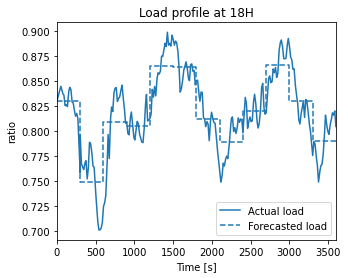

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1235 seconds.
0: |F(x)| = 9.601680411
1: |F(x)| = 3.497456408
2: |F(x)| = 0.1830766442
3: |F(x)| = 0.0007183028614
4: |F(x)| = 1.659288396e-08
Converged in 5 iterations in 0.0078 seconds.
Power flow results are consistent. Conversion is successful.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-08


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0049 seconds.
0: |F(x)| = 9.601680411
1: |F(x)| = 3.497456408
2: |F(x)| = 0.1830766442
3: |F(x)| = 0.0007183028614
4: |F(x)| = 1.659288396e-08
Converged in 5 iterations in 0.0048 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778906, gb cost=4889.131241556355


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.0313,39.9756,15.8831,1.0,970.0312
1,646.0000,228.9208,2.2281,1.0,646.0000
2,290.0000,81.0987,-0.8653,1.0,290.0000
3,652.0000,114.2245,7.2985,1.0,652.0000
4,508.0000,137.9576,5.4672,1.0,508.0000
5,646.6875,212.0871,6.4196,1.0,646.6875
6,232.0000,55.2884,3.4379,1.0,232.0000
7,564.0000,-59.8950,13.9534,1.0,564.0000
8,865.0000,49.8766,18.9462,1.0,865.0000
9,30.0000,49.8766,18.9462,1.0,30.0000


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.05

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [7]:
# %run -i 'cosim_bmain.py'

Loop

In [8]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4703.957
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0056 seconds.
0: |F(x)| = 7.905038032
1: |F(x)| = 3.451566076
2: |F(x)| = 0.1826707466
3: |F(x)| = 0.001144058568
4: |F(x)| = 3.262765791e-08
Converged in 5 iterations in 0.0088 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for

nec= 12602
Pr= 4.48992432085777


Simulation to t=5.00 sec completed in 0.0373 seconds.
Simulation to t=6.00 sec completed in 0.0401 seconds.
Simulation to t=7.00 sec completed in 0.0373 seconds.
Simulation to t=8.00 sec completed in 0.0392 seconds.


nec= 12598
Pr= 6.0738640317460435


Simulation to t=9.00 sec completed in 0.0482 seconds.
Simulation to t=10.00 sec completed in 0.0400 seconds.
Simulation to t=11.00 sec completed in 0.0381 seconds.
Simulation to t=12.00 sec completed in 0.0396 seconds.


nec= 12598
Pr= 9.05533037355582


Simulation to t=13.00 sec completed in 0.0421 seconds.
Simulation to t=14.00 sec completed in 0.0381 seconds.
Simulation to t=15.00 sec completed in 0.0358 seconds.
Simulation to t=16.00 sec completed in 0.0348 seconds.


nec= 12601
Pr= 11.556966560916983


Simulation to t=17.00 sec completed in 0.0559 seconds.
Simulation to t=18.00 sec completed in 0.0485 seconds.
Simulation to t=19.00 sec completed in 0.0341 seconds.
Simulation to t=20.00 sec completed in 0.0373 seconds.


nec= 12599
Pr= 14.149843333318469


Simulation to t=21.00 sec completed in 0.0364 seconds.
Simulation to t=22.00 sec completed in 0.0398 seconds.
Simulation to t=23.00 sec completed in 0.0430 seconds.
Simulation to t=24.00 sec completed in 0.0365 seconds.


nec= 12587
Pr= 16.735343531650816


Simulation to t=25.00 sec completed in 0.0385 seconds.
Simulation to t=26.00 sec completed in 0.0462 seconds.
Simulation to t=27.00 sec completed in 0.0346 seconds.
Simulation to t=28.00 sec completed in 0.0361 seconds.


nec= 12590
Pr= 19.330507149295478


Simulation to t=29.00 sec completed in 0.0365 seconds.
Simulation to t=30.00 sec completed in 0.0362 seconds.
Simulation to t=31.00 sec completed in 0.0343 seconds.
Simulation to t=32.00 sec completed in 0.0338 seconds.


nec= 12576
Pr= 21.930582959052305


Simulation to t=33.00 sec completed in 0.0393 seconds.
Simulation to t=34.00 sec completed in 0.0416 seconds.
Simulation to t=35.00 sec completed in 0.0395 seconds.
Simulation to t=36.00 sec completed in 0.0374 seconds.


nec= 12563
Pr= 24.588125248530357


Simulation to t=37.00 sec completed in 0.0399 seconds.
Simulation to t=38.00 sec completed in 0.0365 seconds.
Simulation to t=39.00 sec completed in 0.0439 seconds.
Simulation to t=40.00 sec completed in 0.0426 seconds.


nec= 12551
Pr= 34.129748701746806


Simulation to t=41.00 sec completed in 0.0486 seconds.
Simulation to t=42.00 sec completed in 0.0408 seconds.
Simulation to t=43.00 sec completed in 0.0476 seconds.
Simulation to t=44.00 sec completed in 0.0466 seconds.


nec= 12529
Pr= 34.90249596476922


Simulation to t=45.00 sec completed in 0.0450 seconds.
Simulation to t=46.00 sec completed in 0.0425 seconds.
Simulation to t=47.00 sec completed in 0.0442 seconds.
Simulation to t=48.00 sec completed in 0.0424 seconds.


nec= 12510
Pr= 37.624416043204036


Simulation to t=49.00 sec completed in 0.0391 seconds.
Simulation to t=50.00 sec completed in 0.0397 seconds.
Simulation to t=51.00 sec completed in 0.0415 seconds.
Simulation to t=52.00 sec completed in 0.0392 seconds.


nec= 12496
Pr= 39.20324649773006


Simulation to t=53.00 sec completed in 0.0449 seconds.
Simulation to t=54.00 sec completed in 0.0377 seconds.
Simulation to t=55.00 sec completed in 0.0396 seconds.
Simulation to t=56.00 sec completed in 0.0379 seconds.


nec= 12486
Pr= 38.786646727269414


Simulation to t=57.00 sec completed in 0.0359 seconds.
Simulation to t=58.00 sec completed in 0.0367 seconds.
Simulation to t=59.00 sec completed in 0.0380 seconds.
Simulation to t=60.00 sec completed in 0.0397 seconds.


nec= 12474
Pr= 38.1828855595748


Simulation to t=61.00 sec completed in 0.0390 seconds.
Simulation to t=62.00 sec completed in 0.0403 seconds.
Simulation to t=63.00 sec completed in 0.0367 seconds.
Simulation to t=64.00 sec completed in 0.0403 seconds.


nec= 12454
Pr= 36.80376045489533


Simulation to t=65.00 sec completed in 0.0409 seconds.
Simulation to t=66.00 sec completed in 0.0358 seconds.
Simulation to t=67.00 sec completed in 0.0375 seconds.
Simulation to t=68.00 sec completed in 0.0348 seconds.


nec= 12444
Pr= 35.212490614088914


Simulation to t=69.00 sec completed in 0.0361 seconds.
Simulation to t=70.00 sec completed in 0.0356 seconds.
Simulation to t=71.00 sec completed in 0.0400 seconds.
Simulation to t=72.00 sec completed in 0.0393 seconds.


nec= 12437
Pr= 33.29868616573789


Simulation to t=73.00 sec completed in 0.0436 seconds.
Simulation to t=74.00 sec completed in 0.0416 seconds.
Simulation to t=75.00 sec completed in 0.0447 seconds.
Simulation to t=76.00 sec completed in 0.0411 seconds.


nec= 12417
Pr= 31.32084863858265


Simulation to t=77.00 sec completed in 0.0427 seconds.
Simulation to t=78.00 sec completed in 0.0374 seconds.
Simulation to t=79.00 sec completed in 0.0402 seconds.
Simulation to t=80.00 sec completed in 0.0448 seconds.


nec= 12406
Pr= 23.599726841839427


Simulation to t=81.00 sec completed in 0.0385 seconds.
Simulation to t=82.00 sec completed in 0.0440 seconds.
Simulation to t=83.00 sec completed in 0.0406 seconds.
Simulation to t=84.00 sec completed in 0.0375 seconds.


nec= 12390
Pr= 23.874969808697173


Simulation to t=85.00 sec completed in 0.0357 seconds.
Simulation to t=86.00 sec completed in 0.0366 seconds.
Simulation to t=87.00 sec completed in 0.0375 seconds.
Simulation to t=88.00 sec completed in 0.0395 seconds.


nec= 12377
Pr= 22.545816297283782


Simulation to t=89.00 sec completed in 0.0371 seconds.
Simulation to t=90.00 sec completed in 0.0376 seconds.
Simulation to t=91.00 sec completed in 0.0350 seconds.
Simulation to t=92.00 sec completed in 0.0348 seconds.


nec= 12367
Pr= 21.92538986081254


Simulation to t=93.00 sec completed in 0.0465 seconds.
Simulation to t=94.00 sec completed in 0.0370 seconds.
Simulation to t=95.00 sec completed in 0.0383 seconds.
Simulation to t=96.00 sec completed in 0.0371 seconds.


nec= 12350
Pr= 18.13971942653193


Simulation to t=97.00 sec completed in 0.0384 seconds.
Simulation to t=98.00 sec completed in 0.0409 seconds.
Simulation to t=99.00 sec completed in 0.0425 seconds.
Simulation to t=100.00 sec completed in 0.0446 seconds.


nec= 12345
Pr= 14.536298072975182


Simulation to t=101.00 sec completed in 0.0376 seconds.
Simulation to t=102.00 sec completed in 0.0368 seconds.
Simulation to t=103.00 sec completed in 0.0371 seconds.
Simulation to t=104.00 sec completed in 0.0415 seconds.


nec= 12345
Pr= 10.078435899919366


Simulation to t=105.00 sec completed in 0.0452 seconds.
Simulation to t=106.00 sec completed in 0.0485 seconds.
Simulation to t=107.00 sec completed in 0.0388 seconds.


nec= 12349
Pr= 2.955542965656126
nec= 12349
Pr= 6.220855090833025


Simulation to t=108.00 sec completed in 0.0416 seconds.
Simulation to t=109.00 sec completed in 0.0475 seconds.
Simulation to t=110.00 sec completed in 0.0398 seconds.
Simulation to t=111.00 sec completed in 0.0392 seconds.


nec= 12351
Pr= 5.054362226022128


Simulation to t=112.00 sec completed in 0.0725 seconds.
Simulation to t=113.00 sec completed in 0.0559 seconds.
Simulation to t=114.00 sec completed in 0.0399 seconds.
Simulation to t=115.00 sec completed in 0.0386 seconds.
Simulation to t=116.00 sec completed in 0.0400 seconds.


nec= 12352
Pr= 3.733588174122591


Simulation to t=117.00 sec completed in 0.0380 seconds.
Simulation to t=118.00 sec completed in 0.0369 seconds.
Simulation to t=119.00 sec completed in 0.0403 seconds.
Simulation to t=120.00 sec completed in 0.0386 seconds.


nec= 12356
Pr= 10.725068833147295


Simulation to t=121.00 sec completed in 0.0492 seconds.
Simulation to t=122.00 sec completed in 0.0417 seconds.
Simulation to t=123.00 sec completed in 0.0454 seconds.
Simulation to t=124.00 sec completed in 0.0476 seconds.


nec= 12349
Pr= 8.262618713262206


Simulation to t=125.00 sec completed in 0.0375 seconds.
Simulation to t=126.00 sec completed in 0.0377 seconds.
Simulation to t=127.00 sec completed in 0.0361 seconds.
Simulation to t=128.00 sec completed in 0.0350 seconds.


nec= 12347
Pr= 7.942031644050418


Simulation to t=129.00 sec completed in 0.0383 seconds.
Simulation to t=130.00 sec completed in 0.0390 seconds.
Simulation to t=131.00 sec completed in 0.0364 seconds.
Simulation to t=132.00 sec completed in 0.0366 seconds.


nec= 12343
Pr= 7.596570979837863


Simulation to t=133.00 sec completed in 0.0369 seconds.
Simulation to t=134.00 sec completed in 0.0369 seconds.
Simulation to t=135.00 sec completed in 0.0392 seconds.
Simulation to t=136.00 sec completed in 0.0383 seconds.


nec= 12346
Pr= 7.369283226177885


Simulation to t=137.00 sec completed in 0.0461 seconds.
Simulation to t=138.00 sec completed in 0.0393 seconds.
Simulation to t=139.00 sec completed in 0.0371 seconds.
Simulation to t=140.00 sec completed in 0.0395 seconds.


nec= 12348
Pr= 8.291302639533933


Simulation to t=141.00 sec completed in 0.0354 seconds.
Simulation to t=142.00 sec completed in 0.0371 seconds.
Simulation to t=143.00 sec completed in 0.0357 seconds.
Simulation to t=144.00 sec completed in 0.0390 seconds.


nec= 12343
Pr= 12.721233852233286


Simulation to t=145.00 sec completed in 0.0358 seconds.
Simulation to t=146.00 sec completed in 0.0361 seconds.
Simulation to t=147.00 sec completed in 0.0398 seconds.
Simulation to t=148.00 sec completed in 0.0362 seconds.


nec= 12341
Pr= 17.777072767063633


Simulation to t=149.00 sec completed in 0.0377 seconds.
Simulation to t=150.00 sec completed in 0.0381 seconds.
Simulation to t=151.00 sec completed in 0.0365 seconds.
Simulation to t=152.00 sec completed in 0.0482 seconds.


nec= 12327
Pr= 23.736420202072274


Simulation to t=153.00 sec completed in 0.0381 seconds.
Simulation to t=154.00 sec completed in 0.0366 seconds.
Simulation to t=155.00 sec completed in 0.0365 seconds.
Simulation to t=156.00 sec completed in 0.0398 seconds.


nec= 12321
Pr= 27.25619216077903


Simulation to t=157.00 sec completed in 0.0354 seconds.
Simulation to t=158.00 sec completed in 0.0367 seconds.
Simulation to t=159.00 sec completed in 0.0380 seconds.
Simulation to t=160.00 sec completed in 0.0363 seconds.


nec= 12317
Pr= 23.029571059555476


Simulation to t=161.00 sec completed in 0.0360 seconds.
Simulation to t=162.00 sec completed in 0.0367 seconds.
Simulation to t=163.00 sec completed in 0.0408 seconds.
Simulation to t=164.00 sec completed in 0.0398 seconds.


nec= 12304
Pr= 28.128309565248756


Simulation to t=165.00 sec completed in 0.0430 seconds.
Simulation to t=166.00 sec completed in 0.0371 seconds.
Simulation to t=167.00 sec completed in 0.0373 seconds.
Simulation to t=168.00 sec completed in 0.0366 seconds.


nec= 12294
Pr= 30.40043909108574


Simulation to t=169.00 sec completed in 0.0376 seconds.
Simulation to t=170.00 sec completed in 0.0361 seconds.
Simulation to t=171.00 sec completed in 0.0406 seconds.
Simulation to t=172.00 sec completed in 0.0402 seconds.


nec= 12277
Pr= 31.564931166063243


Simulation to t=173.00 sec completed in 0.0396 seconds.
Simulation to t=174.00 sec completed in 0.0366 seconds.
Simulation to t=175.00 sec completed in 0.0356 seconds.
Simulation to t=176.00 sec completed in 0.0364 seconds.


nec= 12266
Pr= 32.02092681427117


Simulation to t=177.00 sec completed in 0.0370 seconds.
Simulation to t=178.00 sec completed in 0.0413 seconds.
Simulation to t=179.00 sec completed in 0.0436 seconds.
Simulation to t=180.00 sec completed in 0.0389 seconds.


nec= 12252
Pr= 31.930115473687472


Simulation to t=181.00 sec completed in 0.0393 seconds.
Simulation to t=182.00 sec completed in 0.0362 seconds.
Simulation to t=183.00 sec completed in 0.0366 seconds.
Simulation to t=184.00 sec completed in 0.0359 seconds.


nec= 12238
Pr= 29.86154946224184


Simulation to t=185.00 sec completed in 0.0368 seconds.
Simulation to t=186.00 sec completed in 0.0348 seconds.
Simulation to t=187.00 sec completed in 0.0374 seconds.
Simulation to t=188.00 sec completed in 0.0360 seconds.


nec= 12225
Pr= 25.642023564744648


Simulation to t=189.00 sec completed in 0.0444 seconds.
Simulation to t=190.00 sec completed in 0.0366 seconds.
Simulation to t=191.00 sec completed in 0.0362 seconds.
Simulation to t=192.00 sec completed in 0.0387 seconds.


nec= 12213
Pr= 21.057111131125744


Simulation to t=193.00 sec completed in 0.0392 seconds.
Simulation to t=194.00 sec completed in 0.0383 seconds.
Simulation to t=195.00 sec completed in 0.0371 seconds.
Simulation to t=196.00 sec completed in 0.0451 seconds.


nec= 12201
Pr= 15.576981180447536


Simulation to t=197.00 sec completed in 0.0433 seconds.
Simulation to t=198.00 sec completed in 0.0367 seconds.
Simulation to t=199.00 sec completed in 0.0349 seconds.
Simulation to t=200.00 sec completed in 0.0382 seconds.


nec= 12201
Pr= 22.021506183992898


Simulation to t=201.00 sec completed in 0.0364 seconds.
Simulation to t=202.00 sec completed in 0.0365 seconds.
Simulation to t=203.00 sec completed in 0.0362 seconds.
Simulation to t=204.00 sec completed in 0.0375 seconds.


nec= 12182
Pr= 17.508920591947927


Simulation to t=205.00 sec completed in 0.0397 seconds.
Simulation to t=206.00 sec completed in 0.0381 seconds.
Simulation to t=207.00 sec completed in 0.0357 seconds.
Simulation to t=208.00 sec completed in 0.0361 seconds.


nec= 12176
Pr= 16.21984527708757


Simulation to t=209.00 sec completed in 0.0358 seconds.
Simulation to t=210.00 sec completed in 0.0350 seconds.
Simulation to t=211.00 sec completed in 0.0390 seconds.
Simulation to t=212.00 sec completed in 0.0359 seconds.


nec= 12168
Pr= 13.96813980545172


Simulation to t=213.00 sec completed in 0.0381 seconds.
Simulation to t=214.00 sec completed in 0.0380 seconds.
Simulation to t=215.00 sec completed in 0.0376 seconds.
Simulation to t=216.00 sec completed in 0.0409 seconds.


nec= 12164
Pr= 10.835018545234535


Simulation to t=217.00 sec completed in 0.0392 seconds.
Simulation to t=218.00 sec completed in 0.0376 seconds.
Simulation to t=219.00 sec completed in 0.0386 seconds.
Simulation to t=220.00 sec completed in 0.0365 seconds.


nec= 12163
Pr= 8.809716720943051


Simulation to t=221.00 sec completed in 0.0373 seconds.
Simulation to t=222.00 sec completed in 0.0372 seconds.
Simulation to t=223.00 sec completed in 0.0378 seconds.


nec= 12166
Pr= 7.4573693426933625
nec= 12166
Pr= 7.961292440700311


Simulation to t=224.00 sec completed in 0.0385 seconds.
Simulation to t=225.00 sec completed in 0.0369 seconds.
Simulation to t=226.00 sec completed in 0.0382 seconds.
Simulation to t=227.00 sec completed in 0.0352 seconds.


nec= 12170
Pr= 6.7953369370313395
nec= 12170
Pr= 7.126310654309991


Simulation to t=228.00 sec completed in 0.0405 seconds.
Simulation to t=229.00 sec completed in 0.0367 seconds.
Simulation to t=230.00 sec completed in 0.0383 seconds.
Simulation to t=231.00 sec completed in 0.0379 seconds.


nec= 12174
Pr= 5.995460602989566
nec= 12174
Pr= 6.395315914828945


Simulation to t=232.00 sec completed in 0.0529 seconds.
Simulation to t=233.00 sec completed in 0.0375 seconds.
Simulation to t=234.00 sec completed in 0.0374 seconds.
Simulation to t=235.00 sec completed in 0.0381 seconds.


nec= 12175
Pr= 5.301056613477724
nec= 12175
Pr= 5.648204189264435


Simulation to t=236.00 sec completed in 0.0375 seconds.
Simulation to t=237.00 sec completed in 0.0434 seconds.
Simulation to t=238.00 sec completed in 0.0382 seconds.
Simulation to t=239.00 sec completed in 0.0369 seconds.


nec= 12179
Pr= -11.331486196996169
nec= 12179
Pr= -3.7443656548025057


Simulation to t=240.00 sec completed in 0.0523 seconds.
Simulation to t=241.00 sec completed in 0.0507 seconds.
Simulation to t=242.00 sec completed in 0.0584 seconds.
Simulation to t=243.00 sec completed in 0.0396 seconds.
Simulation to t=244.00 sec completed in 0.0410 seconds.


nec= 12178
Pr= -3.6783335719053314


Simulation to t=245.00 sec completed in 0.0519 seconds.
Simulation to t=246.00 sec completed in 0.0371 seconds.
Simulation to t=247.00 sec completed in 0.0370 seconds.
Simulation to t=248.00 sec completed in 0.0371 seconds.


nec= 12174
Pr= -3.736359264732269


Simulation to t=249.00 sec completed in 0.0357 seconds.
Simulation to t=250.00 sec completed in 0.0388 seconds.
Simulation to t=251.00 sec completed in 0.0371 seconds.
Simulation to t=252.00 sec completed in 0.0363 seconds.


nec= 12169
Pr= -3.5695296619052987


Simulation to t=253.00 sec completed in 0.0349 seconds.
Simulation to t=254.00 sec completed in 0.0404 seconds.
Simulation to t=255.00 sec completed in 0.0392 seconds.
Simulation to t=256.00 sec completed in 0.0394 seconds.


nec= 12168
Pr= -3.370868543724415


Simulation to t=257.00 sec completed in 0.0355 seconds.
Simulation to t=258.00 sec completed in 0.0356 seconds.
Simulation to t=259.00 sec completed in 0.0337 seconds.
Simulation to t=260.00 sec completed in 0.0353 seconds.


nec= 12166
Pr= -3.5728358039968766


Simulation to t=261.00 sec completed in 0.0347 seconds.
Simulation to t=262.00 sec completed in 0.0349 seconds.
Simulation to t=263.00 sec completed in 0.0345 seconds.
Simulation to t=264.00 sec completed in 0.0355 seconds.


nec= 12164
Pr= -3.9011129076937117


Simulation to t=265.00 sec completed in 0.0342 seconds.
Simulation to t=266.00 sec completed in 0.0336 seconds.
Simulation to t=267.00 sec completed in 0.0369 seconds.
Simulation to t=268.00 sec completed in 0.0336 seconds.


nec= 12157
Pr= -4.308109726142648


Simulation to t=269.00 sec completed in 0.0342 seconds.
Simulation to t=270.00 sec completed in 0.0353 seconds.
Simulation to t=271.00 sec completed in 0.0518 seconds.
Simulation to t=272.00 sec completed in 0.0416 seconds.


nec= 12146
Pr= -4.9081392989191315


Simulation to t=273.00 sec completed in 0.0480 seconds.
Simulation to t=274.00 sec completed in 0.0438 seconds.
Simulation to t=275.00 sec completed in 0.0438 seconds.
Simulation to t=276.00 sec completed in 0.0531 seconds.


nec= 12141
Pr= -6.963653564452515


Simulation to t=277.00 sec completed in 0.0509 seconds.
Simulation to t=278.00 sec completed in 0.0473 seconds.
Simulation to t=279.00 sec completed in 0.0423 seconds.
Simulation to t=280.00 sec completed in 0.0549 seconds.


nec= 12138
Pr= 0.23481092814246196


Simulation to t=281.00 sec completed in 0.0481 seconds.
Simulation to t=282.00 sec completed in 0.0474 seconds.
Simulation to t=283.00 sec completed in 0.0498 seconds.
Simulation to t=284.00 sec completed in 0.0521 seconds.


nec= 12134
Pr= -2.8486302244303197


Simulation to t=285.00 sec completed in 0.0518 seconds.
Simulation to t=286.00 sec completed in 0.0502 seconds.
Simulation to t=287.00 sec completed in 0.0534 seconds.
Simulation to t=288.00 sec completed in 0.0512 seconds.


nec= 12130
Pr= -5.656053568764573


Simulation to t=289.00 sec completed in 0.0488 seconds.
Simulation to t=290.00 sec completed in 0.0520 seconds.
Simulation to t=291.00 sec completed in 0.0560 seconds.


nec= 12126
Pr= -9.55559215583655
nec= 12126
Pr= -8.999528798870017


Simulation to t=292.00 sec completed in 0.0506 seconds.
Simulation to t=293.00 sec completed in 0.0495 seconds.
Simulation to t=294.00 sec completed in 0.0534 seconds.
Simulation to t=295.00 sec completed in 0.0515 seconds.
Simulation to t=296.00 sec completed in 0.0523 seconds.
Simulation to t=297.00 sec completed in 0.0606 seconds.
Simulation to t=298.00 sec completed in 0.0607 seconds.
Simulation to t=299.00 sec completed in 0.0498 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4618.534
Simulation to t=300.00 sec completed in 0.0688 seconds.


nec= 12136
Pr= 7.245418511271982


Simulation to t=301.00 sec completed in 0.0637 seconds.
Simulation to t=302.00 sec completed in 0.0670 seconds.
Simulation to t=303.00 sec completed in 0.0723 seconds.
Simulation to t=304.00 sec completed in 0.0571 seconds.
Simulation to t=305.00 sec completed in 0.0531 seconds.
Simulation to t=306.00 sec completed in 0.0527 seconds.
Simulation to t=307.00 sec completed in 0.0516 seconds.
Simulation to t=308.00 sec completed in 0.0522 seconds.
Simulation to t=309.00 sec completed in 0.0525 seconds.
Simulation to t=310.00 sec completed in 0.0495 seconds.
Simulation to t=311.00 sec completed in 0.0505 seconds.
Simulation to t=312.00 sec completed in 0.0505 seconds.
Simulation to t=313.00 sec completed in 0.0515 seconds.
Simulation to t=314.00 sec completed in 0.0530 seconds.
Simulation to t=315.00 sec completed in 0.0506 seconds.
Simulation to t=316.00 sec completed in 0.0515 seconds.
Simulation to t=317.00 sec completed in 0.0525 seconds.
Simulation to t=318.00 sec completed in 0.0579 s

nec= 12083
Pr= -1.6184023610509577


Simulation to t=321.00 sec completed in 0.0578 seconds.
Simulation to t=322.00 sec completed in 0.0580 seconds.
Simulation to t=323.00 sec completed in 0.0519 seconds.
Simulation to t=324.00 sec completed in 0.0517 seconds.


nec= 12081
Pr= -1.5303507680680228


Simulation to t=325.00 sec completed in 0.0492 seconds.
Simulation to t=326.00 sec completed in 0.0511 seconds.
Simulation to t=327.00 sec completed in 0.0469 seconds.
Simulation to t=328.00 sec completed in 0.0452 seconds.


nec= 12081
Pr= -1.0218945776587125


Simulation to t=329.00 sec completed in 0.0499 seconds.
Simulation to t=330.00 sec completed in 0.0569 seconds.
Simulation to t=331.00 sec completed in 0.0652 seconds.
Simulation to t=332.00 sec completed in 0.0517 seconds.


nec= 12081
Pr= -0.5690361158069877


Simulation to t=333.00 sec completed in 0.0502 seconds.
Simulation to t=334.00 sec completed in 0.0526 seconds.
Simulation to t=335.00 sec completed in 0.0619 seconds.
Simulation to t=336.00 sec completed in 0.0540 seconds.


nec= 12077
Pr= -0.1520039685620751


Simulation to t=337.00 sec completed in 0.0446 seconds.
Simulation to t=338.00 sec completed in 0.0373 seconds.
Simulation to t=339.00 sec completed in 0.0390 seconds.
Simulation to t=340.00 sec completed in 0.0347 seconds.


nec= 12077
Pr= 0.25559922172742566


Simulation to t=341.00 sec completed in 0.0381 seconds.
Simulation to t=342.00 sec completed in 0.0379 seconds.
Simulation to t=343.00 sec completed in 0.0362 seconds.
Simulation to t=344.00 sec completed in 0.0463 seconds.


nec= 12077
Pr= 0.646513273455018


Simulation to t=345.00 sec completed in 0.0371 seconds.
Simulation to t=346.00 sec completed in 0.0460 seconds.
Simulation to t=347.00 sec completed in 0.0415 seconds.
Simulation to t=348.00 sec completed in 0.0752 seconds.


nec= 12076
Pr= 4.3167463227651695


Simulation to t=349.00 sec completed in 0.0505 seconds.
Simulation to t=350.00 sec completed in 0.0551 seconds.
Simulation to t=351.00 sec completed in 0.0497 seconds.
Simulation to t=352.00 sec completed in 0.0760 seconds.


nec= 12066
Pr= 14.277280588196456


Simulation to t=353.00 sec completed in 0.0551 seconds.
Simulation to t=354.00 sec completed in 0.0510 seconds.
Simulation to t=355.00 sec completed in 0.0497 seconds.
Simulation to t=356.00 sec completed in 0.0526 seconds.


nec= 12061
Pr= 21.232229101313738


Simulation to t=357.00 sec completed in 0.0566 seconds.
Simulation to t=358.00 sec completed in 0.0538 seconds.
Simulation to t=359.00 sec completed in 0.0492 seconds.
Simulation to t=360.00 sec completed in 0.0622 seconds.


nec= 12055
Pr= 37.280338170018766


Simulation to t=361.00 sec completed in 0.0539 seconds.
Simulation to t=362.00 sec completed in 0.0525 seconds.
Simulation to t=363.00 sec completed in 0.0490 seconds.
Simulation to t=364.00 sec completed in 0.0649 seconds.


nec= 12044
Pr= 39.39444761397096


Simulation to t=365.00 sec completed in 0.0529 seconds.
Simulation to t=366.00 sec completed in 0.0490 seconds.
Simulation to t=367.00 sec completed in 0.0504 seconds.
Simulation to t=368.00 sec completed in 0.0523 seconds.


nec= 12029
Pr= 43.506629990080654


Simulation to t=369.00 sec completed in 0.0513 seconds.
Simulation to t=370.00 sec completed in 0.0494 seconds.
Simulation to t=371.00 sec completed in 0.0502 seconds.
Simulation to t=372.00 sec completed in 0.0491 seconds.


nec= 12013
Pr= 45.612207496983004


Simulation to t=373.00 sec completed in 0.0493 seconds.
Simulation to t=374.00 sec completed in 0.0423 seconds.
Simulation to t=375.00 sec completed in 0.0415 seconds.
Simulation to t=376.00 sec completed in 0.0573 seconds.


nec= 12006
Pr= 48.227917284570644


Simulation to t=377.00 sec completed in 0.0533 seconds.
Simulation to t=378.00 sec completed in 0.0549 seconds.
Simulation to t=379.00 sec completed in 0.0465 seconds.
Simulation to t=380.00 sec completed in 0.0546 seconds.


nec= 11996
Pr= 43.97621205257926


Simulation to t=381.00 sec completed in 0.0519 seconds.
Simulation to t=382.00 sec completed in 0.0503 seconds.
Simulation to t=383.00 sec completed in 0.0465 seconds.
Simulation to t=384.00 sec completed in 0.0520 seconds.


nec= 11993
Pr= 37.813721921223014


Simulation to t=385.00 sec completed in 0.0499 seconds.
Simulation to t=386.00 sec completed in 0.0594 seconds.
Simulation to t=387.00 sec completed in 0.0510 seconds.
Simulation to t=388.00 sec completed in 0.0524 seconds.


nec= 11982
Pr= 29.962568116405734


Simulation to t=389.00 sec completed in 0.0531 seconds.
Simulation to t=390.00 sec completed in 0.0497 seconds.
Simulation to t=391.00 sec completed in 0.0553 seconds.
Simulation to t=392.00 sec completed in 0.0524 seconds.


nec= 11974
Pr= 21.61685193518959


Simulation to t=393.00 sec completed in 0.0520 seconds.
Simulation to t=394.00 sec completed in 0.0548 seconds.
Simulation to t=395.00 sec completed in 0.0495 seconds.
Simulation to t=396.00 sec completed in 0.0516 seconds.


nec= 11969
Pr= 22.987029336955622


Simulation to t=397.00 sec completed in 0.0497 seconds.
Simulation to t=398.00 sec completed in 0.0501 seconds.
Simulation to t=399.00 sec completed in 0.0523 seconds.


nec= 11959
Pr= 14.837515477903176
nec= 11959
Pr= 15.298221637124492


Simulation to t=400.00 sec completed in 0.0550 seconds.
Simulation to t=401.00 sec completed in 0.0504 seconds.
Simulation to t=402.00 sec completed in 0.0537 seconds.
Simulation to t=403.00 sec completed in 0.0517 seconds.
Simulation to t=404.00 sec completed in 0.0497 seconds.


nec= 11962
Pr= 21.389825034481262


Simulation to t=405.00 sec completed in 0.0519 seconds.
Simulation to t=406.00 sec completed in 0.0535 seconds.
Simulation to t=407.00 sec completed in 0.0510 seconds.
Simulation to t=408.00 sec completed in 0.0580 seconds.


nec= 11955
Pr= 26.467134378987495


Simulation to t=409.00 sec completed in 0.0540 seconds.
Simulation to t=410.00 sec completed in 0.0536 seconds.
Simulation to t=411.00 sec completed in 0.0509 seconds.
Simulation to t=412.00 sec completed in 0.0527 seconds.


nec= 11942
Pr= 38.97466812840024


Simulation to t=413.00 sec completed in 0.0574 seconds.
Simulation to t=414.00 sec completed in 0.0537 seconds.
Simulation to t=415.00 sec completed in 0.0544 seconds.
Simulation to t=416.00 sec completed in 0.0621 seconds.


nec= 11935
Pr= 50.57776340631438


Simulation to t=417.00 sec completed in 0.0602 seconds.
Simulation to t=418.00 sec completed in 0.0556 seconds.
Simulation to t=419.00 sec completed in 0.0714 seconds.
Simulation to t=420.00 sec completed in 0.0587 seconds.


nec= 11912
Pr= 65.13075733007027


Simulation to t=421.00 sec completed in 0.0687 seconds.
Simulation to t=422.00 sec completed in 0.0541 seconds.
Simulation to t=423.00 sec completed in 0.0506 seconds.
Simulation to t=424.00 sec completed in 0.0505 seconds.


nec= 11903
Pr= 74.01668398361238


Simulation to t=425.00 sec completed in 0.0497 seconds.
Simulation to t=426.00 sec completed in 0.0511 seconds.
Simulation to t=427.00 sec completed in 0.0606 seconds.
Simulation to t=428.00 sec completed in 0.0510 seconds.


nec= 11889
Pr= 78.2738121608495


Simulation to t=429.00 sec completed in 0.0515 seconds.
Simulation to t=430.00 sec completed in 0.0507 seconds.
Simulation to t=431.00 sec completed in 0.0734 seconds.
Simulation to t=432.00 sec completed in 0.0521 seconds.


nec= 11876
Pr= 81.9960738628232


Simulation to t=433.00 sec completed in 0.0671 seconds.
Simulation to t=434.00 sec completed in 0.0690 seconds.
Simulation to t=435.00 sec completed in 0.0533 seconds.
Simulation to t=436.00 sec completed in 0.0597 seconds.


nec= 11865
Pr= 83.33829802613299


Simulation to t=437.00 sec completed in 0.0482 seconds.
Simulation to t=438.00 sec completed in 0.0574 seconds.
Simulation to t=439.00 sec completed in 0.0516 seconds.


nec= 11855
Pr= 87.44020918354396


Simulation to t=440.00 sec completed in 0.0807 seconds.
Simulation to t=441.00 sec completed in 0.0713 seconds.
Simulation to t=442.00 sec completed in 0.0451 seconds.
Simulation to t=443.00 sec completed in 0.0474 seconds.
Simulation to t=444.00 sec completed in 0.0390 seconds.


nec= 11837
Pr= 85.84647512401814


Simulation to t=445.00 sec completed in 0.0452 seconds.
Simulation to t=446.00 sec completed in 0.0470 seconds.
Simulation to t=447.00 sec completed in 0.0392 seconds.
Simulation to t=448.00 sec completed in 0.0516 seconds.


nec= 11825
Pr= 82.06794007278728


Simulation to t=449.00 sec completed in 0.0556 seconds.
Simulation to t=450.00 sec completed in 0.0626 seconds.
Simulation to t=451.00 sec completed in 0.0559 seconds.
Simulation to t=452.00 sec completed in 0.0521 seconds.


nec= 11814
Pr= 77.54810383085376


Simulation to t=453.00 sec completed in 0.0681 seconds.
Simulation to t=454.00 sec completed in 0.0579 seconds.
Simulation to t=455.00 sec completed in 0.0484 seconds.
Simulation to t=456.00 sec completed in 0.0746 seconds.


nec= 11805
Pr= 70.70447087638095


Simulation to t=457.00 sec completed in 0.0859 seconds.
Simulation to t=458.00 sec completed in 0.0601 seconds.
Simulation to t=459.00 sec completed in 0.0571 seconds.
Simulation to t=460.00 sec completed in 0.0685 seconds.


nec= 11795
Pr= 63.68363716894702


Simulation to t=461.00 sec completed in 0.0549 seconds.
Simulation to t=462.00 sec completed in 0.0550 seconds.
Simulation to t=463.00 sec completed in 0.0500 seconds.
Simulation to t=464.00 sec completed in 0.0657 seconds.


nec= 11785
Pr= 55.76167108106366


Simulation to t=465.00 sec completed in 0.0577 seconds.
Simulation to t=466.00 sec completed in 0.0545 seconds.
Simulation to t=467.00 sec completed in 0.0568 seconds.
Simulation to t=468.00 sec completed in 0.0549 seconds.


nec= 11766
Pr= 48.95548899757649


Simulation to t=469.00 sec completed in 0.0552 seconds.
Simulation to t=470.00 sec completed in 0.0588 seconds.
Simulation to t=471.00 sec completed in 0.0539 seconds.
Simulation to t=472.00 sec completed in 0.0626 seconds.


nec= 11754
Pr= 46.08091943909994


Simulation to t=473.00 sec completed in 0.0524 seconds.
Simulation to t=474.00 sec completed in 0.0532 seconds.
Simulation to t=475.00 sec completed in 0.0487 seconds.
Simulation to t=476.00 sec completed in 0.0598 seconds.


nec= 11749
Pr= 42.803257501070526


Simulation to t=477.00 sec completed in 0.0509 seconds.
Simulation to t=478.00 sec completed in 0.0628 seconds.
Simulation to t=479.00 sec completed in 0.0534 seconds.


nec= 11735
Pr= 35.365226830729924
nec= 11735
Pr= 35.74259138110964


Simulation to t=480.00 sec completed in 0.0704 seconds.
Simulation to t=481.00 sec completed in 0.0525 seconds.
Simulation to t=482.00 sec completed in 0.0529 seconds.
Simulation to t=483.00 sec completed in 0.0552 seconds.


nec= 11742
Pr= 28.66215930738703
nec= 11742
Pr= 32.013693069058476


Simulation to t=484.00 sec completed in 0.0623 seconds.
Simulation to t=485.00 sec completed in 0.0537 seconds.
Simulation to t=486.00 sec completed in 0.0520 seconds.
Simulation to t=487.00 sec completed in 0.0522 seconds.


nec= 11740
Pr= 19.231404452803943
nec= 11740
Pr= 23.015980245765157


Simulation to t=488.00 sec completed in 0.0623 seconds.
Simulation to t=489.00 sec completed in 0.0552 seconds.
Simulation to t=490.00 sec completed in 0.0544 seconds.
Simulation to t=491.00 sec completed in 0.0651 seconds.


nec= 11738
Pr= 10.17908715731914
nec= 11738
Pr= 14.458603240150653


Simulation to t=492.00 sec completed in 0.0696 seconds.
Simulation to t=493.00 sec completed in 0.0579 seconds.
Simulation to t=494.00 sec completed in 0.0497 seconds.
Simulation to t=495.00 sec completed in 0.0581 seconds.


nec= 11737
Pr= -2.7268719561217853
nec= 11737
Pr= 3.7259253073595033


Simulation to t=496.00 sec completed in 0.0751 seconds.
Simulation to t=497.00 sec completed in 0.0593 seconds.
Simulation to t=498.00 sec completed in 0.0558 seconds.
Simulation to t=499.00 sec completed in 0.0531 seconds.
Simulation to t=500.00 sec completed in 0.0561 seconds.


nec= 11730
Pr= 3.4343986547398213


Simulation to t=501.00 sec completed in 0.0506 seconds.
Simulation to t=502.00 sec completed in 0.0528 seconds.
Simulation to t=503.00 sec completed in 0.0545 seconds.
Simulation to t=504.00 sec completed in 0.0570 seconds.


nec= 11734
Pr= 3.0983129512311893


Simulation to t=505.00 sec completed in 0.0578 seconds.
Simulation to t=506.00 sec completed in 0.0581 seconds.
Simulation to t=507.00 sec completed in 0.0542 seconds.
Simulation to t=508.00 sec completed in 0.0642 seconds.


nec= 11732
Pr= 2.7899660764949537


Simulation to t=509.00 sec completed in 0.0747 seconds.
Simulation to t=510.00 sec completed in 0.0751 seconds.
Simulation to t=511.00 sec completed in 0.0585 seconds.
Simulation to t=512.00 sec completed in 0.0640 seconds.


nec= 11724
Pr= 2.4734478913600304


Simulation to t=513.00 sec completed in 0.0705 seconds.
Simulation to t=514.00 sec completed in 0.0388 seconds.
Simulation to t=515.00 sec completed in 0.0374 seconds.
Simulation to t=516.00 sec completed in 0.0438 seconds.


nec= 11722
Pr= 2.1669309010331057


Simulation to t=517.00 sec completed in 0.0369 seconds.
Simulation to t=518.00 sec completed in 0.0430 seconds.
Simulation to t=519.00 sec completed in 0.0369 seconds.
Simulation to t=520.00 sec completed in 0.0412 seconds.


nec= 11717
Pr= 8.332556223617257


Simulation to t=521.00 sec completed in 0.0399 seconds.
Simulation to t=522.00 sec completed in 0.0386 seconds.
Simulation to t=523.00 sec completed in 0.0371 seconds.
Simulation to t=524.00 sec completed in 0.0422 seconds.


nec= 11706
Pr= 7.979963444606422


Simulation to t=525.00 sec completed in 0.0387 seconds.
Simulation to t=526.00 sec completed in 0.0378 seconds.
Simulation to t=527.00 sec completed in 0.0372 seconds.
Simulation to t=528.00 sec completed in 0.0380 seconds.


nec= 11689
Pr= 7.6980314785662305


Simulation to t=529.00 sec completed in 0.0401 seconds.
Simulation to t=530.00 sec completed in 0.0402 seconds.
Simulation to t=531.00 sec completed in 0.0379 seconds.
Simulation to t=532.00 sec completed in 0.0400 seconds.


nec= 11685
Pr= 7.62084114331909


Simulation to t=533.00 sec completed in 0.0384 seconds.
Simulation to t=534.00 sec completed in 0.0381 seconds.
Simulation to t=535.00 sec completed in 0.0374 seconds.
Simulation to t=536.00 sec completed in 0.0387 seconds.
Simulation to t=537.00 sec completed in 0.0442 seconds.
Simulation to t=538.00 sec completed in 0.0423 seconds.
Simulation to t=539.00 sec completed in 0.0402 seconds.
Simulation to t=540.00 sec completed in 0.0409 seconds.
Simulation to t=541.00 sec completed in 0.0379 seconds.
Simulation to t=542.00 sec completed in 0.0356 seconds.
Simulation to t=543.00 sec completed in 0.0382 seconds.
Simulation to t=544.00 sec completed in 0.0361 seconds.
Simulation to t=545.00 sec completed in 0.0361 seconds.
Simulation to t=546.00 sec completed in 0.0395 seconds.
Simulation to t=547.00 sec completed in 0.0411 seconds.
Simulation to t=548.00 sec completed in 0.0496 seconds.
Simulation to t=549.00 sec completed in 0.0421 seconds.
Simulation to t=550.00 sec completed in 0.0386 s

nec= 11638
Pr= 2.2421853430062946


Simulation to t=561.00 sec completed in 0.0412 seconds.
Simulation to t=562.00 sec completed in 0.0461 seconds.
Simulation to t=563.00 sec completed in 0.0372 seconds.
Simulation to t=564.00 sec completed in 0.0355 seconds.
Simulation to t=565.00 sec completed in 0.0368 seconds.
Simulation to t=566.00 sec completed in 0.0411 seconds.
Simulation to t=567.00 sec completed in 0.0389 seconds.
Simulation to t=568.00 sec completed in 0.0351 seconds.
Simulation to t=569.00 sec completed in 0.0389 seconds.
Simulation to t=570.00 sec completed in 0.0370 seconds.
Simulation to t=571.00 sec completed in 0.0364 seconds.
Simulation to t=572.00 sec completed in 0.0388 seconds.
Simulation to t=573.00 sec completed in 0.0375 seconds.
Simulation to t=574.00 sec completed in 0.0369 seconds.
Simulation to t=575.00 sec completed in 0.0401 seconds.
Simulation to t=576.00 sec completed in 0.0392 seconds.
Simulation to t=577.00 sec completed in 0.0400 seconds.
Simulation to t=578.00 sec completed in 0.0372 s

nec= 11648
Pr= 4.264282847671814


Simulation to t=601.00 sec completed in 0.0383 seconds.
Simulation to t=602.00 sec completed in 0.0388 seconds.
Simulation to t=603.00 sec completed in 0.0375 seconds.
Simulation to t=604.00 sec completed in 0.0406 seconds.
Simulation to t=605.00 sec completed in 0.0401 seconds.
Simulation to t=606.00 sec completed in 0.0400 seconds.
Simulation to t=607.00 sec completed in 0.0393 seconds.
Simulation to t=608.00 sec completed in 0.0383 seconds.
Simulation to t=609.00 sec completed in 0.0396 seconds.
Simulation to t=610.00 sec completed in 0.0390 seconds.
Simulation to t=611.00 sec completed in 0.0371 seconds.
Simulation to t=612.00 sec completed in 0.0388 seconds.
Simulation to t=613.00 sec completed in 0.0357 seconds.
Simulation to t=614.00 sec completed in 0.0378 seconds.
Simulation to t=615.00 sec completed in 0.0397 seconds.
Simulation to t=616.00 sec completed in 0.0406 seconds.
Simulation to t=617.00 sec completed in 0.0446 seconds.
Simulation to t=618.00 sec completed in 0.0390 s

nec= 11613
Pr= -2.7332503629051565
nec= 11613
Pr= -1.1750768737233006


Simulation to t=640.00 sec completed in 0.0502 seconds.
Simulation to t=641.00 sec completed in 0.0485 seconds.
Simulation to t=642.00 sec completed in 0.0435 seconds.
Simulation to t=643.00 sec completed in 0.0427 seconds.
Simulation to t=644.00 sec completed in 0.0442 seconds.
Simulation to t=645.00 sec completed in 0.0501 seconds.
Simulation to t=646.00 sec completed in 0.0508 seconds.
Simulation to t=647.00 sec completed in 0.0478 seconds.
Simulation to t=648.00 sec completed in 0.0526 seconds.
Simulation to t=649.00 sec completed in 0.0536 seconds.
Simulation to t=650.00 sec completed in 0.0507 seconds.
Simulation to t=651.00 sec completed in 0.0524 seconds.
Simulation to t=652.00 sec completed in 0.0510 seconds.
Simulation to t=653.00 sec completed in 0.0512 seconds.
Simulation to t=654.00 sec completed in 0.0518 seconds.
Simulation to t=655.00 sec completed in 0.0522 seconds.
Simulation to t=656.00 sec completed in 0.0500 seconds.
Simulation to t=657.00 sec completed in 0.0510 s

nec= 11610
Pr= 4.868951503309565


Simulation to t=681.00 sec completed in 0.0586 seconds.
Simulation to t=682.00 sec completed in 0.0542 seconds.
Simulation to t=683.00 sec completed in 0.0501 seconds.
Simulation to t=684.00 sec completed in 0.0592 seconds.
Simulation to t=685.00 sec completed in 0.0586 seconds.
Simulation to t=686.00 sec completed in 0.0567 seconds.
Simulation to t=687.00 sec completed in 0.0543 seconds.
Simulation to t=688.00 sec completed in 0.0555 seconds.
Simulation to t=689.00 sec completed in 0.0521 seconds.
Simulation to t=690.00 sec completed in 0.0574 seconds.
Simulation to t=691.00 sec completed in 0.0524 seconds.
Simulation to t=692.00 sec completed in 0.0581 seconds.


nec= 11600
Pr= 6.740924620983511


Simulation to t=693.00 sec completed in 0.0357 seconds.
Simulation to t=694.00 sec completed in 0.0428 seconds.
Simulation to t=695.00 sec completed in 0.0420 seconds.
Simulation to t=696.00 sec completed in 0.0548 seconds.


nec= 11596
Pr= 8.635076362183783


Simulation to t=697.00 sec completed in 0.0419 seconds.
Simulation to t=698.00 sec completed in 0.0519 seconds.
Simulation to t=699.00 sec completed in 0.0503 seconds.
Simulation to t=700.00 sec completed in 0.0538 seconds.


nec= 11591
Pr= 10.104820617932416


Simulation to t=701.00 sec completed in 0.0544 seconds.
Simulation to t=702.00 sec completed in 0.0373 seconds.
Simulation to t=703.00 sec completed in 0.0452 seconds.
Simulation to t=704.00 sec completed in 0.0366 seconds.


nec= 11587
Pr= 11.247463867833995


Simulation to t=705.00 sec completed in 0.0390 seconds.
Simulation to t=706.00 sec completed in 0.0393 seconds.
Simulation to t=707.00 sec completed in 0.0368 seconds.
Simulation to t=708.00 sec completed in 0.0385 seconds.


nec= 11574
Pr= 19.935116534382786


Simulation to t=709.00 sec completed in 0.0409 seconds.
Simulation to t=710.00 sec completed in 0.0372 seconds.
Simulation to t=711.00 sec completed in 0.0361 seconds.
Simulation to t=712.00 sec completed in 0.0386 seconds.


nec= 11570
Pr= 22.77268485900845


Simulation to t=713.00 sec completed in 0.0367 seconds.
Simulation to t=714.00 sec completed in 0.0360 seconds.
Simulation to t=715.00 sec completed in 0.0414 seconds.
Simulation to t=716.00 sec completed in 0.0357 seconds.


nec= 11567
Pr= 25.59929393702943


Simulation to t=717.00 sec completed in 0.0408 seconds.
Simulation to t=718.00 sec completed in 0.0368 seconds.
Simulation to t=719.00 sec completed in 0.0402 seconds.
Simulation to t=720.00 sec completed in 0.0421 seconds.


nec= 11554
Pr= 19.394549487189366


Simulation to t=721.00 sec completed in 0.0449 seconds.
Simulation to t=722.00 sec completed in 0.0367 seconds.
Simulation to t=723.00 sec completed in 0.0395 seconds.
Simulation to t=724.00 sec completed in 0.0419 seconds.


nec= 11548
Pr= 24.135454470031483


Simulation to t=725.00 sec completed in 0.0394 seconds.
Simulation to t=726.00 sec completed in 0.0375 seconds.
Simulation to t=727.00 sec completed in 0.0363 seconds.
Simulation to t=728.00 sec completed in 0.0417 seconds.


nec= 11541
Pr= 30.167307695588093


Simulation to t=729.00 sec completed in 0.0378 seconds.
Simulation to t=730.00 sec completed in 0.0388 seconds.
Simulation to t=731.00 sec completed in 0.0388 seconds.
Simulation to t=732.00 sec completed in 0.0490 seconds.


nec= 11537
Pr= 37.02735260869622


Simulation to t=733.00 sec completed in 0.0446 seconds.
Simulation to t=734.00 sec completed in 0.0433 seconds.
Simulation to t=735.00 sec completed in 0.0406 seconds.
Simulation to t=736.00 sec completed in 0.0543 seconds.


nec= 11526
Pr= 44.77901888602329


Simulation to t=737.00 sec completed in 0.0414 seconds.
Simulation to t=738.00 sec completed in 0.0480 seconds.
Simulation to t=739.00 sec completed in 0.0386 seconds.
Simulation to t=740.00 sec completed in 0.0479 seconds.


nec= 11519
Pr= 49.84006898887121


Simulation to t=741.00 sec completed in 0.0395 seconds.
Simulation to t=742.00 sec completed in 0.0416 seconds.
Simulation to t=743.00 sec completed in 0.0364 seconds.
Simulation to t=744.00 sec completed in 0.0496 seconds.


nec= 11510
Pr= 54.18420330698616


Simulation to t=745.00 sec completed in 0.0367 seconds.
Simulation to t=746.00 sec completed in 0.0374 seconds.
Simulation to t=747.00 sec completed in 0.0356 seconds.
Simulation to t=748.00 sec completed in 0.0402 seconds.


nec= 11500
Pr= 57.76381446949488


Simulation to t=749.00 sec completed in 0.0367 seconds.
Simulation to t=750.00 sec completed in 0.0407 seconds.
Simulation to t=751.00 sec completed in 0.0369 seconds.
Simulation to t=752.00 sec completed in 0.0511 seconds.


nec= 11491
Pr= 61.110056056176916


Simulation to t=753.00 sec completed in 0.0372 seconds.
Simulation to t=754.00 sec completed in 0.0378 seconds.
Simulation to t=755.00 sec completed in 0.0376 seconds.
Simulation to t=756.00 sec completed in 0.0366 seconds.


nec= 11487
Pr= 62.52501155077446


Simulation to t=757.00 sec completed in 0.0383 seconds.
Simulation to t=758.00 sec completed in 0.0397 seconds.
Simulation to t=759.00 sec completed in 0.0354 seconds.
Simulation to t=760.00 sec completed in 0.0522 seconds.


nec= 11484
Pr= 70.84567385713783


Simulation to t=761.00 sec completed in 0.0370 seconds.
Simulation to t=762.00 sec completed in 0.0401 seconds.
Simulation to t=763.00 sec completed in 0.0405 seconds.
Simulation to t=764.00 sec completed in 0.0419 seconds.


nec= 11473
Pr= 70.46445647650206


Simulation to t=765.00 sec completed in 0.0362 seconds.
Simulation to t=766.00 sec completed in 0.0371 seconds.
Simulation to t=767.00 sec completed in 0.0390 seconds.
Simulation to t=768.00 sec completed in 0.0387 seconds.


nec= 11462
Pr= 70.38521674341328


Simulation to t=769.00 sec completed in 0.0404 seconds.
Simulation to t=770.00 sec completed in 0.0370 seconds.
Simulation to t=771.00 sec completed in 0.0401 seconds.
Simulation to t=772.00 sec completed in 0.0490 seconds.


nec= 11451
Pr= 65.91391918330837


Simulation to t=773.00 sec completed in 0.0383 seconds.
Simulation to t=774.00 sec completed in 0.0388 seconds.
Simulation to t=775.00 sec completed in 0.0375 seconds.
Simulation to t=776.00 sec completed in 0.0433 seconds.


nec= 11441
Pr= 61.79325350251124


Simulation to t=777.00 sec completed in 0.0394 seconds.
Simulation to t=778.00 sec completed in 0.0368 seconds.
Simulation to t=779.00 sec completed in 0.0379 seconds.
Simulation to t=780.00 sec completed in 0.0457 seconds.


nec= 11431
Pr= 56.33575762051035


Simulation to t=781.00 sec completed in 0.0354 seconds.
Simulation to t=782.00 sec completed in 0.0429 seconds.
Simulation to t=783.00 sec completed in 0.0373 seconds.
Simulation to t=784.00 sec completed in 0.0415 seconds.


nec= 11423
Pr= 53.1500429266723


Simulation to t=785.00 sec completed in 0.0384 seconds.
Simulation to t=786.00 sec completed in 0.0387 seconds.
Simulation to t=787.00 sec completed in 0.0371 seconds.
Simulation to t=788.00 sec completed in 0.0381 seconds.


nec= 11417
Pr= 52.35075721187101


Simulation to t=789.00 sec completed in 0.0377 seconds.
Simulation to t=790.00 sec completed in 0.0359 seconds.
Simulation to t=791.00 sec completed in 0.0362 seconds.
Simulation to t=792.00 sec completed in 0.0381 seconds.


nec= 11413
Pr= 51.727645379520915


Simulation to t=793.00 sec completed in 0.0388 seconds.
Simulation to t=794.00 sec completed in 0.0395 seconds.
Simulation to t=795.00 sec completed in 0.0374 seconds.
Simulation to t=796.00 sec completed in 0.0421 seconds.


nec= 11405
Pr= 52.17134401961816


Simulation to t=797.00 sec completed in 0.0393 seconds.
Simulation to t=798.00 sec completed in 0.0371 seconds.
Simulation to t=799.00 sec completed in 0.0352 seconds.
Simulation to t=800.00 sec completed in 0.0438 seconds.


nec= 11393
Pr= 46.48252969825717


Simulation to t=801.00 sec completed in 0.0365 seconds.
Simulation to t=802.00 sec completed in 0.0352 seconds.
Simulation to t=803.00 sec completed in 0.0443 seconds.
Simulation to t=804.00 sec completed in 0.0357 seconds.


nec= 11386
Pr= 48.37638465660914


Simulation to t=805.00 sec completed in 0.0414 seconds.
Simulation to t=806.00 sec completed in 0.0386 seconds.
Simulation to t=807.00 sec completed in 0.0362 seconds.
Simulation to t=808.00 sec completed in 0.0386 seconds.


nec= 11381
Pr= 48.84662130343102


Simulation to t=809.00 sec completed in 0.0387 seconds.
Simulation to t=810.00 sec completed in 0.0365 seconds.
Simulation to t=811.00 sec completed in 0.0393 seconds.
Simulation to t=812.00 sec completed in 0.0412 seconds.


nec= 11372
Pr= 50.146999444542544


Simulation to t=813.00 sec completed in 0.0374 seconds.
Simulation to t=814.00 sec completed in 0.0371 seconds.
Simulation to t=815.00 sec completed in 0.0366 seconds.
Simulation to t=816.00 sec completed in 0.0405 seconds.


nec= 11368
Pr= 52.307813223885844


Simulation to t=817.00 sec completed in 0.0366 seconds.
Simulation to t=818.00 sec completed in 0.0382 seconds.
Simulation to t=819.00 sec completed in 0.0380 seconds.
Simulation to t=820.00 sec completed in 0.0395 seconds.


nec= 11360
Pr= 54.64347611353828


Simulation to t=821.00 sec completed in 0.0367 seconds.
Simulation to t=822.00 sec completed in 0.0830 seconds.
Simulation to t=823.00 sec completed in 0.0496 seconds.
Simulation to t=824.00 sec completed in 0.0397 seconds.


nec= 11347
Pr= 57.3201699781315


Simulation to t=825.00 sec completed in 0.0404 seconds.
Simulation to t=826.00 sec completed in 0.0452 seconds.
Simulation to t=827.00 sec completed in 0.0385 seconds.
Simulation to t=828.00 sec completed in 0.0422 seconds.


nec= 11340
Pr= 60.015631505722304


Simulation to t=829.00 sec completed in 0.0381 seconds.
Simulation to t=830.00 sec completed in 0.0435 seconds.
Simulation to t=831.00 sec completed in 0.0370 seconds.
Simulation to t=832.00 sec completed in 0.0406 seconds.


nec= 11333
Pr= 62.538846137621434


Simulation to t=833.00 sec completed in 0.0378 seconds.
Simulation to t=834.00 sec completed in 0.0371 seconds.
Simulation to t=835.00 sec completed in 0.0360 seconds.
Simulation to t=836.00 sec completed in 0.0397 seconds.


nec= 11327
Pr= 65.10808790844052


Simulation to t=837.00 sec completed in 0.0360 seconds.
Simulation to t=838.00 sec completed in 0.0367 seconds.
Simulation to t=839.00 sec completed in 0.0406 seconds.
Simulation to t=840.00 sec completed in 0.0528 seconds.


nec= 11320
Pr= 72.95795162677922


Simulation to t=841.00 sec completed in 0.0420 seconds.
Simulation to t=842.00 sec completed in 0.0419 seconds.
Simulation to t=843.00 sec completed in 0.0403 seconds.
Simulation to t=844.00 sec completed in 0.0439 seconds.


nec= 11319
Pr= 72.83846697370376


Simulation to t=845.00 sec completed in 0.0389 seconds.
Simulation to t=846.00 sec completed in 0.0413 seconds.
Simulation to t=847.00 sec completed in 0.0400 seconds.
Simulation to t=848.00 sec completed in 0.0449 seconds.


nec= 11313
Pr= 69.51144230200623


Simulation to t=849.00 sec completed in 0.0382 seconds.
Simulation to t=850.00 sec completed in 0.0396 seconds.
Simulation to t=851.00 sec completed in 0.0398 seconds.
Simulation to t=852.00 sec completed in 0.0428 seconds.


nec= 11313
Pr= 65.54237051031879


Simulation to t=853.00 sec completed in 0.0397 seconds.
Simulation to t=854.00 sec completed in 0.0378 seconds.
Simulation to t=855.00 sec completed in 0.0393 seconds.
Simulation to t=856.00 sec completed in 0.0426 seconds.


nec= 11312
Pr= 60.57130139198185


Simulation to t=857.00 sec completed in 0.0366 seconds.
Simulation to t=858.00 sec completed in 0.0421 seconds.
Simulation to t=859.00 sec completed in 0.0401 seconds.
Simulation to t=860.00 sec completed in 0.0419 seconds.


nec= 11311
Pr= 56.03453986361377


Simulation to t=861.00 sec completed in 0.0431 seconds.
Simulation to t=862.00 sec completed in 0.0396 seconds.
Simulation to t=863.00 sec completed in 0.0400 seconds.
Simulation to t=864.00 sec completed in 0.0457 seconds.


nec= 11308
Pr= 51.315525115195584


Simulation to t=865.00 sec completed in 0.0414 seconds.
Simulation to t=866.00 sec completed in 0.0397 seconds.
Simulation to t=867.00 sec completed in 0.0393 seconds.
Simulation to t=868.00 sec completed in 0.0438 seconds.


nec= 11303
Pr= 46.68282226253968


Simulation to t=869.00 sec completed in 0.0372 seconds.
Simulation to t=870.00 sec completed in 0.0425 seconds.
Simulation to t=871.00 sec completed in 0.0408 seconds.
Simulation to t=872.00 sec completed in 0.0380 seconds.


nec= 11299
Pr= 41.854301227526115


Simulation to t=873.00 sec completed in 0.0440 seconds.
Simulation to t=874.00 sec completed in 0.0394 seconds.
Simulation to t=875.00 sec completed in 0.0387 seconds.
Simulation to t=876.00 sec completed in 0.0546 seconds.


nec= 11294
Pr= 35.56985839297198


Simulation to t=877.00 sec completed in 0.0518 seconds.
Simulation to t=878.00 sec completed in 0.0438 seconds.
Simulation to t=879.00 sec completed in 0.0404 seconds.


nec= 11294
Pr= 20.390239476226167
nec= 11294
Pr= 23.788410940053943


Simulation to t=880.00 sec completed in 0.0633 seconds.
Simulation to t=881.00 sec completed in 0.0545 seconds.
Simulation to t=882.00 sec completed in 0.0554 seconds.
Simulation to t=883.00 sec completed in 0.0439 seconds.


nec= 11284
Pr= 15.838251733058314
nec= 11284
Pr= 18.112741190146124


Simulation to t=884.00 sec completed in 0.0536 seconds.
Simulation to t=885.00 sec completed in 0.0502 seconds.
Simulation to t=886.00 sec completed in 0.0513 seconds.
Simulation to t=887.00 sec completed in 0.0453 seconds.


nec= 11282
Pr= 8.516270423673435
nec= 11282
Pr= 12.177059510707501


Simulation to t=888.00 sec completed in 0.0540 seconds.
Simulation to t=889.00 sec completed in 0.0432 seconds.
Simulation to t=890.00 sec completed in 0.0358 seconds.
Simulation to t=891.00 sec completed in 0.0440 seconds.
Simulation to t=892.00 sec completed in 0.0364 seconds.


nec= 11281
Pr= 10.374793692511302


Simulation to t=893.00 sec completed in 0.0408 seconds.
Simulation to t=894.00 sec completed in 0.0385 seconds.
Simulation to t=895.00 sec completed in 0.0387 seconds.


nec= 11277
Pr= 7.502953319454027
nec= 11277
Pr= 8.009444673152828


Simulation to t=896.00 sec completed in 0.0381 seconds.
Simulation to t=897.00 sec completed in 0.0420 seconds.
Simulation to t=898.00 sec completed in 0.0425 seconds.
Simulation to t=899.00 sec completed in 0.0377 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4681.781


nec= 11281
Pr= 6.483032163882083
nec= 11281
Pr= 6.992947828007179


Simulation to t=900.00 sec completed in 0.0414 seconds.
Simulation to t=901.00 sec completed in 0.0393 seconds.
Simulation to t=902.00 sec completed in 0.0366 seconds.
Simulation to t=903.00 sec completed in 0.0421 seconds.


nec= 11280
Pr= 6.399012013307996
nec= 11280
Pr= 6.4409545703117255


Simulation to t=904.00 sec completed in 0.0434 seconds.
Simulation to t=905.00 sec completed in 0.0393 seconds.
Simulation to t=906.00 sec completed in 0.0373 seconds.
Simulation to t=907.00 sec completed in 0.0402 seconds.


nec= 11282
Pr= 5.851471486707891
nec= 11282
Pr= 6.125241750007944


Simulation to t=908.00 sec completed in 0.0393 seconds.
Simulation to t=909.00 sec completed in 0.0397 seconds.
Simulation to t=910.00 sec completed in 0.0385 seconds.
Simulation to t=911.00 sec completed in 0.0417 seconds.


nec= 11285
Pr= 5.784927898782757
nec= 11285
Pr= 5.818195974433533


Simulation to t=912.00 sec completed in 0.0400 seconds.
Simulation to t=913.00 sec completed in 0.0414 seconds.
Simulation to t=914.00 sec completed in 0.0386 seconds.
Simulation to t=915.00 sec completed in 0.0401 seconds.


nec= 11287
Pr= 5.143934260365216
nec= 11287
Pr= 5.4643946794188825


Simulation to t=916.00 sec completed in 0.0443 seconds.
Simulation to t=917.00 sec completed in 0.0372 seconds.
Simulation to t=918.00 sec completed in 0.0370 seconds.
Simulation to t=919.00 sec completed in 0.0395 seconds.
Simulation to t=920.00 sec completed in 0.0526 seconds.


nec= 11290
Pr= 11.52712074462015


Simulation to t=921.00 sec completed in 0.0477 seconds.
Simulation to t=922.00 sec completed in 0.0498 seconds.
Simulation to t=923.00 sec completed in 0.0418 seconds.
Simulation to t=924.00 sec completed in 0.0370 seconds.


nec= 11286
Pr= 11.299656247220053


Simulation to t=925.00 sec completed in 0.0420 seconds.
Simulation to t=926.00 sec completed in 0.0414 seconds.
Simulation to t=927.00 sec completed in 0.0438 seconds.
Simulation to t=928.00 sec completed in 0.0439 seconds.


nec= 11277
Pr= 11.236363215192595


Simulation to t=929.00 sec completed in 0.0370 seconds.
Simulation to t=930.00 sec completed in 0.0434 seconds.
Simulation to t=931.00 sec completed in 0.0921 seconds.


nec= 11273
Pr= 11.197401861594663


Simulation to t=932.00 sec completed in 0.0704 seconds.
Simulation to t=933.00 sec completed in 0.0509 seconds.
Simulation to t=934.00 sec completed in 0.0433 seconds.
Simulation to t=935.00 sec completed in 0.0442 seconds.
Simulation to t=936.00 sec completed in 0.0535 seconds.


nec= 11273
Pr= 11.614453069750123


Simulation to t=937.00 sec completed in 0.0427 seconds.
Simulation to t=938.00 sec completed in 0.0422 seconds.
Simulation to t=939.00 sec completed in 0.0422 seconds.
Simulation to t=940.00 sec completed in 0.0409 seconds.


nec= 11268
Pr= 12.070598254923675


Simulation to t=941.00 sec completed in 0.0410 seconds.
Simulation to t=942.00 sec completed in 0.0427 seconds.
Simulation to t=943.00 sec completed in 0.0417 seconds.
Simulation to t=944.00 sec completed in 0.0408 seconds.


nec= 11267
Pr= 12.646253417730144


Simulation to t=945.00 sec completed in 0.0398 seconds.
Simulation to t=946.00 sec completed in 0.0436 seconds.
Simulation to t=947.00 sec completed in 0.0366 seconds.
Simulation to t=948.00 sec completed in 0.0418 seconds.


nec= 11257
Pr= 16.910766012828443


Simulation to t=949.00 sec completed in 0.0368 seconds.
Simulation to t=950.00 sec completed in 0.0467 seconds.
Simulation to t=951.00 sec completed in 0.0430 seconds.
Simulation to t=952.00 sec completed in 0.0397 seconds.


nec= 11252
Pr= 20.462345132437008


Simulation to t=953.00 sec completed in 0.0491 seconds.
Simulation to t=954.00 sec completed in 0.0441 seconds.
Simulation to t=955.00 sec completed in 0.0437 seconds.
Simulation to t=956.00 sec completed in 0.0446 seconds.


nec= 11250
Pr= 24.502301637507642


Simulation to t=957.00 sec completed in 0.0480 seconds.
Simulation to t=958.00 sec completed in 0.0395 seconds.
Simulation to t=959.00 sec completed in 0.0400 seconds.
Simulation to t=960.00 sec completed in 0.0416 seconds.


nec= 11249
Pr= 21.755127112897082


Simulation to t=961.00 sec completed in 0.0418 seconds.
Simulation to t=962.00 sec completed in 0.0396 seconds.
Simulation to t=963.00 sec completed in 0.0399 seconds.
Simulation to t=964.00 sec completed in 0.0409 seconds.


nec= 11243
Pr= 23.85205476248165


Simulation to t=965.00 sec completed in 0.0467 seconds.
Simulation to t=966.00 sec completed in 0.0391 seconds.
Simulation to t=967.00 sec completed in 0.0444 seconds.
Simulation to t=968.00 sec completed in 0.0387 seconds.


nec= 11236
Pr= 21.609679695351538


Simulation to t=969.00 sec completed in 0.0438 seconds.
Simulation to t=970.00 sec completed in 0.0451 seconds.
Simulation to t=971.00 sec completed in 0.0421 seconds.
Simulation to t=972.00 sec completed in 0.0473 seconds.


nec= 11226
Pr= 19.58589232787369


Simulation to t=973.00 sec completed in 0.0412 seconds.
Simulation to t=974.00 sec completed in 0.0414 seconds.
Simulation to t=975.00 sec completed in 0.0419 seconds.
Simulation to t=976.00 sec completed in 0.0535 seconds.


nec= 11220
Pr= 15.889367086164452


Simulation to t=977.00 sec completed in 0.0478 seconds.
Simulation to t=978.00 sec completed in 0.0452 seconds.
Simulation to t=979.00 sec completed in 0.0411 seconds.


nec= 11215
Pr= 9.983246894558189
nec= 11215
Pr= 11.777266828270257


Simulation to t=980.00 sec completed in 0.0613 seconds.
Simulation to t=981.00 sec completed in 0.0505 seconds.
Simulation to t=982.00 sec completed in 0.0448 seconds.
Simulation to t=983.00 sec completed in 0.0393 seconds.


nec= 11216
Pr= 4.204349498967864
nec= 11216
Pr= 7.093798196763026


Simulation to t=984.00 sec completed in 0.0621 seconds.
Simulation to t=985.00 sec completed in 0.0539 seconds.
Simulation to t=986.00 sec completed in 0.0586 seconds.
Simulation to t=987.00 sec completed in 0.0419 seconds.
Simulation to t=988.00 sec completed in 0.0559 seconds.


nec= 11216
Pr= 6.188537514924301


Simulation to t=989.00 sec completed in 0.0493 seconds.
Simulation to t=990.00 sec completed in 0.0485 seconds.
Simulation to t=991.00 sec completed in 0.0455 seconds.
Simulation to t=992.00 sec completed in 0.0486 seconds.


nec= 11216
Pr= 5.666139905513977


Simulation to t=993.00 sec completed in 0.0433 seconds.
Simulation to t=994.00 sec completed in 0.0410 seconds.
Simulation to t=995.00 sec completed in 0.0379 seconds.
Simulation to t=996.00 sec completed in 0.0388 seconds.


nec= 11218
Pr= 5.39693135176749


Simulation to t=997.00 sec completed in 0.0417 seconds.
Simulation to t=998.00 sec completed in 0.0454 seconds.
Simulation to t=999.00 sec completed in 0.0425 seconds.
Simulation to t=1000.00 sec completed in 0.0596 seconds.


nec= 11222
Pr= 12.239086628166895


Simulation to t=1001.00 sec completed in 0.0553 seconds.
Simulation to t=1002.00 sec completed in 0.0519 seconds.
Simulation to t=1003.00 sec completed in 0.0484 seconds.
Simulation to t=1004.00 sec completed in 0.0443 seconds.


nec= 11219
Pr= 11.901460855967064


Simulation to t=1005.00 sec completed in 0.0449 seconds.
Simulation to t=1006.00 sec completed in 0.0410 seconds.
Simulation to t=1007.00 sec completed in 0.0450 seconds.
Simulation to t=1008.00 sec completed in 0.0416 seconds.


nec= 11214
Pr= 11.811788240270301


Simulation to t=1009.00 sec completed in 0.0434 seconds.
Simulation to t=1010.00 sec completed in 0.0704 seconds.
Simulation to t=1011.00 sec completed in 0.0418 seconds.
Simulation to t=1012.00 sec completed in 0.0472 seconds.


nec= 11206
Pr= 11.972794600997178


Simulation to t=1013.00 sec completed in 0.0445 seconds.
Simulation to t=1014.00 sec completed in 0.0414 seconds.
Simulation to t=1015.00 sec completed in 0.0379 seconds.
Simulation to t=1016.00 sec completed in 0.0434 seconds.


nec= 11201
Pr= 12.176280994609339


Simulation to t=1017.00 sec completed in 0.0397 seconds.
Simulation to t=1018.00 sec completed in 0.0410 seconds.
Simulation to t=1019.00 sec completed in 0.0391 seconds.
Simulation to t=1020.00 sec completed in 0.0392 seconds.


nec= 11198
Pr= 12.470777787834361


Simulation to t=1021.00 sec completed in 0.0407 seconds.
Simulation to t=1022.00 sec completed in 0.0474 seconds.
Simulation to t=1023.00 sec completed in 0.0462 seconds.
Simulation to t=1024.00 sec completed in 0.0389 seconds.


nec= 11193
Pr= 12.789285686432628


Simulation to t=1025.00 sec completed in 0.0405 seconds.
Simulation to t=1026.00 sec completed in 0.0415 seconds.
Simulation to t=1027.00 sec completed in 0.0455 seconds.
Simulation to t=1028.00 sec completed in 0.0464 seconds.


nec= 11194
Pr= 13.127811118126921


Simulation to t=1029.00 sec completed in 0.0443 seconds.
Simulation to t=1030.00 sec completed in 0.0414 seconds.
Simulation to t=1031.00 sec completed in 0.0422 seconds.
Simulation to t=1032.00 sec completed in 0.0431 seconds.


nec= 11190
Pr= 13.484010820404023


Simulation to t=1033.00 sec completed in 0.0410 seconds.
Simulation to t=1034.00 sec completed in 0.0389 seconds.
Simulation to t=1035.00 sec completed in 0.0379 seconds.
Simulation to t=1036.00 sec completed in 0.0408 seconds.


nec= 11186
Pr= 14.784540285638384


Simulation to t=1037.00 sec completed in 0.0385 seconds.
Simulation to t=1038.00 sec completed in 0.0384 seconds.
Simulation to t=1039.00 sec completed in 0.0438 seconds.


nec= 11183
Pr= 9.268147737052725
nec= 11183
Pr= 8.963221033928711
nec= 11183
Pr= 9.115684385490718


Simulation to t=1040.00 sec completed in 0.0552 seconds.
Simulation to t=1041.00 sec completed in 0.0898 seconds.
Simulation to t=1042.00 sec completed in 0.0378 seconds.
Simulation to t=1043.00 sec completed in 0.0381 seconds.
Simulation to t=1044.00 sec completed in 0.0364 seconds.


nec= 11185
Pr= 11.18156770985563


Simulation to t=1045.00 sec completed in 0.0361 seconds.
Simulation to t=1046.00 sec completed in 0.0439 seconds.
Simulation to t=1047.00 sec completed in 0.0445 seconds.
Simulation to t=1048.00 sec completed in 0.0433 seconds.


nec= 11181
Pr= 11.21682740485269


Simulation to t=1049.00 sec completed in 0.0367 seconds.
Simulation to t=1050.00 sec completed in 0.0402 seconds.
Simulation to t=1051.00 sec completed in 0.0393 seconds.
Simulation to t=1052.00 sec completed in 0.0396 seconds.


nec= 11179
Pr= 11.342667080953849


Simulation to t=1053.00 sec completed in 0.0404 seconds.
Simulation to t=1054.00 sec completed in 0.0385 seconds.
Simulation to t=1055.00 sec completed in 0.0385 seconds.


nec= 11179
Pr= 8.529437825744633
nec= 11179
Pr= 8.74691395406728


Simulation to t=1056.00 sec completed in 0.0446 seconds.
Simulation to t=1057.00 sec completed in 0.0396 seconds.
Simulation to t=1058.00 sec completed in 0.0378 seconds.
Simulation to t=1059.00 sec completed in 0.0460 seconds.


nec= 11182
Pr= 4.731624672509383
nec= 11182
Pr= 6.630531249127008


Simulation to t=1060.00 sec completed in 0.0486 seconds.
Simulation to t=1061.00 sec completed in 0.0384 seconds.
Simulation to t=1062.00 sec completed in 0.0483 seconds.
Simulation to t=1063.00 sec completed in 0.0401 seconds.
Simulation to t=1064.00 sec completed in 0.0444 seconds.


nec= 11185
Pr= 6.276240925295056


Simulation to t=1065.00 sec completed in 0.0492 seconds.
Simulation to t=1066.00 sec completed in 0.0465 seconds.
Simulation to t=1067.00 sec completed in 0.0384 seconds.
Simulation to t=1068.00 sec completed in 0.0444 seconds.


nec= 11182
Pr= 5.928652399654841


Simulation to t=1069.00 sec completed in 0.0412 seconds.
Simulation to t=1070.00 sec completed in 0.0399 seconds.
Simulation to t=1071.00 sec completed in 0.0414 seconds.
Simulation to t=1072.00 sec completed in 0.0440 seconds.


nec= 11183
Pr= 5.715607365852209


Simulation to t=1073.00 sec completed in 0.0403 seconds.
Simulation to t=1074.00 sec completed in 0.0410 seconds.
Simulation to t=1075.00 sec completed in 0.0406 seconds.
Simulation to t=1076.00 sec completed in 0.0413 seconds.


nec= 11188
Pr= 5.4817026000573055


Simulation to t=1077.00 sec completed in 0.0413 seconds.
Simulation to t=1078.00 sec completed in 0.0443 seconds.
Simulation to t=1079.00 sec completed in 0.0385 seconds.
Simulation to t=1080.00 sec completed in 0.0380 seconds.


nec= 11189
Pr= 13.067271155481698


Simulation to t=1081.00 sec completed in 0.0377 seconds.
Simulation to t=1082.00 sec completed in 0.0371 seconds.
Simulation to t=1083.00 sec completed in 0.0374 seconds.
Simulation to t=1084.00 sec completed in 0.0373 seconds.


nec= 11191
Pr= 12.744535622908419


Simulation to t=1085.00 sec completed in 0.0379 seconds.
Simulation to t=1086.00 sec completed in 0.0423 seconds.
Simulation to t=1087.00 sec completed in 0.0435 seconds.
Simulation to t=1088.00 sec completed in 0.0445 seconds.


nec= 11186
Pr= 12.563920019291892


Simulation to t=1089.00 sec completed in 0.0435 seconds.
Simulation to t=1090.00 sec completed in 0.0471 seconds.
Simulation to t=1091.00 sec completed in 0.0414 seconds.
Simulation to t=1092.00 sec completed in 0.0421 seconds.


nec= 11183
Pr= 12.340935779090731


Simulation to t=1093.00 sec completed in 0.0389 seconds.
Simulation to t=1094.00 sec completed in 0.0424 seconds.
Simulation to t=1095.00 sec completed in 0.0397 seconds.
Simulation to t=1096.00 sec completed in 0.0447 seconds.


nec= 11180
Pr= 12.146222296643442


Simulation to t=1097.00 sec completed in 0.0422 seconds.
Simulation to t=1098.00 sec completed in 0.0425 seconds.
Simulation to t=1099.00 sec completed in 0.0426 seconds.
Simulation to t=1100.00 sec completed in 0.0441 seconds.


nec= 11176
Pr= 12.029241410511233


Simulation to t=1101.00 sec completed in 0.0455 seconds.
Simulation to t=1102.00 sec completed in 0.0386 seconds.
Simulation to t=1103.00 sec completed in 0.0485 seconds.
Simulation to t=1104.00 sec completed in 0.0463 seconds.


nec= 11179
Pr= 11.943903063405212


Simulation to t=1105.00 sec completed in 0.0464 seconds.
Simulation to t=1106.00 sec completed in 0.0493 seconds.
Simulation to t=1107.00 sec completed in 0.0436 seconds.
Simulation to t=1108.00 sec completed in 0.0475 seconds.


nec= 11171
Pr= 11.87911884951949


Simulation to t=1109.00 sec completed in 0.0426 seconds.
Simulation to t=1110.00 sec completed in 0.0431 seconds.
Simulation to t=1111.00 sec completed in 0.0438 seconds.
Simulation to t=1112.00 sec completed in 0.0446 seconds.


nec= 11172
Pr= 11.855479185756119


Simulation to t=1113.00 sec completed in 0.0453 seconds.
Simulation to t=1114.00 sec completed in 0.0449 seconds.
Simulation to t=1115.00 sec completed in 0.0446 seconds.
Simulation to t=1116.00 sec completed in 0.0434 seconds.


nec= 11172
Pr= 12.163734532288224


Simulation to t=1117.00 sec completed in 0.0427 seconds.
Simulation to t=1118.00 sec completed in 0.0422 seconds.
Simulation to t=1119.00 sec completed in 0.0453 seconds.


nec= 11173
Pr= 5.191497320267401
nec= 11173
Pr= 5.479981017946071


Simulation to t=1120.00 sec completed in 0.0479 seconds.
Simulation to t=1121.00 sec completed in 0.0471 seconds.
Simulation to t=1122.00 sec completed in 0.0484 seconds.
Simulation to t=1123.00 sec completed in 0.0452 seconds.
Simulation to t=1124.00 sec completed in 0.0454 seconds.


nec= 11175
Pr= 6.0329364985631235


Simulation to t=1125.00 sec completed in 0.0461 seconds.
Simulation to t=1126.00 sec completed in 0.0448 seconds.
Simulation to t=1127.00 sec completed in 0.0432 seconds.
Simulation to t=1128.00 sec completed in 0.0483 seconds.


nec= 11175
Pr= 6.549235613562996


Simulation to t=1129.00 sec completed in 0.0479 seconds.
Simulation to t=1130.00 sec completed in 0.0528 seconds.
Simulation to t=1131.00 sec completed in 0.0538 seconds.
Simulation to t=1132.00 sec completed in 0.0740 seconds.


nec= 11176
Pr= 7.363561514007825


Simulation to t=1133.00 sec completed in 0.0633 seconds.
Simulation to t=1134.00 sec completed in 0.0685 seconds.
Simulation to t=1135.00 sec completed in 0.0585 seconds.
Simulation to t=1136.00 sec completed in 0.0720 seconds.


nec= 11173
Pr= 14.696687527580561


Simulation to t=1137.00 sec completed in 0.0718 seconds.
Simulation to t=1138.00 sec completed in 0.0669 seconds.
Simulation to t=1139.00 sec completed in 0.0652 seconds.


nec= 11169
Pr= 23.425325185846866


Simulation to t=1140.00 sec completed in 0.0683 seconds.
Simulation to t=1141.00 sec completed in 0.0694 seconds.
Simulation to t=1142.00 sec completed in 0.0696 seconds.
Simulation to t=1143.00 sec completed in 0.0633 seconds.
Simulation to t=1144.00 sec completed in 0.0709 seconds.


nec= 11168
Pr= 30.851499752998862


Simulation to t=1145.00 sec completed in 0.0664 seconds.
Simulation to t=1146.00 sec completed in 0.0747 seconds.
Simulation to t=1147.00 sec completed in 0.0670 seconds.


nec= 11169
Pr= 37.621382798249066


Simulation to t=1148.00 sec completed in 0.0718 seconds.
Simulation to t=1149.00 sec completed in 0.0687 seconds.
Simulation to t=1150.00 sec completed in 0.0663 seconds.
Simulation to t=1151.00 sec completed in 0.0727 seconds.
Simulation to t=1152.00 sec completed in 0.0739 seconds.


nec= 11166
Pr= 43.65511956027075


Simulation to t=1153.00 sec completed in 0.0655 seconds.
Simulation to t=1154.00 sec completed in 0.0763 seconds.
Simulation to t=1155.00 sec completed in 0.0628 seconds.
Simulation to t=1156.00 sec completed in 0.0707 seconds.


nec= 11169
Pr= 49.91596118817726


Simulation to t=1157.00 sec completed in 0.0573 seconds.
Simulation to t=1158.00 sec completed in 0.0661 seconds.
Simulation to t=1159.00 sec completed in 0.0566 seconds.
Simulation to t=1160.00 sec completed in 0.0603 seconds.


nec= 11163
Pr= 54.062641047171866


Simulation to t=1161.00 sec completed in 0.0614 seconds.
Simulation to t=1162.00 sec completed in 0.0595 seconds.
Simulation to t=1163.00 sec completed in 0.0517 seconds.
Simulation to t=1164.00 sec completed in 0.0609 seconds.


nec= 11158
Pr= 48.15572281538236


Simulation to t=1165.00 sec completed in 0.0496 seconds.
Simulation to t=1166.00 sec completed in 0.0468 seconds.
Simulation to t=1167.00 sec completed in 0.0470 seconds.
Simulation to t=1168.00 sec completed in 0.0581 seconds.


nec= 11157
Pr= 41.06637970312255


Simulation to t=1169.00 sec completed in 0.0561 seconds.
Simulation to t=1170.00 sec completed in 0.0473 seconds.
Simulation to t=1171.00 sec completed in 0.0481 seconds.
Simulation to t=1172.00 sec completed in 0.0636 seconds.


nec= 11156
Pr= 32.5702783002573


Simulation to t=1173.00 sec completed in 0.0570 seconds.
Simulation to t=1174.00 sec completed in 0.0592 seconds.
Simulation to t=1175.00 sec completed in 0.0575 seconds.
Simulation to t=1176.00 sec completed in 0.0540 seconds.


nec= 11154
Pr= 30.392021245062047


Simulation to t=1177.00 sec completed in 0.0445 seconds.
Simulation to t=1178.00 sec completed in 0.0452 seconds.
Simulation to t=1179.00 sec completed in 0.0426 seconds.
Simulation to t=1180.00 sec completed in 0.0466 seconds.


nec= 11153
Pr= 27.470345924410903


Simulation to t=1181.00 sec completed in 0.0445 seconds.
Simulation to t=1182.00 sec completed in 0.0390 seconds.
Simulation to t=1183.00 sec completed in 0.0505 seconds.
Simulation to t=1184.00 sec completed in 0.0420 seconds.


nec= 11151
Pr= 26.40939568600377


Simulation to t=1185.00 sec completed in 0.0519 seconds.
Simulation to t=1186.00 sec completed in 0.0488 seconds.
Simulation to t=1187.00 sec completed in 0.0435 seconds.


nec= 11157
Pr= 24.820129610011385
nec= 11157
Pr= 25.60862783724459


Simulation to t=1188.00 sec completed in 0.0480 seconds.
Simulation to t=1189.00 sec completed in 0.0489 seconds.
Simulation to t=1190.00 sec completed in 0.0486 seconds.
Simulation to t=1191.00 sec completed in 0.0468 seconds.
Simulation to t=1192.00 sec completed in 0.0511 seconds.


nec= 11154
Pr= 25.36565277404913


Simulation to t=1193.00 sec completed in 0.0500 seconds.
Simulation to t=1194.00 sec completed in 0.0472 seconds.
Simulation to t=1195.00 sec completed in 0.0493 seconds.
Simulation to t=1196.00 sec completed in 0.0437 seconds.


nec= 11158
Pr= 25.340452844735214


Simulation to t=1197.00 sec completed in 0.0434 seconds.
Simulation to t=1198.00 sec completed in 0.0452 seconds.
Simulation to t=1199.00 sec completed in 0.0422 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4749.081
ACOPF failed, DCOPF is used instead.


nec= 11161
Pr= 11.915572895763002
nec= 11161
Pr= 16.821624784083912


Simulation to t=1200.00 sec completed in 0.0631 seconds.
Simulation to t=1201.00 sec completed in 0.0584 seconds.
Simulation to t=1202.00 sec completed in 0.0587 seconds.
Simulation to t=1203.00 sec completed in 0.0568 seconds.
Simulation to t=1204.00 sec completed in 0.0630 seconds.


nec= 11163
Pr= 15.91390361830967


Simulation to t=1205.00 sec completed in 0.0611 seconds.
Simulation to t=1206.00 sec completed in 0.0451 seconds.
Simulation to t=1207.00 sec completed in 0.0444 seconds.
Simulation to t=1208.00 sec completed in 0.0483 seconds.


nec= 11158
Pr= 13.35924821725245


Simulation to t=1209.00 sec completed in 0.0513 seconds.
Simulation to t=1210.00 sec completed in 0.0477 seconds.
Simulation to t=1211.00 sec completed in 0.0428 seconds.


nec= 11157
Pr= 9.35653909348406
nec= 11157
Pr= 10.704680885353152


Simulation to t=1212.00 sec completed in 0.0621 seconds.
Simulation to t=1213.00 sec completed in 0.0533 seconds.
Simulation to t=1214.00 sec completed in 0.0448 seconds.
Simulation to t=1215.00 sec completed in 0.0428 seconds.


nec= 11163
Pr= 6.44506300201788
nec= 11163
Pr= 7.90080104775097


Simulation to t=1216.00 sec completed in 0.0695 seconds.
Simulation to t=1217.00 sec completed in 0.0567 seconds.
Simulation to t=1218.00 sec completed in 0.0531 seconds.
Simulation to t=1219.00 sec completed in 0.0515 seconds.
Simulation to t=1220.00 sec completed in 0.0553 seconds.


nec= 11163
Pr= 7.835329996698009


Simulation to t=1221.00 sec completed in 0.0613 seconds.
Simulation to t=1222.00 sec completed in 0.0549 seconds.
Simulation to t=1223.00 sec completed in 0.0589 seconds.
Simulation to t=1224.00 sec completed in 0.0571 seconds.


nec= 11163
Pr= 7.994499179943673


Simulation to t=1225.00 sec completed in 0.0634 seconds.
Simulation to t=1226.00 sec completed in 0.0621 seconds.
Simulation to t=1227.00 sec completed in 0.0587 seconds.
Simulation to t=1228.00 sec completed in 0.0661 seconds.


nec= 11165
Pr= 9.120194244493238


Simulation to t=1229.00 sec completed in 0.0544 seconds.
Simulation to t=1230.00 sec completed in 0.0627 seconds.
Simulation to t=1231.00 sec completed in 0.0634 seconds.
Simulation to t=1232.00 sec completed in 0.0630 seconds.


nec= 11166
Pr= 10.450173139378862


Simulation to t=1233.00 sec completed in 0.0694 seconds.
Simulation to t=1234.00 sec completed in 0.0430 seconds.
Simulation to t=1235.00 sec completed in 0.0402 seconds.


nec= 11165
Pr= 6.4351503820665155
nec= 11165
Pr= 7.501462935708376


Simulation to t=1236.00 sec completed in 0.0450 seconds.
Simulation to t=1237.00 sec completed in 0.0441 seconds.
Simulation to t=1238.00 sec completed in 0.0491 seconds.
Simulation to t=1239.00 sec completed in 0.0410 seconds.
Simulation to t=1240.00 sec completed in 0.0457 seconds.


nec= 11166
Pr= 13.006139906975037


Simulation to t=1241.00 sec completed in 0.0439 seconds.
Simulation to t=1242.00 sec completed in 0.0480 seconds.
Simulation to t=1243.00 sec completed in 0.0397 seconds.
Simulation to t=1244.00 sec completed in 0.0480 seconds.


nec= 11168
Pr= 11.12483586252663


Simulation to t=1245.00 sec completed in 0.0449 seconds.
Simulation to t=1246.00 sec completed in 0.0461 seconds.
Simulation to t=1247.00 sec completed in 0.0505 seconds.
Simulation to t=1248.00 sec completed in 0.0507 seconds.


nec= 11167
Pr= 9.628569194265808


Simulation to t=1249.00 sec completed in 0.0482 seconds.
Simulation to t=1250.00 sec completed in 0.0417 seconds.
Simulation to t=1251.00 sec completed in 0.0434 seconds.
Simulation to t=1252.00 sec completed in 0.0415 seconds.


nec= 11166
Pr= 9.386949658284294


Simulation to t=1253.00 sec completed in 0.0438 seconds.
Simulation to t=1254.00 sec completed in 0.0404 seconds.
Simulation to t=1255.00 sec completed in 0.0421 seconds.
Simulation to t=1256.00 sec completed in 0.0446 seconds.


nec= 11161
Pr= 9.37293357334481


Simulation to t=1257.00 sec completed in 0.0437 seconds.
Simulation to t=1258.00 sec completed in 0.0444 seconds.
Simulation to t=1259.00 sec completed in 0.0398 seconds.
Simulation to t=1260.00 sec completed in 0.0419 seconds.


nec= 11161
Pr= 9.7507739605012


Simulation to t=1261.00 sec completed in 0.0429 seconds.
Simulation to t=1262.00 sec completed in 0.0414 seconds.
Simulation to t=1263.00 sec completed in 0.0423 seconds.
Simulation to t=1264.00 sec completed in 0.0462 seconds.


nec= 11161
Pr= 9.77131491158459


Simulation to t=1265.00 sec completed in 0.0424 seconds.
Simulation to t=1266.00 sec completed in 0.0402 seconds.
Simulation to t=1267.00 sec completed in 0.0404 seconds.
Simulation to t=1268.00 sec completed in 0.0442 seconds.


nec= 11159
Pr= 9.290723998481644


Simulation to t=1269.00 sec completed in 0.0439 seconds.
Simulation to t=1270.00 sec completed in 0.0418 seconds.
Simulation to t=1271.00 sec completed in 0.0436 seconds.
Simulation to t=1272.00 sec completed in 0.0415 seconds.


nec= 11164
Pr= 8.827030809709026


Simulation to t=1273.00 sec completed in 0.0455 seconds.
Simulation to t=1274.00 sec completed in 0.0430 seconds.
Simulation to t=1275.00 sec completed in 0.0451 seconds.


nec= 11166
Pr= 7.782665374307874
nec= 11166
Pr= 8.175520330755253


Simulation to t=1276.00 sec completed in 0.0506 seconds.
Simulation to t=1277.00 sec completed in 0.0468 seconds.
Simulation to t=1278.00 sec completed in 0.0514 seconds.
Simulation to t=1279.00 sec completed in 0.0431 seconds.


nec= 11167
Pr= 0.5574421954901974
nec= 11167
Pr= 2.1435044978247753


Simulation to t=1280.00 sec completed in 0.0484 seconds.
Simulation to t=1281.00 sec completed in 0.0476 seconds.
Simulation to t=1282.00 sec completed in 0.0467 seconds.
Simulation to t=1283.00 sec completed in 0.0418 seconds.
Simulation to t=1284.00 sec completed in 0.0503 seconds.


nec= 11172
Pr= 3.138368155201001


Simulation to t=1285.00 sec completed in 0.0454 seconds.
Simulation to t=1286.00 sec completed in 0.0429 seconds.
Simulation to t=1287.00 sec completed in 0.0410 seconds.
Simulation to t=1288.00 sec completed in 0.0430 seconds.


nec= 11174
Pr= 4.085474645035253


Simulation to t=1289.00 sec completed in 0.0470 seconds.
Simulation to t=1290.00 sec completed in 0.0493 seconds.
Simulation to t=1291.00 sec completed in 0.0403 seconds.
Simulation to t=1292.00 sec completed in 0.0511 seconds.


nec= 11175
Pr= 5.2876349988753795


Simulation to t=1293.00 sec completed in 0.0439 seconds.
Simulation to t=1294.00 sec completed in 0.0487 seconds.
Simulation to t=1295.00 sec completed in 0.0407 seconds.
Simulation to t=1296.00 sec completed in 0.0405 seconds.


nec= 11173
Pr= 5.989224314715361


Simulation to t=1297.00 sec completed in 0.0453 seconds.
Simulation to t=1298.00 sec completed in 0.0455 seconds.
Simulation to t=1299.00 sec completed in 0.0415 seconds.
Simulation to t=1300.00 sec completed in 0.0480 seconds.


nec= 11171
Pr= 6.739387140535264


Simulation to t=1301.00 sec completed in 0.0399 seconds.
Simulation to t=1302.00 sec completed in 0.0432 seconds.
Simulation to t=1303.00 sec completed in 0.0438 seconds.
Simulation to t=1304.00 sec completed in 0.0422 seconds.


nec= 11174
Pr= 7.383076944025991


Simulation to t=1305.00 sec completed in 0.0447 seconds.
Simulation to t=1306.00 sec completed in 0.0427 seconds.
Simulation to t=1307.00 sec completed in 0.0418 seconds.
Simulation to t=1308.00 sec completed in 0.0451 seconds.


nec= 11175
Pr= 7.904140935166347


Simulation to t=1309.00 sec completed in 0.0402 seconds.
Simulation to t=1310.00 sec completed in 0.0396 seconds.
Simulation to t=1311.00 sec completed in 0.0370 seconds.
Simulation to t=1312.00 sec completed in 0.0437 seconds.


nec= 11170
Pr= 8.06352863806522


Simulation to t=1313.00 sec completed in 0.0422 seconds.
Simulation to t=1314.00 sec completed in 0.0394 seconds.
Simulation to t=1315.00 sec completed in 0.0385 seconds.
Simulation to t=1316.00 sec completed in 0.0435 seconds.


nec= 11165
Pr= 8.206552120513946


Simulation to t=1317.00 sec completed in 0.0431 seconds.
Simulation to t=1318.00 sec completed in 0.0417 seconds.
Simulation to t=1319.00 sec completed in 0.0400 seconds.
Simulation to t=1320.00 sec completed in 0.0555 seconds.


nec= 11168
Pr= 14.716272242904822


Simulation to t=1321.00 sec completed in 0.0449 seconds.
Simulation to t=1322.00 sec completed in 0.0468 seconds.
Simulation to t=1323.00 sec completed in 0.0404 seconds.
Simulation to t=1324.00 sec completed in 0.0398 seconds.


nec= 11165
Pr= 14.59704980493117


Simulation to t=1325.00 sec completed in 0.0389 seconds.
Simulation to t=1326.00 sec completed in 0.0399 seconds.
Simulation to t=1327.00 sec completed in 0.0386 seconds.
Simulation to t=1328.00 sec completed in 0.0457 seconds.


nec= 11164
Pr= 14.951709456327777


Simulation to t=1329.00 sec completed in 0.0421 seconds.
Simulation to t=1330.00 sec completed in 0.0403 seconds.
Simulation to t=1331.00 sec completed in 0.0385 seconds.
Simulation to t=1332.00 sec completed in 0.0390 seconds.


nec= 11162
Pr= 15.411705921023255


Simulation to t=1333.00 sec completed in 0.0376 seconds.
Simulation to t=1334.00 sec completed in 0.0427 seconds.
Simulation to t=1335.00 sec completed in 0.0466 seconds.
Simulation to t=1336.00 sec completed in 0.0408 seconds.


nec= 11162
Pr= 16.178581139281


Simulation to t=1337.00 sec completed in 0.0405 seconds.
Simulation to t=1338.00 sec completed in 0.0426 seconds.
Simulation to t=1339.00 sec completed in 0.0428 seconds.
Simulation to t=1340.00 sec completed in 0.0517 seconds.


nec= 11167
Pr= 18.91585121484197


Simulation to t=1341.00 sec completed in 0.0473 seconds.
Simulation to t=1342.00 sec completed in 0.0498 seconds.
Simulation to t=1343.00 sec completed in 0.0409 seconds.
Simulation to t=1344.00 sec completed in 0.0638 seconds.


nec= 11166
Pr= 22.27855589733744


Simulation to t=1345.00 sec completed in 0.0617 seconds.
Simulation to t=1346.00 sec completed in 0.0591 seconds.
Simulation to t=1347.00 sec completed in 0.0454 seconds.
Simulation to t=1348.00 sec completed in 0.0590 seconds.


nec= 11163
Pr= 26.158942946518053


Simulation to t=1349.00 sec completed in 0.1544 seconds.
Simulation to t=1350.00 sec completed in 0.0579 seconds.
Simulation to t=1351.00 sec completed in 0.0523 seconds.
Simulation to t=1352.00 sec completed in 0.0608 seconds.


nec= 11160
Pr= 30.260129742348617


Simulation to t=1353.00 sec completed in 0.0522 seconds.
Simulation to t=1354.00 sec completed in 0.0508 seconds.
Simulation to t=1355.00 sec completed in 0.0416 seconds.
Simulation to t=1356.00 sec completed in 0.0406 seconds.


nec= 11158
Pr= 31.67080540708364


Simulation to t=1357.00 sec completed in 0.0396 seconds.
Simulation to t=1358.00 sec completed in 0.0384 seconds.
Simulation to t=1359.00 sec completed in 0.0377 seconds.
Simulation to t=1360.00 sec completed in 0.0539 seconds.


nec= 11156
Pr= 26.60786939667596


Simulation to t=1361.00 sec completed in 0.0483 seconds.
Simulation to t=1362.00 sec completed in 0.0459 seconds.
Simulation to t=1363.00 sec completed in 0.0412 seconds.
Simulation to t=1364.00 sec completed in 0.0384 seconds.


nec= 11154
Pr= 28.27325083727026


Simulation to t=1365.00 sec completed in 0.0466 seconds.
Simulation to t=1366.00 sec completed in 0.0572 seconds.
Simulation to t=1367.00 sec completed in 0.0468 seconds.
Simulation to t=1368.00 sec completed in 0.0552 seconds.


nec= 11149
Pr= 29.02504350190147


Simulation to t=1369.00 sec completed in 0.0463 seconds.
Simulation to t=1370.00 sec completed in 0.0402 seconds.
Simulation to t=1371.00 sec completed in 0.0435 seconds.
Simulation to t=1372.00 sec completed in 0.0527 seconds.


nec= 11157
Pr= 31.10819441264455


Simulation to t=1373.00 sec completed in 0.0448 seconds.
Simulation to t=1374.00 sec completed in 0.0414 seconds.
Simulation to t=1375.00 sec completed in 0.0392 seconds.
Simulation to t=1376.00 sec completed in 0.0437 seconds.


nec= 11159
Pr= 32.74251834002375


Simulation to t=1377.00 sec completed in 0.0423 seconds.
Simulation to t=1378.00 sec completed in 0.0427 seconds.
Simulation to t=1379.00 sec completed in 0.0416 seconds.
Simulation to t=1380.00 sec completed in 0.0540 seconds.


nec= 11157
Pr= 34.7744958413632


Simulation to t=1381.00 sec completed in 0.0587 seconds.
Simulation to t=1382.00 sec completed in 0.0458 seconds.
Simulation to t=1383.00 sec completed in 0.0401 seconds.
Simulation to t=1384.00 sec completed in 0.0503 seconds.


nec= 11158
Pr= 36.75686373392553


Simulation to t=1385.00 sec completed in 0.0416 seconds.
Simulation to t=1386.00 sec completed in 0.0458 seconds.
Simulation to t=1387.00 sec completed in 0.0407 seconds.
Simulation to t=1388.00 sec completed in 0.0516 seconds.


nec= 11161
Pr= 38.88040438740204


Simulation to t=1389.00 sec completed in 0.0436 seconds.
Simulation to t=1390.00 sec completed in 0.0439 seconds.
Simulation to t=1391.00 sec completed in 0.0394 seconds.
Simulation to t=1392.00 sec completed in 0.0499 seconds.


nec= 11163
Pr= 41.02436324810415


Simulation to t=1393.00 sec completed in 0.0427 seconds.
Simulation to t=1394.00 sec completed in 0.0440 seconds.
Simulation to t=1395.00 sec completed in 0.0401 seconds.
Simulation to t=1396.00 sec completed in 0.0536 seconds.


nec= 11163
Pr= 43.222231810388536


Simulation to t=1397.00 sec completed in 0.0448 seconds.
Simulation to t=1398.00 sec completed in 0.0453 seconds.
Simulation to t=1399.00 sec completed in 0.0409 seconds.
Simulation to t=1400.00 sec completed in 0.0549 seconds.


nec= 11167
Pr= 50.35657984736444


Simulation to t=1401.00 sec completed in 0.0598 seconds.
Simulation to t=1402.00 sec completed in 0.0583 seconds.
Simulation to t=1403.00 sec completed in 0.0549 seconds.
Simulation to t=1404.00 sec completed in 0.0472 seconds.


nec= 11168
Pr= 49.62564964557765


Simulation to t=1405.00 sec completed in 0.0413 seconds.
Simulation to t=1406.00 sec completed in 0.0471 seconds.
Simulation to t=1407.00 sec completed in 0.0451 seconds.
Simulation to t=1408.00 sec completed in 0.0474 seconds.


nec= 11167
Pr= 49.41457291437631


Simulation to t=1409.00 sec completed in 0.0384 seconds.
Simulation to t=1410.00 sec completed in 0.0408 seconds.
Simulation to t=1411.00 sec completed in 0.0499 seconds.
Simulation to t=1412.00 sec completed in 0.0564 seconds.


nec= 11171
Pr= 48.81045189811563


Simulation to t=1413.00 sec completed in 0.0493 seconds.
Simulation to t=1414.00 sec completed in 0.0705 seconds.
Simulation to t=1415.00 sec completed in 0.0477 seconds.
Simulation to t=1416.00 sec completed in 0.0654 seconds.


nec= 11173
Pr= 51.633501121062125


Simulation to t=1417.00 sec completed in 0.0600 seconds.
Simulation to t=1418.00 sec completed in 0.0581 seconds.
Simulation to t=1419.00 sec completed in 0.0581 seconds.
Simulation to t=1420.00 sec completed in 0.0604 seconds.


nec= 11176
Pr= 53.23216312327075


Simulation to t=1421.00 sec completed in 0.0614 seconds.
Simulation to t=1422.00 sec completed in 0.0563 seconds.
Simulation to t=1423.00 sec completed in 0.0521 seconds.
Simulation to t=1424.00 sec completed in 0.0509 seconds.
Simulation to t=1425.00 sec completed in 0.0522 seconds.
Simulation to t=1426.00 sec completed in 0.0533 seconds.
Simulation to t=1427.00 sec completed in 0.0537 seconds.
Simulation to t=1428.00 sec completed in 0.0492 seconds.
Simulation to t=1429.00 sec completed in 0.0525 seconds.
Simulation to t=1430.00 sec completed in 0.0531 seconds.
Simulation to t=1431.00 sec completed in 0.0507 seconds.
Simulation to t=1432.00 sec completed in 0.0453 seconds.
Simulation to t=1433.00 sec completed in 0.0431 seconds.
Simulation to t=1434.00 sec completed in 0.0433 seconds.
Simulation to t=1435.00 sec completed in 0.0411 seconds.
Simulation to t=1436.00 sec completed in 0.0409 seconds.
Simulation to t=1437.00 sec completed in 0.0381 seconds.
Simulation to t=1438.00 sec com

nec= 11184
Pr= 52.476052936024004


Simulation to t=1445.00 sec completed in 0.0427 seconds.
Simulation to t=1446.00 sec completed in 0.0412 seconds.
Simulation to t=1447.00 sec completed in 0.0393 seconds.
Simulation to t=1448.00 sec completed in 0.0418 seconds.


nec= 11181
Pr= 51.903205203785305


Simulation to t=1449.00 sec completed in 0.0511 seconds.
Simulation to t=1450.00 sec completed in 0.0406 seconds.
Simulation to t=1451.00 sec completed in 0.0391 seconds.
Simulation to t=1452.00 sec completed in 0.0418 seconds.


nec= 11179
Pr= 51.36707060453925


Simulation to t=1453.00 sec completed in 0.0410 seconds.
Simulation to t=1454.00 sec completed in 0.0446 seconds.
Simulation to t=1455.00 sec completed in 0.0379 seconds.
Simulation to t=1456.00 sec completed in 0.0457 seconds.


nec= 11178
Pr= 51.40766564574878


Simulation to t=1457.00 sec completed in 0.0394 seconds.
Simulation to t=1458.00 sec completed in 0.0408 seconds.
Simulation to t=1459.00 sec completed in 0.0408 seconds.
Simulation to t=1460.00 sec completed in 0.0458 seconds.


nec= 11178
Pr= 50.817957520152234


Simulation to t=1461.00 sec completed in 0.0405 seconds.
Simulation to t=1462.00 sec completed in 0.0406 seconds.
Simulation to t=1463.00 sec completed in 0.0406 seconds.
Simulation to t=1464.00 sec completed in 0.0423 seconds.


nec= 11183
Pr= 50.18593049426305


Simulation to t=1465.00 sec completed in 0.0413 seconds.
Simulation to t=1466.00 sec completed in 0.0388 seconds.
Simulation to t=1467.00 sec completed in 0.0407 seconds.
Simulation to t=1468.00 sec completed in 0.0390 seconds.


nec= 11185
Pr= 49.47343847666694


Simulation to t=1469.00 sec completed in 0.0378 seconds.
Simulation to t=1470.00 sec completed in 0.0386 seconds.
Simulation to t=1471.00 sec completed in 0.0473 seconds.
Simulation to t=1472.00 sec completed in 0.0571 seconds.


nec= 11183
Pr= 48.86798513477541


Simulation to t=1473.00 sec completed in 0.0506 seconds.
Simulation to t=1474.00 sec completed in 0.0532 seconds.
Simulation to t=1475.00 sec completed in 0.0432 seconds.
Simulation to t=1476.00 sec completed in 0.0548 seconds.


nec= 11183
Pr= 50.82860229880664


Simulation to t=1477.00 sec completed in 0.0409 seconds.
Simulation to t=1478.00 sec completed in 0.0496 seconds.
Simulation to t=1479.00 sec completed in 0.0415 seconds.
Simulation to t=1480.00 sec completed in 0.0506 seconds.


nec= 11184
Pr= 48.71329910923363


Simulation to t=1481.00 sec completed in 0.0639 seconds.
Simulation to t=1482.00 sec completed in 0.0494 seconds.
Simulation to t=1483.00 sec completed in 0.0425 seconds.
Simulation to t=1484.00 sec completed in 0.0628 seconds.


nec= 11179
Pr= 52.064020340296594


Simulation to t=1485.00 sec completed in 0.0622 seconds.
Simulation to t=1486.00 sec completed in 0.0583 seconds.
Simulation to t=1487.00 sec completed in 0.0516 seconds.
Simulation to t=1488.00 sec completed in 0.0497 seconds.


nec= 11181
Pr= 53.23216312327075


Simulation to t=1489.00 sec completed in 0.0462 seconds.
Simulation to t=1490.00 sec completed in 0.0522 seconds.
Simulation to t=1491.00 sec completed in 0.0440 seconds.
Simulation to t=1492.00 sec completed in 0.0586 seconds.
Simulation to t=1493.00 sec completed in 0.0441 seconds.
Simulation to t=1494.00 sec completed in 0.0431 seconds.
Simulation to t=1495.00 sec completed in 0.0394 seconds.
Simulation to t=1496.00 sec completed in 0.0401 seconds.
Simulation to t=1497.00 sec completed in 0.0401 seconds.
Simulation to t=1498.00 sec completed in 0.0403 seconds.
Simulation to t=1499.00 sec completed in 0.0417 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4739.277
Simulation to t=1500.00 sec completed in 0.0627 seconds.


nec= 11179
Pr= 38.86475359609742


Simulation to t=1501.00 sec completed in 0.0590 seconds.
Simulation to t=1502.00 sec completed in 0.0614 seconds.
Simulation to t=1503.00 sec completed in 0.0538 seconds.
Simulation to t=1504.00 sec completed in 0.0608 seconds.
Simulation to t=1505.00 sec completed in 0.0596 seconds.
Simulation to t=1506.00 sec completed in 0.0540 seconds.
Simulation to t=1507.00 sec completed in 0.0471 seconds.
Simulation to t=1508.00 sec completed in 0.0572 seconds.
Simulation to t=1509.00 sec completed in 0.0500 seconds.
Simulation to t=1510.00 sec completed in 0.0484 seconds.
Simulation to t=1511.00 sec completed in 0.0402 seconds.
Simulation to t=1512.00 sec completed in 0.0491 seconds.
Simulation to t=1513.00 sec completed in 0.0493 seconds.
Simulation to t=1514.00 sec completed in 0.0454 seconds.
Simulation to t=1515.00 sec completed in 0.0379 seconds.
Simulation to t=1516.00 sec completed in 0.0391 seconds.


nec= 11174
Pr= 38.11569228797697


Simulation to t=1517.00 sec completed in 0.0380 seconds.
Simulation to t=1518.00 sec completed in 0.0382 seconds.
Simulation to t=1519.00 sec completed in 0.0374 seconds.
Simulation to t=1520.00 sec completed in 0.0383 seconds.


nec= 11171
Pr= 38.86475359609742


Simulation to t=1521.00 sec completed in 0.0367 seconds.
Simulation to t=1522.00 sec completed in 0.0384 seconds.
Simulation to t=1523.00 sec completed in 0.0364 seconds.
Simulation to t=1524.00 sec completed in 0.0393 seconds.
Simulation to t=1525.00 sec completed in 0.0429 seconds.
Simulation to t=1526.00 sec completed in 0.0400 seconds.
Simulation to t=1527.00 sec completed in 0.0419 seconds.
Simulation to t=1528.00 sec completed in 0.0493 seconds.
Simulation to t=1529.00 sec completed in 0.0400 seconds.
Simulation to t=1530.00 sec completed in 0.0403 seconds.
Simulation to t=1531.00 sec completed in 0.0402 seconds.
Simulation to t=1532.00 sec completed in 0.0391 seconds.
Simulation to t=1533.00 sec completed in 0.0376 seconds.
Simulation to t=1534.00 sec completed in 0.0401 seconds.
Simulation to t=1535.00 sec completed in 0.0377 seconds.
Simulation to t=1536.00 sec completed in 0.0408 seconds.
Simulation to t=1537.00 sec completed in 0.0417 seconds.
Simulation to t=1538.00 sec com

nec= 11196
Pr= 35.23134867433564


Simulation to t=1561.00 sec completed in 0.0466 seconds.
Simulation to t=1562.00 sec completed in 0.0450 seconds.
Simulation to t=1563.00 sec completed in 0.0460 seconds.
Simulation to t=1564.00 sec completed in 0.0531 seconds.


nec= 11197
Pr= 33.17586960672917


Simulation to t=1565.00 sec completed in 0.0464 seconds.
Simulation to t=1566.00 sec completed in 0.0451 seconds.
Simulation to t=1567.00 sec completed in 0.0470 seconds.
Simulation to t=1568.00 sec completed in 0.0482 seconds.


nec= 11200
Pr= 30.11507874894211


Simulation to t=1569.00 sec completed in 0.0432 seconds.
Simulation to t=1570.00 sec completed in 0.0529 seconds.
Simulation to t=1571.00 sec completed in 0.0403 seconds.


nec= 11204
Pr= 26.099108073181604
nec= 11204
Pr= 27.063659064074862


Simulation to t=1572.00 sec completed in 0.0512 seconds.
Simulation to t=1573.00 sec completed in 0.0529 seconds.
Simulation to t=1574.00 sec completed in 0.0492 seconds.
Simulation to t=1575.00 sec completed in 0.0504 seconds.


nec= 11204
Pr= 21.169969230222076
nec= 11204
Pr= 23.634165996577917


Simulation to t=1576.00 sec completed in 0.0525 seconds.
Simulation to t=1577.00 sec completed in 0.0585 seconds.
Simulation to t=1578.00 sec completed in 0.0555 seconds.
Simulation to t=1579.00 sec completed in 0.0590 seconds.


nec= 11207
Pr= 17.29375112401275
nec= 11207
Pr= 18.918331789893628


Simulation to t=1580.00 sec completed in 0.0551 seconds.
Simulation to t=1581.00 sec completed in 0.0994 seconds.
Simulation to t=1582.00 sec completed in 0.0573 seconds.
Simulation to t=1583.00 sec completed in 0.0571 seconds.


nec= 11210
Pr= 9.904377144406673
nec= 11210
Pr= 13.69923912982189


Simulation to t=1584.00 sec completed in 0.0584 seconds.
Simulation to t=1585.00 sec completed in 0.0618 seconds.
Simulation to t=1586.00 sec completed in 0.0596 seconds.
Simulation to t=1587.00 sec completed in 0.0595 seconds.


nec= 11216
Pr= 5.843407778686682
nec= 11216
Pr= 8.891092134437386


Simulation to t=1588.00 sec completed in 0.0571 seconds.
Simulation to t=1589.00 sec completed in 0.0639 seconds.
Simulation to t=1590.00 sec completed in 0.0637 seconds.
Simulation to t=1591.00 sec completed in 0.0611 seconds.
Simulation to t=1592.00 sec completed in 0.0564 seconds.


nec= 11220
Pr= 4.947952903701999


Simulation to t=1593.00 sec completed in 0.0644 seconds.
Simulation to t=1594.00 sec completed in 0.0574 seconds.
Simulation to t=1595.00 sec completed in 0.0526 seconds.


nec= 11221
Pr= 2.577822576139625
nec= 11221
Pr= 3.7626335718696557


Simulation to t=1596.00 sec completed in 0.0512 seconds.
Simulation to t=1597.00 sec completed in 0.0365 seconds.
Simulation to t=1598.00 sec completed in 0.0394 seconds.
Simulation to t=1599.00 sec completed in 0.0402 seconds.
Simulation to t=1600.00 sec completed in 0.0401 seconds.


nec= 11226
Pr= 5.616943439873607


Simulation to t=1601.00 sec completed in 0.0387 seconds.
Simulation to t=1602.00 sec completed in 0.0408 seconds.
Simulation to t=1603.00 sec completed in 0.0407 seconds.
Simulation to t=1604.00 sec completed in 0.0427 seconds.


nec= 11230
Pr= 5.0098110665061615


Simulation to t=1605.00 sec completed in 0.0454 seconds.
Simulation to t=1606.00 sec completed in 0.0480 seconds.
Simulation to t=1607.00 sec completed in 0.0398 seconds.
Simulation to t=1608.00 sec completed in 0.0404 seconds.


nec= 11232
Pr= 5.026982947675126


Simulation to t=1609.00 sec completed in 0.0518 seconds.
Simulation to t=1610.00 sec completed in 0.0389 seconds.
Simulation to t=1611.00 sec completed in 0.0899 seconds.
Simulation to t=1612.00 sec completed in 0.0406 seconds.


nec= 11235
Pr= 5.536823148984862


Simulation to t=1613.00 sec completed in 0.0441 seconds.
Simulation to t=1614.00 sec completed in 0.0437 seconds.
Simulation to t=1615.00 sec completed in 0.0382 seconds.
Simulation to t=1616.00 sec completed in 0.0389 seconds.


nec= 11240
Pr= 6.248531050042285


Simulation to t=1617.00 sec completed in 0.0439 seconds.
Simulation to t=1618.00 sec completed in 0.0400 seconds.
Simulation to t=1619.00 sec completed in 0.0409 seconds.
Simulation to t=1620.00 sec completed in 0.0447 seconds.


nec= 11244
Pr= 7.164826629139319


Simulation to t=1621.00 sec completed in 0.0458 seconds.
Simulation to t=1622.00 sec completed in 0.0417 seconds.
Simulation to t=1623.00 sec completed in 0.0473 seconds.
Simulation to t=1624.00 sec completed in 0.0492 seconds.


nec= 11245
Pr= 8.400474751375071


Simulation to t=1625.00 sec completed in 0.0402 seconds.
Simulation to t=1626.00 sec completed in 0.0433 seconds.
Simulation to t=1627.00 sec completed in 0.0394 seconds.
Simulation to t=1628.00 sec completed in 0.0404 seconds.


nec= 11244
Pr= 9.982474635945108


Simulation to t=1629.00 sec completed in 0.0400 seconds.
Simulation to t=1630.00 sec completed in 0.0393 seconds.
Simulation to t=1631.00 sec completed in 0.0426 seconds.
Simulation to t=1632.00 sec completed in 0.0445 seconds.


nec= 11244
Pr= 11.636365851866696


Simulation to t=1633.00 sec completed in 0.0444 seconds.
Simulation to t=1634.00 sec completed in 0.0480 seconds.
Simulation to t=1635.00 sec completed in 0.0392 seconds.
Simulation to t=1636.00 sec completed in 0.0515 seconds.


nec= 11244
Pr= 13.427593951889722


Simulation to t=1637.00 sec completed in 0.0469 seconds.
Simulation to t=1638.00 sec completed in 0.0390 seconds.
Simulation to t=1639.00 sec completed in 0.0500 seconds.


nec= 11247
Pr= 11.597096877840245
nec= 11247
Pr= 11.484950983037178
nec= 11247
Pr= 11.541023930438712


Simulation to t=1640.00 sec completed in 0.0419 seconds.
Simulation to t=1641.00 sec completed in 0.0458 seconds.
Simulation to t=1642.00 sec completed in 0.0437 seconds.
Simulation to t=1643.00 sec completed in 0.0412 seconds.
Simulation to t=1644.00 sec completed in 0.0449 seconds.


nec= 11253
Pr= 13.356197653558448


Simulation to t=1645.00 sec completed in 0.0422 seconds.
Simulation to t=1646.00 sec completed in 0.0399 seconds.
Simulation to t=1647.00 sec completed in 0.0410 seconds.
Simulation to t=1648.00 sec completed in 0.0407 seconds.


nec= 11252
Pr= 14.571158277580514


Simulation to t=1649.00 sec completed in 0.0411 seconds.
Simulation to t=1650.00 sec completed in 0.0408 seconds.
Simulation to t=1651.00 sec completed in 0.0413 seconds.
Simulation to t=1652.00 sec completed in 0.0411 seconds.


nec= 11252
Pr= 15.791724324064276


Simulation to t=1653.00 sec completed in 0.0407 seconds.
Simulation to t=1654.00 sec completed in 0.0394 seconds.
Simulation to t=1655.00 sec completed in 0.0392 seconds.
Simulation to t=1656.00 sec completed in 0.0409 seconds.


nec= 11255
Pr= 17.05878081612154


Simulation to t=1657.00 sec completed in 0.0389 seconds.
Simulation to t=1658.00 sec completed in 0.0382 seconds.
Simulation to t=1659.00 sec completed in 0.0435 seconds.
Simulation to t=1660.00 sec completed in 0.0475 seconds.


nec= 11258
Pr= 18.275730311737302


Simulation to t=1661.00 sec completed in 0.0452 seconds.
Simulation to t=1662.00 sec completed in 0.0471 seconds.
Simulation to t=1663.00 sec completed in 0.0399 seconds.
Simulation to t=1664.00 sec completed in 0.0470 seconds.


nec= 11256
Pr= 19.49399213036022


Simulation to t=1665.00 sec completed in 0.0413 seconds.
Simulation to t=1666.00 sec completed in 0.0582 seconds.
Simulation to t=1667.00 sec completed in 0.0496 seconds.
Simulation to t=1668.00 sec completed in 0.0547 seconds.


nec= 11256
Pr= 20.326726065332803


Simulation to t=1669.00 sec completed in 0.0447 seconds.
Simulation to t=1670.00 sec completed in 0.0477 seconds.
Simulation to t=1671.00 sec completed in 0.0434 seconds.
Simulation to t=1672.00 sec completed in 0.0429 seconds.


nec= 11261
Pr= 19.868999787239574


Simulation to t=1673.00 sec completed in 0.0411 seconds.
Simulation to t=1674.00 sec completed in 0.0423 seconds.
Simulation to t=1675.00 sec completed in 0.0395 seconds.
Simulation to t=1676.00 sec completed in 0.0414 seconds.


nec= 11264
Pr= 19.44427519940306


Simulation to t=1677.00 sec completed in 0.0416 seconds.
Simulation to t=1678.00 sec completed in 0.0461 seconds.
Simulation to t=1679.00 sec completed in 0.0438 seconds.
Simulation to t=1680.00 sec completed in 0.0412 seconds.


nec= 11268
Pr= 21.92845223291129


Simulation to t=1681.00 sec completed in 0.0444 seconds.
Simulation to t=1682.00 sec completed in 0.0445 seconds.
Simulation to t=1683.00 sec completed in 0.0413 seconds.
Simulation to t=1684.00 sec completed in 0.0491 seconds.


nec= 11267
Pr= 20.25722009308589


Simulation to t=1685.00 sec completed in 0.0413 seconds.
Simulation to t=1686.00 sec completed in 0.0429 seconds.
Simulation to t=1687.00 sec completed in 0.0491 seconds.
Simulation to t=1688.00 sec completed in 0.0507 seconds.


nec= 11271
Pr= 18.362676739795475


Simulation to t=1689.00 sec completed in 0.0426 seconds.
Simulation to t=1690.00 sec completed in 0.0497 seconds.
Simulation to t=1691.00 sec completed in 0.0451 seconds.
Simulation to t=1692.00 sec completed in 0.0428 seconds.


nec= 11276
Pr= 16.210252565689622


Simulation to t=1693.00 sec completed in 0.0432 seconds.
Simulation to t=1694.00 sec completed in 0.0438 seconds.
Simulation to t=1695.00 sec completed in 0.0412 seconds.
Simulation to t=1696.00 sec completed in 0.0404 seconds.


nec= 11279
Pr= 13.902775079411654


Simulation to t=1697.00 sec completed in 0.0463 seconds.
Simulation to t=1698.00 sec completed in 0.0423 seconds.
Simulation to t=1699.00 sec completed in 0.0378 seconds.
Simulation to t=1700.00 sec completed in 0.0426 seconds.


nec= 11280
Pr= 12.795911126810063


Simulation to t=1701.00 sec completed in 0.0429 seconds.
Simulation to t=1702.00 sec completed in 0.0416 seconds.
Simulation to t=1703.00 sec completed in 0.0403 seconds.


nec= 11280
Pr= 11.462970407148838
nec= 11280
Pr= 11.893634600744056


Simulation to t=1704.00 sec completed in 0.0543 seconds.
Simulation to t=1705.00 sec completed in 0.0389 seconds.
Simulation to t=1706.00 sec completed in 0.1047 seconds.
Simulation to t=1707.00 sec completed in 0.0416 seconds.


nec= 11283
Pr= 10.35642655611496
nec= 11283
Pr= 11.125030578429508


Simulation to t=1708.00 sec completed in 0.0518 seconds.
Simulation to t=1709.00 sec completed in 0.0405 seconds.
Simulation to t=1710.00 sec completed in 0.0437 seconds.
Simulation to t=1711.00 sec completed in 0.0405 seconds.


nec= 11285
Pr= 10.080306601072914
nec= 11285
Pr= 10.602668589751211


Simulation to t=1712.00 sec completed in 0.0527 seconds.
Simulation to t=1713.00 sec completed in 0.0434 seconds.
Simulation to t=1714.00 sec completed in 0.0430 seconds.
Simulation to t=1715.00 sec completed in 0.0452 seconds.
Simulation to t=1716.00 sec completed in 0.0493 seconds.


nec= 11289
Pr= 12.014505781420189


Simulation to t=1717.00 sec completed in 0.0509 seconds.
Simulation to t=1718.00 sec completed in 0.0469 seconds.
Simulation to t=1719.00 sec completed in 0.0447 seconds.


nec= 11290
Pr= 10.18091295095914
nec= 11290
Pr= 10.391790770355176


Simulation to t=1720.00 sec completed in 0.0628 seconds.
Simulation to t=1721.00 sec completed in 0.0480 seconds.
Simulation to t=1722.00 sec completed in 0.0445 seconds.
Simulation to t=1723.00 sec completed in 0.0486 seconds.
Simulation to t=1724.00 sec completed in 0.0610 seconds.


nec= 11294
Pr= 13.615693084723656


Simulation to t=1725.00 sec completed in 0.0490 seconds.
Simulation to t=1726.00 sec completed in 0.0596 seconds.
Simulation to t=1727.00 sec completed in 0.0458 seconds.
Simulation to t=1728.00 sec completed in 0.0547 seconds.


nec= 11300
Pr= 16.17712925031941


Simulation to t=1729.00 sec completed in 0.0496 seconds.
Simulation to t=1730.00 sec completed in 0.0465 seconds.
Simulation to t=1731.00 sec completed in 0.0409 seconds.
Simulation to t=1732.00 sec completed in 0.0401 seconds.


nec= 11300
Pr= 17.234241121230834


Simulation to t=1733.00 sec completed in 0.0388 seconds.
Simulation to t=1734.00 sec completed in 0.0407 seconds.
Simulation to t=1735.00 sec completed in 0.0393 seconds.
Simulation to t=1736.00 sec completed in 0.0402 seconds.


nec= 11309
Pr= 18.373632561033354


Simulation to t=1737.00 sec completed in 0.0390 seconds.
Simulation to t=1738.00 sec completed in 0.0375 seconds.
Simulation to t=1739.00 sec completed in 0.0417 seconds.
Simulation to t=1740.00 sec completed in 0.0425 seconds.


nec= 11313
Pr= 18.97494754578529


Simulation to t=1741.00 sec completed in 0.0415 seconds.
Simulation to t=1742.00 sec completed in 0.0484 seconds.
Simulation to t=1743.00 sec completed in 0.0471 seconds.
Simulation to t=1744.00 sec completed in 0.0509 seconds.


nec= 11314
Pr= 18.919194066631842


Simulation to t=1745.00 sec completed in 0.0467 seconds.
Simulation to t=1746.00 sec completed in 0.0399 seconds.
Simulation to t=1747.00 sec completed in 0.0430 seconds.
Simulation to t=1748.00 sec completed in 0.0462 seconds.


nec= 11317
Pr= 18.016082794976917


Simulation to t=1749.00 sec completed in 0.0411 seconds.
Simulation to t=1750.00 sec completed in 0.0408 seconds.
Simulation to t=1751.00 sec completed in 0.0529 seconds.
Simulation to t=1752.00 sec completed in 0.0420 seconds.


nec= 11318
Pr= 16.96972029929193


Simulation to t=1753.00 sec completed in 0.0401 seconds.
Simulation to t=1754.00 sec completed in 0.0523 seconds.
Simulation to t=1755.00 sec completed in 0.0509 seconds.
Simulation to t=1756.00 sec completed in 0.0396 seconds.


nec= 11322
Pr= 15.58935760309219


Simulation to t=1757.00 sec completed in 0.0407 seconds.
Simulation to t=1758.00 sec completed in 0.0384 seconds.
Simulation to t=1759.00 sec completed in 0.0396 seconds.
Simulation to t=1760.00 sec completed in 0.0408 seconds.


nec= 11324
Pr= 18.1322429415844


Simulation to t=1761.00 sec completed in 0.0385 seconds.
Simulation to t=1762.00 sec completed in 0.0395 seconds.
Simulation to t=1763.00 sec completed in 0.0392 seconds.
Simulation to t=1764.00 sec completed in 0.0401 seconds.


nec= 11327
Pr= 17.463735451992903


Simulation to t=1765.00 sec completed in 0.0387 seconds.
Simulation to t=1766.00 sec completed in 0.0391 seconds.
Simulation to t=1767.00 sec completed in 0.0385 seconds.
Simulation to t=1768.00 sec completed in 0.0478 seconds.


nec= 11328
Pr= 17.359872846720222


Simulation to t=1769.00 sec completed in 0.0405 seconds.
Simulation to t=1770.00 sec completed in 0.0463 seconds.
Simulation to t=1771.00 sec completed in 0.0405 seconds.
Simulation to t=1772.00 sec completed in 0.0419 seconds.


nec= 11331
Pr= 17.079523189020808


Simulation to t=1773.00 sec completed in 0.0446 seconds.
Simulation to t=1774.00 sec completed in 0.0421 seconds.
Simulation to t=1775.00 sec completed in 0.0416 seconds.
Simulation to t=1776.00 sec completed in 0.0461 seconds.


nec= 11333
Pr= 14.847242914895


Simulation to t=1777.00 sec completed in 0.0470 seconds.
Simulation to t=1778.00 sec completed in 0.0445 seconds.
Simulation to t=1779.00 sec completed in 0.0405 seconds.
Simulation to t=1780.00 sec completed in 0.0447 seconds.


nec= 11336
Pr= 12.882684292546436


Simulation to t=1781.00 sec completed in 0.0477 seconds.
Simulation to t=1782.00 sec completed in 0.0436 seconds.
Simulation to t=1783.00 sec completed in 0.0432 seconds.


nec= 11341
Pr= 9.177122947520774
nec= 11341
Pr= 10.87328773904224


Simulation to t=1784.00 sec completed in 0.0527 seconds.
Simulation to t=1785.00 sec completed in 0.0381 seconds.
Simulation to t=1786.00 sec completed in 0.0504 seconds.
Simulation to t=1787.00 sec completed in 0.0411 seconds.


nec= 11345
Pr= 7.535781294912826
nec= 11345
Pr= 9.204502895754615


Simulation to t=1788.00 sec completed in 0.0521 seconds.
Simulation to t=1789.00 sec completed in 0.0375 seconds.
Simulation to t=1790.00 sec completed in 0.0422 seconds.
Simulation to t=1791.00 sec completed in 0.0401 seconds.


nec= 11349
Pr= 8.978002652462564
nec= 11349
Pr= 9.091252762955703


Simulation to t=1792.00 sec completed in 0.0432 seconds.
Simulation to t=1793.00 sec completed in 0.0366 seconds.
Simulation to t=1794.00 sec completed in 0.0376 seconds.
Simulation to t=1795.00 sec completed in 0.0448 seconds.


nec= 11351
Pr= 8.64167064903044
nec= 11351
Pr= 8.866461705989138


Simulation to t=1796.00 sec completed in 0.0479 seconds.
Simulation to t=1797.00 sec completed in 0.0406 seconds.
Simulation to t=1798.00 sec completed in 0.1912 seconds.
Simulation to t=1799.00 sec completed in 0.0378 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4692.476
Simulation to t=1800.00 sec completed in 0.0396 seconds.


nec= 11353
Pr= 10.376475232094446


Simulation to t=1801.00 sec completed in 0.0379 seconds.
Simulation to t=1802.00 sec completed in 0.0378 seconds.
Simulation to t=1803.00 sec completed in 0.0376 seconds.
Simulation to t=1804.00 sec completed in 0.0395 seconds.


nec= 11354
Pr= 10.586578722793636


Simulation to t=1805.00 sec completed in 0.0380 seconds.
Simulation to t=1806.00 sec completed in 0.0422 seconds.
Simulation to t=1807.00 sec completed in 0.0454 seconds.
Simulation to t=1808.00 sec completed in 0.0375 seconds.


nec= 11355
Pr= 10.849789130047165


Simulation to t=1809.00 sec completed in 0.0384 seconds.
Simulation to t=1810.00 sec completed in 0.0499 seconds.
Simulation to t=1811.00 sec completed in 0.0414 seconds.
Simulation to t=1812.00 sec completed in 0.0415 seconds.


nec= 11356
Pr= 11.989413653355461


Simulation to t=1813.00 sec completed in 0.0641 seconds.
Simulation to t=1814.00 sec completed in 0.0430 seconds.
Simulation to t=1815.00 sec completed in 0.0372 seconds.
Simulation to t=1816.00 sec completed in 0.0417 seconds.


nec= 11359
Pr= 16.96248224200863


Simulation to t=1817.00 sec completed in 0.0386 seconds.
Simulation to t=1818.00 sec completed in 0.0476 seconds.
Simulation to t=1819.00 sec completed in 0.0440 seconds.
Simulation to t=1820.00 sec completed in 0.0395 seconds.


nec= 11361
Pr= 19.443554112937036


Simulation to t=1821.00 sec completed in 0.0535 seconds.
Simulation to t=1822.00 sec completed in 0.0401 seconds.
Simulation to t=1823.00 sec completed in 0.0421 seconds.
Simulation to t=1824.00 sec completed in 0.0397 seconds.


nec= 11364
Pr= 21.451752185798654


Simulation to t=1825.00 sec completed in 0.0498 seconds.
Simulation to t=1826.00 sec completed in 0.0451 seconds.
Simulation to t=1827.00 sec completed in 0.0421 seconds.
Simulation to t=1828.00 sec completed in 0.0448 seconds.


nec= 11370
Pr= 22.88554033979018


Simulation to t=1829.00 sec completed in 0.0458 seconds.
Simulation to t=1830.00 sec completed in 0.0445 seconds.
Simulation to t=1831.00 sec completed in 0.0428 seconds.
Simulation to t=1832.00 sec completed in 0.0436 seconds.


nec= 11372
Pr= 24.016579860114113


Simulation to t=1833.00 sec completed in 0.0492 seconds.
Simulation to t=1834.00 sec completed in 0.0465 seconds.
Simulation to t=1835.00 sec completed in 0.0468 seconds.
Simulation to t=1836.00 sec completed in 0.0472 seconds.


nec= 11376
Pr= 25.987198818101454


Simulation to t=1837.00 sec completed in 0.1224 seconds.
Simulation to t=1838.00 sec completed in 0.0469 seconds.
Simulation to t=1839.00 sec completed in 0.0407 seconds.
Simulation to t=1840.00 sec completed in 0.0499 seconds.


nec= 11376
Pr= 29.598537604433027


Simulation to t=1841.00 sec completed in 0.0513 seconds.
Simulation to t=1842.00 sec completed in 0.0502 seconds.
Simulation to t=1843.00 sec completed in 0.0426 seconds.
Simulation to t=1844.00 sec completed in 0.0522 seconds.


nec= 11382
Pr= 31.358915916782813


Simulation to t=1845.00 sec completed in 0.0623 seconds.
Simulation to t=1846.00 sec completed in 0.0384 seconds.
Simulation to t=1847.00 sec completed in 0.0400 seconds.
Simulation to t=1848.00 sec completed in 0.0407 seconds.


nec= 11382
Pr= 34.57303710730415


Simulation to t=1849.00 sec completed in 0.0402 seconds.
Simulation to t=1850.00 sec completed in 0.0393 seconds.
Simulation to t=1851.00 sec completed in 0.0386 seconds.
Simulation to t=1852.00 sec completed in 0.0422 seconds.


nec= 11387
Pr= 38.853941473432066


Simulation to t=1853.00 sec completed in 0.0390 seconds.
Simulation to t=1854.00 sec completed in 0.0390 seconds.
Simulation to t=1855.00 sec completed in 0.0399 seconds.
Simulation to t=1856.00 sec completed in 0.0419 seconds.


nec= 11390
Pr= 42.36109477811952


Simulation to t=1857.00 sec completed in 0.0405 seconds.
Simulation to t=1858.00 sec completed in 0.0414 seconds.
Simulation to t=1859.00 sec completed in 0.0430 seconds.
Simulation to t=1860.00 sec completed in 0.0463 seconds.


nec= 11392
Pr= 46.22175809190756


Simulation to t=1861.00 sec completed in 0.0403 seconds.
Simulation to t=1862.00 sec completed in 0.0399 seconds.
Simulation to t=1863.00 sec completed in 0.0396 seconds.
Simulation to t=1864.00 sec completed in 0.0416 seconds.


nec= 11394
Pr= 48.72933890124932


Simulation to t=1865.00 sec completed in 0.0381 seconds.
Simulation to t=1866.00 sec completed in 0.0375 seconds.
Simulation to t=1867.00 sec completed in 0.0416 seconds.
Simulation to t=1868.00 sec completed in 0.0374 seconds.


nec= 11395
Pr= 49.92365601575335


Simulation to t=1869.00 sec completed in 0.0420 seconds.
Simulation to t=1870.00 sec completed in 0.0455 seconds.
Simulation to t=1871.00 sec completed in 0.0400 seconds.
Simulation to t=1872.00 sec completed in 0.0470 seconds.


nec= 11400
Pr= 50.90204230132521


Simulation to t=1873.00 sec completed in 0.0370 seconds.
Simulation to t=1874.00 sec completed in 0.0406 seconds.
Simulation to t=1875.00 sec completed in 0.0390 seconds.
Simulation to t=1876.00 sec completed in 0.0406 seconds.


nec= 11402
Pr= 51.31331449716052


Simulation to t=1877.00 sec completed in 0.0396 seconds.
Simulation to t=1878.00 sec completed in 0.0395 seconds.
Simulation to t=1879.00 sec completed in 0.0504 seconds.
Simulation to t=1880.00 sec completed in 0.0424 seconds.


nec= 11410
Pr= 45.011972361793724


Simulation to t=1881.00 sec completed in 0.0395 seconds.
Simulation to t=1882.00 sec completed in 0.0517 seconds.
Simulation to t=1883.00 sec completed in 0.0407 seconds.
Simulation to t=1884.00 sec completed in 0.0425 seconds.


nec= 11414
Pr= 38.94375819403076


Simulation to t=1885.00 sec completed in 0.0452 seconds.
Simulation to t=1886.00 sec completed in 0.0505 seconds.
Simulation to t=1887.00 sec completed in 0.0419 seconds.
Simulation to t=1888.00 sec completed in 0.0628 seconds.


nec= 11415
Pr= 31.221615993849873


Simulation to t=1889.00 sec completed in 0.0623 seconds.
Simulation to t=1890.00 sec completed in 0.0500 seconds.
Simulation to t=1891.00 sec completed in 0.0522 seconds.


nec= 11417
Pr= 20.52566302849929
nec= 11417
Pr= 23.06872978336193


Simulation to t=1892.00 sec completed in 0.0574 seconds.
Simulation to t=1893.00 sec completed in 0.0482 seconds.
Simulation to t=1894.00 sec completed in 0.0369 seconds.
Simulation to t=1895.00 sec completed in 0.0364 seconds.


nec= 11420
Pr= 19.35516970734796
nec= 11420
Pr= 19.939924925132946


Simulation to t=1896.00 sec completed in 0.0405 seconds.
Simulation to t=1897.00 sec completed in 0.0444 seconds.
Simulation to t=1898.00 sec completed in 0.0418 seconds.
Simulation to t=1899.00 sec completed in 0.0379 seconds.


nec= 11422
Pr= 13.617580621100338
nec= 11422
Pr= 16.48604091928584


Simulation to t=1900.00 sec completed in 0.0418 seconds.
Simulation to t=1901.00 sec completed in 0.0425 seconds.
Simulation to t=1902.00 sec completed in 0.0403 seconds.
Simulation to t=1903.00 sec completed in 0.0357 seconds.
Simulation to t=1904.00 sec completed in 0.0499 seconds.


nec= 11426
Pr= 14.547009087297893


Simulation to t=1905.00 sec completed in 0.0381 seconds.
Simulation to t=1906.00 sec completed in 0.0419 seconds.
Simulation to t=1907.00 sec completed in 0.0387 seconds.


nec= 11430
Pr= 11.125308359895465
nec= 11430
Pr= 12.517735329684621


Simulation to t=1908.00 sec completed in 0.0558 seconds.
Simulation to t=1909.00 sec completed in 0.0421 seconds.
Simulation to t=1910.00 sec completed in 0.0385 seconds.
Simulation to t=1911.00 sec completed in 0.0508 seconds.
Simulation to t=1912.00 sec completed in 0.0440 seconds.


nec= 11433
Pr= 11.16400563795022


Simulation to t=1913.00 sec completed in 0.0497 seconds.
Simulation to t=1914.00 sec completed in 0.0371 seconds.
Simulation to t=1915.00 sec completed in 0.0496 seconds.


nec= 11434
Pr= 10.833514877526335
nec= 11434
Pr= 10.979117382985335


Simulation to t=1916.00 sec completed in 0.0410 seconds.
Simulation to t=1917.00 sec completed in 0.0413 seconds.
Simulation to t=1918.00 sec completed in 0.0402 seconds.
Simulation to t=1919.00 sec completed in 0.0442 seconds.
Simulation to t=1920.00 sec completed in 0.0424 seconds.


nec= 11439
Pr= 13.426072804174758


Simulation to t=1921.00 sec completed in 0.0381 seconds.
Simulation to t=1922.00 sec completed in 0.0418 seconds.
Simulation to t=1923.00 sec completed in 0.0403 seconds.
Simulation to t=1924.00 sec completed in 0.0416 seconds.


nec= 11442
Pr= 13.29704798828349


Simulation to t=1925.00 sec completed in 0.0417 seconds.
Simulation to t=1926.00 sec completed in 0.0443 seconds.
Simulation to t=1927.00 sec completed in 0.0404 seconds.
Simulation to t=1928.00 sec completed in 0.0397 seconds.


nec= 11445
Pr= 13.329470958991028


Simulation to t=1929.00 sec completed in 0.0395 seconds.
Simulation to t=1930.00 sec completed in 0.0396 seconds.
Simulation to t=1931.00 sec completed in 0.0391 seconds.
Simulation to t=1932.00 sec completed in 0.0395 seconds.


nec= 11449
Pr= 13.363376540367122


Simulation to t=1933.00 sec completed in 0.0385 seconds.
Simulation to t=1934.00 sec completed in 0.0375 seconds.
Simulation to t=1935.00 sec completed in 0.0374 seconds.
Simulation to t=1936.00 sec completed in 0.0408 seconds.


nec= 11451
Pr= 13.451147568021376


Simulation to t=1937.00 sec completed in 0.0373 seconds.
Simulation to t=1938.00 sec completed in 0.0357 seconds.
Simulation to t=1939.00 sec completed in 0.0473 seconds.
Simulation to t=1940.00 sec completed in 0.0488 seconds.
Simulation to t=1941.00 sec completed in 0.0398 seconds.
Simulation to t=1942.00 sec completed in 0.0414 seconds.
Simulation to t=1943.00 sec completed in 0.0372 seconds.
Simulation to t=1944.00 sec completed in 0.0466 seconds.


nec= 11454
Pr= 13.427160393858454


Simulation to t=1945.00 sec completed in 0.0484 seconds.
Simulation to t=1946.00 sec completed in 0.0368 seconds.
Simulation to t=1947.00 sec completed in 0.0498 seconds.
Simulation to t=1948.00 sec completed in 0.0408 seconds.


nec= 11455
Pr= 13.39087836192762


Simulation to t=1949.00 sec completed in 0.0460 seconds.
Simulation to t=1950.00 sec completed in 0.0438 seconds.
Simulation to t=1951.00 sec completed in 0.0406 seconds.
Simulation to t=1952.00 sec completed in 0.0418 seconds.


nec= 11456
Pr= 13.322544013723544


Simulation to t=1953.00 sec completed in 0.1346 seconds.
Simulation to t=1954.00 sec completed in 0.0404 seconds.
Simulation to t=1955.00 sec completed in 0.0425 seconds.
Simulation to t=1956.00 sec completed in 0.0420 seconds.


nec= 11456
Pr= 13.026599172160834


Simulation to t=1957.00 sec completed in 0.0453 seconds.
Simulation to t=1958.00 sec completed in 0.0472 seconds.
Simulation to t=1959.00 sec completed in 0.0415 seconds.


nec= 11460
Pr= 9.417467604254856
nec= 11460
Pr= 10.121367681599


Simulation to t=1960.00 sec completed in 0.0609 seconds.
Simulation to t=1961.00 sec completed in 0.0459 seconds.
Simulation to t=1962.00 sec completed in 0.0477 seconds.
Simulation to t=1963.00 sec completed in 0.0518 seconds.
Simulation to t=1964.00 sec completed in 0.0615 seconds.


nec= 11460
Pr= 9.777275982421713


Simulation to t=1965.00 sec completed in 0.0548 seconds.
Simulation to t=1966.00 sec completed in 0.0603 seconds.
Simulation to t=1967.00 sec completed in 0.0529 seconds.


nec= 11466
Pr= 9.370582744928457
nec= 11466
Pr= 9.519397732514058


Simulation to t=1968.00 sec completed in 0.0487 seconds.
Simulation to t=1969.00 sec completed in 0.0444 seconds.
Simulation to t=1970.00 sec completed in 0.0433 seconds.
Simulation to t=1971.00 sec completed in 0.0439 seconds.
Simulation to t=1972.00 sec completed in 0.0450 seconds.


nec= 11471
Pr= 9.77072145616878


Simulation to t=1973.00 sec completed in 0.0470 seconds.
Simulation to t=1974.00 sec completed in 0.0495 seconds.
Simulation to t=1975.00 sec completed in 0.0420 seconds.
Simulation to t=1976.00 sec completed in 0.0467 seconds.


nec= 11475
Pr= 10.002573831907798


Simulation to t=1977.00 sec completed in 0.0467 seconds.
Simulation to t=1978.00 sec completed in 0.0439 seconds.
Simulation to t=1979.00 sec completed in 0.0421 seconds.
Simulation to t=1980.00 sec completed in 0.0435 seconds.


nec= 11481
Pr= 10.383294935882795


Simulation to t=1981.00 sec completed in 0.0418 seconds.
Simulation to t=1982.00 sec completed in 0.0412 seconds.
Simulation to t=1983.00 sec completed in 0.0391 seconds.
Simulation to t=1984.00 sec completed in 0.0431 seconds.


nec= 11486
Pr= 10.72163939196659


Simulation to t=1985.00 sec completed in 0.0400 seconds.
Simulation to t=1986.00 sec completed in 0.0569 seconds.
Simulation to t=1987.00 sec completed in 0.0413 seconds.
Simulation to t=1988.00 sec completed in 0.0412 seconds.


nec= 11487
Pr= 10.99775211537583


Simulation to t=1989.00 sec completed in 0.0501 seconds.
Simulation to t=1990.00 sec completed in 0.0451 seconds.
Simulation to t=1991.00 sec completed in 0.0406 seconds.
Simulation to t=1992.00 sec completed in 0.0445 seconds.


nec= 11491
Pr= 11.290046601855348


Simulation to t=1993.00 sec completed in 0.0473 seconds.
Simulation to t=1994.00 sec completed in 0.1265 seconds.
Simulation to t=1995.00 sec completed in 0.0410 seconds.
Simulation to t=1996.00 sec completed in 0.0411 seconds.


nec= 11496
Pr= 14.545597482675717


Simulation to t=1997.00 sec completed in 0.0430 seconds.
Simulation to t=1998.00 sec completed in 0.0392 seconds.
Simulation to t=1999.00 sec completed in 0.0407 seconds.
Simulation to t=2000.00 sec completed in 0.0440 seconds.


nec= 11497
Pr= 17.782428803411296


Simulation to t=2001.00 sec completed in 0.0442 seconds.
Simulation to t=2002.00 sec completed in 0.0440 seconds.
Simulation to t=2003.00 sec completed in 0.0497 seconds.
Simulation to t=2004.00 sec completed in 0.0413 seconds.


nec= 11500
Pr= 17.251531268507776


Simulation to t=2005.00 sec completed in 0.0431 seconds.
Simulation to t=2006.00 sec completed in 0.0405 seconds.
Simulation to t=2007.00 sec completed in 0.0491 seconds.
Simulation to t=2008.00 sec completed in 0.0398 seconds.


nec= 11503
Pr= 16.397245401305916


Simulation to t=2009.00 sec completed in 0.0384 seconds.
Simulation to t=2010.00 sec completed in 0.0495 seconds.
Simulation to t=2011.00 sec completed in 0.0373 seconds.


nec= 11504
Pr= 14.791977603139621
nec= 11504
Pr= 14.799519584555041


Simulation to t=2012.00 sec completed in 0.0562 seconds.
Simulation to t=2013.00 sec completed in 0.0420 seconds.
Simulation to t=2014.00 sec completed in 0.0408 seconds.
Simulation to t=2015.00 sec completed in 0.0409 seconds.


nec= 11505
Pr= 12.791427703192928
nec= 11505
Pr= 13.79540452347777


Simulation to t=2016.00 sec completed in 0.0549 seconds.
Simulation to t=2017.00 sec completed in 0.0402 seconds.
Simulation to t=2018.00 sec completed in 0.0467 seconds.
Simulation to t=2019.00 sec completed in 0.0450 seconds.


nec= 11508
Pr= 13.578771833629892
nec= 11508
Pr= 13.687088172545451


Simulation to t=2020.00 sec completed in 0.0445 seconds.
Simulation to t=2021.00 sec completed in 0.0533 seconds.
Simulation to t=2022.00 sec completed in 0.0436 seconds.
Simulation to t=2023.00 sec completed in 0.0575 seconds.


nec= 11511
Pr= 13.463451203612088
nec= 11511
Pr= 13.575269688077203


Simulation to t=2024.00 sec completed in 0.0481 seconds.
Simulation to t=2025.00 sec completed in 0.0397 seconds.
Simulation to t=2026.00 sec completed in 0.0394 seconds.
Simulation to t=2027.00 sec completed in 0.0411 seconds.


nec= 11516
Pr= 13.381244935028803
nec= 11516
Pr= 13.478257311553003


Simulation to t=2028.00 sec completed in 0.0456 seconds.
Simulation to t=2029.00 sec completed in 0.0408 seconds.
Simulation to t=2030.00 sec completed in 0.0404 seconds.
Simulation to t=2031.00 sec completed in 0.0374 seconds.


nec= 11523
Pr= 13.380827608785614
nec= 11523
Pr= 13.429542460169309


Simulation to t=2032.00 sec completed in 0.0520 seconds.
Simulation to t=2033.00 sec completed in 0.0388 seconds.
Simulation to t=2034.00 sec completed in 0.0406 seconds.
Simulation to t=2035.00 sec completed in 0.0380 seconds.


nec= 11528
Pr= 13.33166594984067
nec= 11528
Pr= 13.380604205004989


Simulation to t=2036.00 sec completed in 0.0534 seconds.
Simulation to t=2037.00 sec completed in 0.0394 seconds.
Simulation to t=2038.00 sec completed in 0.0425 seconds.
Simulation to t=2039.00 sec completed in 0.0408 seconds.


nec= 11531
Pr= 9.391707733254817
nec= 11531
Pr= 11.386155969129902


Simulation to t=2040.00 sec completed in 0.0538 seconds.
Simulation to t=2041.00 sec completed in 0.0390 seconds.
Simulation to t=2042.00 sec completed in 0.0407 seconds.
Simulation to t=2043.00 sec completed in 0.1089 seconds.


nec= 11533
Pr= 11.186838090343336
nec= 11533
Pr= 11.28649702973662


Simulation to t=2044.00 sec completed in 0.0534 seconds.
Simulation to t=2045.00 sec completed in 0.0491 seconds.
Simulation to t=2046.00 sec completed in 0.0406 seconds.
Simulation to t=2047.00 sec completed in 0.0397 seconds.


nec= 11535
Pr= 10.808654342159365
nec= 11535
Pr= 11.047575685947992


Simulation to t=2048.00 sec completed in 0.0444 seconds.
Simulation to t=2049.00 sec completed in 0.0514 seconds.
Simulation to t=2050.00 sec completed in 0.0556 seconds.
Simulation to t=2051.00 sec completed in 0.0451 seconds.


nec= 11537
Pr= 10.568219266380877
nec= 11537
Pr= 10.807897476164435


Simulation to t=2052.00 sec completed in 0.0536 seconds.
Simulation to t=2053.00 sec completed in 0.0394 seconds.
Simulation to t=2054.00 sec completed in 0.0513 seconds.
Simulation to t=2055.00 sec completed in 0.0399 seconds.


nec= 11538
Pr= 10.232858452385667
nec= 11538
Pr= 10.52037796427505


Simulation to t=2056.00 sec completed in 0.0518 seconds.
Simulation to t=2057.00 sec completed in 0.0582 seconds.
Simulation to t=2058.00 sec completed in 0.0442 seconds.
Simulation to t=2059.00 sec completed in 0.0402 seconds.


nec= 11541
Pr= 9.857521623980043
nec= 11541
Pr= 10.188949794127547


Simulation to t=2060.00 sec completed in 0.0522 seconds.
Simulation to t=2061.00 sec completed in 0.0459 seconds.
Simulation to t=2062.00 sec completed in 0.0513 seconds.
Simulation to t=2063.00 sec completed in 0.0456 seconds.


nec= 11544
Pr= 9.475928274074013
nec= 11544
Pr= 9.83243903410078


Simulation to t=2064.00 sec completed in 0.0666 seconds.
Simulation to t=2065.00 sec completed in 0.0507 seconds.
Simulation to t=2066.00 sec completed in 0.0600 seconds.
Simulation to t=2067.00 sec completed in 0.0411 seconds.


nec= 11546
Pr= 9.08814590819335
nec= 11546
Pr= 9.460292471147065


Simulation to t=2068.00 sec completed in 0.0570 seconds.
Simulation to t=2069.00 sec completed in 0.0520 seconds.
Simulation to t=2070.00 sec completed in 0.0541 seconds.
Simulation to t=2071.00 sec completed in 0.0446 seconds.


nec= 11551
Pr= 8.707023044591265
nec= 11551
Pr= 9.083657757869165


Simulation to t=2072.00 sec completed in 0.0667 seconds.
Simulation to t=2073.00 sec completed in 0.0486 seconds.
Simulation to t=2074.00 sec completed in 0.0479 seconds.
Simulation to t=2075.00 sec completed in 0.0514 seconds.


nec= 11553
Pr= 8.462305715339763
nec= 11553
Pr= 8.772981736604464


Simulation to t=2076.00 sec completed in 0.0606 seconds.
Simulation to t=2077.00 sec completed in 0.0577 seconds.
Simulation to t=2078.00 sec completed in 0.0529 seconds.
Simulation to t=2079.00 sec completed in 0.0453 seconds.
Simulation to t=2080.00 sec completed in 0.0618 seconds.


nec= 11554
Pr= 10.722282484491295


Simulation to t=2081.00 sec completed in 0.0573 seconds.
Simulation to t=2082.00 sec completed in 0.0526 seconds.
Simulation to t=2083.00 sec completed in 0.0503 seconds.
Simulation to t=2084.00 sec completed in 0.0479 seconds.


nec= 11554
Pr= 10.399923273174466


Simulation to t=2085.00 sec completed in 0.0574 seconds.
Simulation to t=2086.00 sec completed in 0.0437 seconds.
Simulation to t=2087.00 sec completed in 0.0437 seconds.
Simulation to t=2088.00 sec completed in 0.0549 seconds.


nec= 11557
Pr= 10.105303962269721


Simulation to t=2089.00 sec completed in 0.0719 seconds.
Simulation to t=2090.00 sec completed in 0.0472 seconds.
Simulation to t=2091.00 sec completed in 0.0428 seconds.
Simulation to t=2092.00 sec completed in 0.0545 seconds.


nec= 11559
Pr= 9.93308167998761


Simulation to t=2093.00 sec completed in 0.0519 seconds.
Simulation to t=2094.00 sec completed in 0.0500 seconds.
Simulation to t=2095.00 sec completed in 0.0518 seconds.
Simulation to t=2096.00 sec completed in 0.0538 seconds.
Simulation to t=2097.00 sec completed in 0.0593 seconds.
Simulation to t=2098.00 sec completed in 0.0397 seconds.
Simulation to t=2099.00 sec completed in 0.0369 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4665.608
Simulation to t=2100.00 sec completed in 0.0400 seconds.


nec= 11568
Pr= 9.673676969442077


Simulation to t=2101.00 sec completed in 0.0426 seconds.
Simulation to t=2102.00 sec completed in 0.0370 seconds.
Simulation to t=2103.00 sec completed in 0.0469 seconds.
Simulation to t=2104.00 sec completed in 0.0515 seconds.
Simulation to t=2105.00 sec completed in 0.0378 seconds.
Simulation to t=2106.00 sec completed in 0.0423 seconds.
Simulation to t=2107.00 sec completed in 0.0424 seconds.
Simulation to t=2108.00 sec completed in 0.0434 seconds.
Simulation to t=2109.00 sec completed in 0.0437 seconds.
Simulation to t=2110.00 sec completed in 0.0411 seconds.
Simulation to t=2111.00 sec completed in 0.0406 seconds.
Simulation to t=2112.00 sec completed in 0.0391 seconds.
Simulation to t=2113.00 sec completed in 0.0465 seconds.
Simulation to t=2114.00 sec completed in 0.0400 seconds.
Simulation to t=2115.00 sec completed in 0.0392 seconds.
Simulation to t=2116.00 sec completed in 0.0402 seconds.
Simulation to t=2117.00 sec completed in 0.0398 seconds.
Simulation to t=2118.00 sec com

nec= 11583
Pr= 6.648209271705917
nec= 11583
Pr= 7.652355551619262


Simulation to t=2120.00 sec completed in 0.0492 seconds.
Simulation to t=2121.00 sec completed in 0.0396 seconds.
Simulation to t=2122.00 sec completed in 0.0403 seconds.
Simulation to t=2123.00 sec completed in 0.0411 seconds.
Simulation to t=2124.00 sec completed in 0.0404 seconds.
Simulation to t=2125.00 sec completed in 0.0390 seconds.
Simulation to t=2126.00 sec completed in 0.0404 seconds.
Simulation to t=2127.00 sec completed in 0.0402 seconds.
Simulation to t=2128.00 sec completed in 0.0389 seconds.
Simulation to t=2129.00 sec completed in 0.0385 seconds.
Simulation to t=2130.00 sec completed in 0.0403 seconds.
Simulation to t=2131.00 sec completed in 0.0407 seconds.
Simulation to t=2132.00 sec completed in 0.0417 seconds.
Simulation to t=2133.00 sec completed in 0.0389 seconds.
Simulation to t=2134.00 sec completed in 0.0432 seconds.
Simulation to t=2135.00 sec completed in 0.0434 seconds.
Simulation to t=2136.00 sec completed in 0.0535 seconds.
Simulation to t=2137.00 sec com

nec= 11621
Pr= 10.13432684215833


Simulation to t=2161.00 sec completed in 0.0473 seconds.
Simulation to t=2162.00 sec completed in 0.0408 seconds.
Simulation to t=2163.00 sec completed in 0.0436 seconds.
Simulation to t=2164.00 sec completed in 0.0402 seconds.
Simulation to t=2165.00 sec completed in 0.0423 seconds.
Simulation to t=2166.00 sec completed in 0.0403 seconds.
Simulation to t=2167.00 sec completed in 0.0420 seconds.
Simulation to t=2168.00 sec completed in 0.0400 seconds.
Simulation to t=2169.00 sec completed in 0.0411 seconds.
Simulation to t=2170.00 sec completed in 0.0409 seconds.
Simulation to t=2171.00 sec completed in 0.0467 seconds.
Simulation to t=2172.00 sec completed in 0.0479 seconds.


nec= 11629
Pr= 10.777015101258192


Simulation to t=2173.00 sec completed in 0.0434 seconds.
Simulation to t=2174.00 sec completed in 0.0403 seconds.
Simulation to t=2175.00 sec completed in 0.0439 seconds.
Simulation to t=2176.00 sec completed in 0.0455 seconds.


nec= 11631
Pr= 11.402664906887207


Simulation to t=2177.00 sec completed in 0.0395 seconds.
Simulation to t=2178.00 sec completed in 0.0376 seconds.
Simulation to t=2179.00 sec completed in 0.0466 seconds.
Simulation to t=2180.00 sec completed in 0.0395 seconds.


nec= 11635
Pr= 11.813905975725962


Simulation to t=2181.00 sec completed in 0.0456 seconds.
Simulation to t=2182.00 sec completed in 0.0410 seconds.
Simulation to t=2183.00 sec completed in 0.0429 seconds.
Simulation to t=2184.00 sec completed in 0.0445 seconds.


nec= 11642
Pr= 12.122493194917318


Simulation to t=2185.00 sec completed in 0.0394 seconds.
Simulation to t=2186.00 sec completed in 0.0437 seconds.
Simulation to t=2187.00 sec completed in 0.0511 seconds.
Simulation to t=2188.00 sec completed in 0.0413 seconds.


nec= 11647
Pr= 12.353320693138615


Simulation to t=2189.00 sec completed in 0.0373 seconds.
Simulation to t=2190.00 sec completed in 0.0401 seconds.
Simulation to t=2191.00 sec completed in 0.1505 seconds.
Simulation to t=2192.00 sec completed in 0.0402 seconds.


nec= 11649
Pr= 12.529387695132487


Simulation to t=2193.00 sec completed in 0.0409 seconds.
Simulation to t=2194.00 sec completed in 0.0402 seconds.
Simulation to t=2195.00 sec completed in 0.0392 seconds.
Simulation to t=2196.00 sec completed in 0.0400 seconds.


nec= 11650
Pr= 12.579393338025964


Simulation to t=2197.00 sec completed in 0.0402 seconds.
Simulation to t=2198.00 sec completed in 0.0418 seconds.
Simulation to t=2199.00 sec completed in 0.0447 seconds.
Simulation to t=2200.00 sec completed in 0.0422 seconds.


nec= 11655
Pr= 9.996363244445025


Simulation to t=2201.00 sec completed in 0.0387 seconds.
Simulation to t=2202.00 sec completed in 0.0465 seconds.
Simulation to t=2203.00 sec completed in 0.0447 seconds.
Simulation to t=2204.00 sec completed in 0.0415 seconds.


nec= 11657
Pr= 10.018382764091346


Simulation to t=2205.00 sec completed in 0.0393 seconds.
Simulation to t=2206.00 sec completed in 0.1414 seconds.
Simulation to t=2207.00 sec completed in 0.1213 seconds.


nec= 11657
Pr= 10.042241788532959


Simulation to t=2208.00 sec completed in 0.0617 seconds.
Simulation to t=2209.00 sec completed in 0.0564 seconds.
Simulation to t=2210.00 sec completed in 0.0576 seconds.
Simulation to t=2211.00 sec completed in 0.0599 seconds.


nec= 11660
Pr= 10.276358778348719


Simulation to t=2212.00 sec completed in 0.0788 seconds.
Simulation to t=2213.00 sec completed in 0.0609 seconds.
Simulation to t=2214.00 sec completed in 0.0644 seconds.
Simulation to t=2215.00 sec completed in 0.0599 seconds.


nec= 11663
Pr= 10.49267226111641


Simulation to t=2216.00 sec completed in 0.0632 seconds.
Simulation to t=2217.00 sec completed in 0.0622 seconds.
Simulation to t=2218.00 sec completed in 0.0651 seconds.
Simulation to t=2219.00 sec completed in 0.0639 seconds.
Simulation to t=2220.00 sec completed in 0.0566 seconds.


nec= 11667
Pr= 10.768118989028363


Simulation to t=2221.00 sec completed in 0.0664 seconds.
Simulation to t=2222.00 sec completed in 0.0587 seconds.
Simulation to t=2223.00 sec completed in 0.0543 seconds.
Simulation to t=2224.00 sec completed in 0.0605 seconds.


nec= 11669
Pr= 11.100773188960437


Simulation to t=2225.00 sec completed in 0.0475 seconds.
Simulation to t=2226.00 sec completed in 0.0453 seconds.
Simulation to t=2227.00 sec completed in 0.0427 seconds.
Simulation to t=2228.00 sec completed in 0.0561 seconds.


nec= 11675
Pr= 11.500468121054201


Simulation to t=2229.00 sec completed in 0.0489 seconds.
Simulation to t=2230.00 sec completed in 0.0460 seconds.
Simulation to t=2231.00 sec completed in 0.0444 seconds.
Simulation to t=2232.00 sec completed in 0.0643 seconds.


nec= 11676
Pr= 11.915398151418605


Simulation to t=2233.00 sec completed in 0.0631 seconds.
Simulation to t=2234.00 sec completed in 0.0600 seconds.
Simulation to t=2235.00 sec completed in 0.0544 seconds.
Simulation to t=2236.00 sec completed in 0.0552 seconds.


nec= 11678
Pr= 17.480697740686704


Simulation to t=2237.00 sec completed in 0.0567 seconds.
Simulation to t=2238.00 sec completed in 0.0653 seconds.
Simulation to t=2239.00 sec completed in 0.0497 seconds.


nec= 11680
Pr= 25.619467732841315


Simulation to t=2240.00 sec completed in 0.0777 seconds.
Simulation to t=2241.00 sec completed in 0.0616 seconds.
Simulation to t=2242.00 sec completed in 0.0674 seconds.
Simulation to t=2243.00 sec completed in 0.0557 seconds.


nec= 11682
Pr= 31.274072016508743


Simulation to t=2244.00 sec completed in 0.0734 seconds.
Simulation to t=2245.00 sec completed in 0.0641 seconds.
Simulation to t=2246.00 sec completed in 0.0640 seconds.
Simulation to t=2247.00 sec completed in 0.0628 seconds.
Simulation to t=2248.00 sec completed in 0.0643 seconds.


nec= 11687
Pr= 36.988283877826134


Simulation to t=2249.00 sec completed in 0.0834 seconds.
Simulation to t=2250.00 sec completed in 0.0576 seconds.
Simulation to t=2251.00 sec completed in 0.0618 seconds.
Simulation to t=2252.00 sec completed in 0.0566 seconds.


nec= 11691
Pr= 42.44700023059282


Simulation to t=2253.00 sec completed in 0.0548 seconds.
Simulation to t=2254.00 sec completed in 0.0649 seconds.
Simulation to t=2255.00 sec completed in 0.0533 seconds.
Simulation to t=2256.00 sec completed in 0.0633 seconds.


nec= 11695
Pr= 45.30280639412399


Simulation to t=2257.00 sec completed in 0.0639 seconds.
Simulation to t=2258.00 sec completed in 0.0497 seconds.
Simulation to t=2259.00 sec completed in 0.0548 seconds.
Simulation to t=2260.00 sec completed in 0.0640 seconds.


nec= 11695
Pr= 47.85268541803079


Simulation to t=2261.00 sec completed in 0.0480 seconds.
Simulation to t=2262.00 sec completed in 0.0459 seconds.
Simulation to t=2263.00 sec completed in 0.0380 seconds.


nec= 11700
Pr= 49.6196059653285


Simulation to t=2264.00 sec completed in 0.0599 seconds.
Simulation to t=2265.00 sec completed in 0.0483 seconds.
Simulation to t=2266.00 sec completed in 0.0393 seconds.
Simulation to t=2267.00 sec completed in 0.0412 seconds.
Simulation to t=2268.00 sec completed in 0.0409 seconds.


nec= 11699
Pr= 50.0753933896776


Simulation to t=2269.00 sec completed in 0.0405 seconds.
Simulation to t=2270.00 sec completed in 0.0388 seconds.
Simulation to t=2271.00 sec completed in 0.0390 seconds.
Simulation to t=2272.00 sec completed in 0.0399 seconds.


nec= 11701
Pr= 46.63480019427866


Simulation to t=2273.00 sec completed in 0.0481 seconds.
Simulation to t=2274.00 sec completed in 0.0443 seconds.
Simulation to t=2275.00 sec completed in 0.0435 seconds.
Simulation to t=2276.00 sec completed in 0.0382 seconds.


nec= 11703
Pr= 43.171733125674976


Simulation to t=2277.00 sec completed in 0.0446 seconds.
Simulation to t=2278.00 sec completed in 0.0417 seconds.
Simulation to t=2279.00 sec completed in 0.0414 seconds.
Simulation to t=2280.00 sec completed in 0.0574 seconds.


nec= 11706
Pr= 35.39414819850904


Simulation to t=2281.00 sec completed in 0.0432 seconds.
Simulation to t=2282.00 sec completed in 0.0427 seconds.
Simulation to t=2283.00 sec completed in 0.0400 seconds.
Simulation to t=2284.00 sec completed in 0.0397 seconds.


nec= 11708
Pr= 33.25974392764652


Simulation to t=2285.00 sec completed in 0.0373 seconds.
Simulation to t=2286.00 sec completed in 0.0506 seconds.
Simulation to t=2287.00 sec completed in 0.0511 seconds.
Simulation to t=2288.00 sec completed in 0.0448 seconds.


nec= 11707
Pr= 32.72140490362089


Simulation to t=2289.00 sec completed in 0.0424 seconds.
Simulation to t=2290.00 sec completed in 0.0520 seconds.
Simulation to t=2291.00 sec completed in 0.0374 seconds.
Simulation to t=2292.00 sec completed in 0.0488 seconds.


nec= 11708
Pr= 32.60470136428082


Simulation to t=2293.00 sec completed in 0.0382 seconds.
Simulation to t=2294.00 sec completed in 0.0455 seconds.
Simulation to t=2295.00 sec completed in 0.0447 seconds.
Simulation to t=2296.00 sec completed in 0.0389 seconds.


nec= 11708
Pr= 33.27636310524078


Simulation to t=2297.00 sec completed in 0.0392 seconds.
Simulation to t=2298.00 sec completed in 0.0458 seconds.
Simulation to t=2299.00 sec completed in 0.0393 seconds.
Simulation to t=2300.00 sec completed in 0.0400 seconds.


nec= 11710
Pr= 32.11998038129905


Simulation to t=2301.00 sec completed in 0.0404 seconds.
Simulation to t=2302.00 sec completed in 0.0395 seconds.
Simulation to t=2303.00 sec completed in 0.0379 seconds.
Simulation to t=2304.00 sec completed in 0.0399 seconds.


nec= 11713
Pr= 30.72783066873252


Simulation to t=2305.00 sec completed in 0.0433 seconds.
Simulation to t=2306.00 sec completed in 0.0468 seconds.
Simulation to t=2307.00 sec completed in 0.0434 seconds.
Simulation to t=2308.00 sec completed in 0.0426 seconds.


nec= 11715
Pr= 28.901882709175435


Simulation to t=2309.00 sec completed in 0.0420 seconds.
Simulation to t=2310.00 sec completed in 0.0469 seconds.
Simulation to t=2311.00 sec completed in 0.0467 seconds.
Simulation to t=2312.00 sec completed in 0.0434 seconds.


nec= 11718
Pr= 27.073518434079674


Simulation to t=2313.00 sec completed in 0.0408 seconds.
Simulation to t=2314.00 sec completed in 0.0448 seconds.
Simulation to t=2315.00 sec completed in 0.0422 seconds.
Simulation to t=2316.00 sec completed in 0.0447 seconds.


nec= 11722
Pr= 27.85647927234319


Simulation to t=2317.00 sec completed in 0.0392 seconds.
Simulation to t=2318.00 sec completed in 0.0447 seconds.
Simulation to t=2319.00 sec completed in 0.0488 seconds.
Simulation to t=2320.00 sec completed in 0.0456 seconds.


nec= 11729
Pr= 31.87778646368652


Simulation to t=2321.00 sec completed in 0.0382 seconds.
Simulation to t=2322.00 sec completed in 0.0398 seconds.
Simulation to t=2323.00 sec completed in 0.0386 seconds.
Simulation to t=2324.00 sec completed in 0.0393 seconds.


nec= 11731
Pr= 32.72467181230418


Simulation to t=2325.00 sec completed in 0.0467 seconds.
Simulation to t=2326.00 sec completed in 0.0452 seconds.
Simulation to t=2327.00 sec completed in 0.0441 seconds.
Simulation to t=2328.00 sec completed in 0.0413 seconds.


nec= 11735
Pr= 34.7952580892243


Simulation to t=2329.00 sec completed in 0.0484 seconds.
Simulation to t=2330.00 sec completed in 0.0460 seconds.
Simulation to t=2331.00 sec completed in 0.0476 seconds.
Simulation to t=2332.00 sec completed in 0.0415 seconds.


nec= 11737
Pr= 37.89225180831538


Simulation to t=2333.00 sec completed in 0.0362 seconds.
Simulation to t=2334.00 sec completed in 0.0466 seconds.
Simulation to t=2335.00 sec completed in 0.0437 seconds.
Simulation to t=2336.00 sec completed in 0.0381 seconds.


nec= 11739
Pr= 41.27446149586589


Simulation to t=2337.00 sec completed in 0.0385 seconds.
Simulation to t=2338.00 sec completed in 0.0425 seconds.
Simulation to t=2339.00 sec completed in 0.0402 seconds.
Simulation to t=2340.00 sec completed in 0.0519 seconds.


nec= 11741
Pr= 45.057758666878286


Simulation to t=2341.00 sec completed in 0.0399 seconds.
Simulation to t=2342.00 sec completed in 0.0402 seconds.
Simulation to t=2343.00 sec completed in 0.0448 seconds.
Simulation to t=2344.00 sec completed in 0.0492 seconds.


nec= 11744
Pr= 47.101764084973865


Simulation to t=2345.00 sec completed in 0.0367 seconds.
Simulation to t=2346.00 sec completed in 0.0404 seconds.
Simulation to t=2347.00 sec completed in 0.0443 seconds.
Simulation to t=2348.00 sec completed in 0.0429 seconds.


nec= 11745
Pr= 47.14924910581979


Simulation to t=2349.00 sec completed in 0.0414 seconds.
Simulation to t=2350.00 sec completed in 0.0425 seconds.
Simulation to t=2351.00 sec completed in 0.0434 seconds.
Simulation to t=2352.00 sec completed in 0.0395 seconds.


nec= 11747
Pr= 47.01559170712633


Simulation to t=2353.00 sec completed in 0.0375 seconds.
Simulation to t=2354.00 sec completed in 0.0409 seconds.
Simulation to t=2355.00 sec completed in 0.0461 seconds.
Simulation to t=2356.00 sec completed in 0.0393 seconds.


nec= 11748
Pr= 46.02646340950835


Simulation to t=2357.00 sec completed in 0.0399 seconds.
Simulation to t=2358.00 sec completed in 0.0472 seconds.
Simulation to t=2359.00 sec completed in 0.0470 seconds.
Simulation to t=2360.00 sec completed in 0.0496 seconds.


nec= 11749
Pr= 42.748086212995084


Simulation to t=2361.00 sec completed in 0.0363 seconds.
Simulation to t=2362.00 sec completed in 0.0382 seconds.
Simulation to t=2363.00 sec completed in 0.0440 seconds.
Simulation to t=2364.00 sec completed in 0.0418 seconds.


nec= 11753
Pr= 44.03190788585516


Simulation to t=2365.00 sec completed in 0.0403 seconds.
Simulation to t=2366.00 sec completed in 0.0510 seconds.
Simulation to t=2367.00 sec completed in 0.0484 seconds.
Simulation to t=2368.00 sec completed in 0.0407 seconds.


nec= 11758
Pr= 44.87395138723883


Simulation to t=2369.00 sec completed in 0.0422 seconds.
Simulation to t=2370.00 sec completed in 0.0503 seconds.
Simulation to t=2371.00 sec completed in 0.0487 seconds.
Simulation to t=2372.00 sec completed in 0.0426 seconds.


nec= 11760
Pr= 46.14242875640865


Simulation to t=2373.00 sec completed in 0.0376 seconds.
Simulation to t=2374.00 sec completed in 0.0447 seconds.
Simulation to t=2375.00 sec completed in 0.0414 seconds.
Simulation to t=2376.00 sec completed in 0.0552 seconds.


nec= 11763
Pr= 46.348653112749815


Simulation to t=2377.00 sec completed in 0.0496 seconds.
Simulation to t=2378.00 sec completed in 0.0380 seconds.
Simulation to t=2379.00 sec completed in 0.0450 seconds.
Simulation to t=2380.00 sec completed in 0.0399 seconds.


nec= 11768
Pr= 46.675205836112


Simulation to t=2381.00 sec completed in 0.0451 seconds.
Simulation to t=2382.00 sec completed in 0.0455 seconds.
Simulation to t=2383.00 sec completed in 0.0426 seconds.
Simulation to t=2384.00 sec completed in 0.0462 seconds.


nec= 11771
Pr= 46.69320495967497


Simulation to t=2385.00 sec completed in 0.0453 seconds.
Simulation to t=2386.00 sec completed in 0.0438 seconds.
Simulation to t=2387.00 sec completed in 0.0464 seconds.
Simulation to t=2388.00 sec completed in 0.0392 seconds.


nec= 11777
Pr= 45.84000868090922


Simulation to t=2389.00 sec completed in 0.0381 seconds.
Simulation to t=2390.00 sec completed in 0.0405 seconds.
Simulation to t=2391.00 sec completed in 0.0481 seconds.
Simulation to t=2392.00 sec completed in 0.0424 seconds.


nec= 11778
Pr= 42.04015797753273


Simulation to t=2393.00 sec completed in 0.0404 seconds.
Simulation to t=2394.00 sec completed in 0.0483 seconds.
Simulation to t=2395.00 sec completed in 0.0403 seconds.
Simulation to t=2396.00 sec completed in 0.0457 seconds.


nec= 11780
Pr= 38.327734495573345


Simulation to t=2397.00 sec completed in 0.0445 seconds.
Simulation to t=2398.00 sec completed in 0.0413 seconds.
Simulation to t=2399.00 sec completed in 0.0499 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4692.92
Simulation to t=2400.00 sec completed in 0.0595 seconds.


nec= 11782
Pr= 32.101103715727774


Simulation to t=2401.00 sec completed in 0.0502 seconds.
Simulation to t=2402.00 sec completed in 0.0430 seconds.
Simulation to t=2403.00 sec completed in 0.0461 seconds.
Simulation to t=2404.00 sec completed in 0.0544 seconds.


nec= 11784
Pr= 30.000003979273693


Simulation to t=2405.00 sec completed in 0.0402 seconds.
Simulation to t=2406.00 sec completed in 0.0475 seconds.
Simulation to t=2407.00 sec completed in 0.0510 seconds.
Simulation to t=2408.00 sec completed in 0.0522 seconds.


nec= 11789
Pr= 31.00466905158821


Simulation to t=2409.00 sec completed in 0.0464 seconds.
Simulation to t=2410.00 sec completed in 0.0443 seconds.
Simulation to t=2411.00 sec completed in 0.0436 seconds.
Simulation to t=2412.00 sec completed in 0.0415 seconds.


nec= 11787
Pr= 32.07971390855947


Simulation to t=2413.00 sec completed in 0.0442 seconds.
Simulation to t=2414.00 sec completed in 0.0413 seconds.
Simulation to t=2415.00 sec completed in 0.0430 seconds.
Simulation to t=2416.00 sec completed in 0.0509 seconds.


nec= 11788
Pr= 34.29484604223316


Simulation to t=2417.00 sec completed in 0.0432 seconds.
Simulation to t=2418.00 sec completed in 0.0410 seconds.
Simulation to t=2419.00 sec completed in 0.0522 seconds.
Simulation to t=2420.00 sec completed in 0.0409 seconds.


nec= 11793
Pr= 36.64037612969274


Simulation to t=2421.00 sec completed in 0.0371 seconds.
Simulation to t=2422.00 sec completed in 0.0422 seconds.
Simulation to t=2423.00 sec completed in 0.0409 seconds.
Simulation to t=2424.00 sec completed in 0.0489 seconds.


nec= 11798
Pr= 39.2930877071056


Simulation to t=2425.00 sec completed in 0.0472 seconds.
Simulation to t=2426.00 sec completed in 0.0453 seconds.
Simulation to t=2427.00 sec completed in 0.0443 seconds.
Simulation to t=2428.00 sec completed in 0.0542 seconds.


nec= 11800
Pr= 42.110558378204416


Simulation to t=2429.00 sec completed in 0.0393 seconds.
Simulation to t=2430.00 sec completed in 0.0389 seconds.
Simulation to t=2431.00 sec completed in 0.0498 seconds.
Simulation to t=2432.00 sec completed in 0.0504 seconds.


nec= 11800
Pr= 44.66249584345663


Simulation to t=2433.00 sec completed in 0.0446 seconds.
Simulation to t=2434.00 sec completed in 0.0490 seconds.
Simulation to t=2435.00 sec completed in 0.0878 seconds.
Simulation to t=2436.00 sec completed in 0.0437 seconds.


nec= 11800
Pr= 42.81271668442342


Simulation to t=2437.00 sec completed in 0.0429 seconds.
Simulation to t=2438.00 sec completed in 0.0507 seconds.
Simulation to t=2439.00 sec completed in 0.0463 seconds.
Simulation to t=2440.00 sec completed in 0.0544 seconds.


nec= 11806
Pr= 37.134911009949015


Simulation to t=2441.00 sec completed in 0.0355 seconds.
Simulation to t=2442.00 sec completed in 0.0413 seconds.
Simulation to t=2443.00 sec completed in 0.0465 seconds.
Simulation to t=2444.00 sec completed in 0.0470 seconds.


nec= 11808
Pr= 34.42250530517441


Simulation to t=2445.00 sec completed in 0.0482 seconds.
Simulation to t=2446.00 sec completed in 0.0472 seconds.
Simulation to t=2447.00 sec completed in 0.0449 seconds.
Simulation to t=2448.00 sec completed in 0.0609 seconds.


nec= 11812
Pr= 29.79948771871813


Simulation to t=2449.00 sec completed in 0.0487 seconds.
Simulation to t=2450.00 sec completed in 0.0525 seconds.
Simulation to t=2451.00 sec completed in 0.0491 seconds.


nec= 11816
Pr= 20.184138318172096
nec= 11816
Pr= 23.07276233771981


Simulation to t=2452.00 sec completed in 0.0685 seconds.
Simulation to t=2453.00 sec completed in 0.0587 seconds.
Simulation to t=2454.00 sec completed in 0.0516 seconds.
Simulation to t=2455.00 sec completed in 0.0495 seconds.


nec= 11821
Pr= 13.217992311045682
nec= 11821
Pr= 16.49882786621746


Simulation to t=2456.00 sec completed in 0.0729 seconds.
Simulation to t=2457.00 sec completed in 0.0607 seconds.
Simulation to t=2458.00 sec completed in 0.0660 seconds.
Simulation to t=2459.00 sec completed in 0.0507 seconds.


nec= 11822
Pr= 6.475430836077255
nec= 11822
Pr= 10.347820476437361


Simulation to t=2460.00 sec completed in 0.0718 seconds.
Simulation to t=2461.00 sec completed in 0.0516 seconds.
Simulation to t=2462.00 sec completed in 0.0558 seconds.
Simulation to t=2463.00 sec completed in 0.0407 seconds.


nec= 11824
Pr= 6.789363343059017
nec= 11824
Pr= 8.5684955296725


Simulation to t=2464.00 sec completed in 0.0452 seconds.
Simulation to t=2465.00 sec completed in 0.0439 seconds.
Simulation to t=2466.00 sec completed in 0.0375 seconds.
Simulation to t=2467.00 sec completed in 0.0485 seconds.


nec= 11830
Pr= 7.757327158452488
nec= 11830
Pr= 8.162911327757287


Simulation to t=2468.00 sec completed in 0.0410 seconds.
Simulation to t=2469.00 sec completed in 0.0427 seconds.
Simulation to t=2470.00 sec completed in 0.0426 seconds.
Simulation to t=2471.00 sec completed in 0.0504 seconds.


nec= 11833
Pr= 7.715649260143452
nec= 11833
Pr= 7.939280293942096


Simulation to t=2472.00 sec completed in 0.0463 seconds.
Simulation to t=2473.00 sec completed in 0.0436 seconds.
Simulation to t=2474.00 sec completed in 0.0373 seconds.
Simulation to t=2475.00 sec completed in 0.0432 seconds.
Simulation to t=2476.00 sec completed in 0.0440 seconds.


nec= 11836
Pr= 8.251031836042372


Simulation to t=2477.00 sec completed in 0.0391 seconds.
Simulation to t=2478.00 sec completed in 0.0432 seconds.
Simulation to t=2479.00 sec completed in 0.0458 seconds.
Simulation to t=2480.00 sec completed in 0.0403 seconds.


nec= 11837
Pr= 13.057203745984559


Simulation to t=2481.00 sec completed in 0.0451 seconds.
Simulation to t=2482.00 sec completed in 0.0457 seconds.
Simulation to t=2483.00 sec completed in 0.0438 seconds.
Simulation to t=2484.00 sec completed in 0.0490 seconds.


nec= 11840
Pr= 13.218689955514158


Simulation to t=2485.00 sec completed in 0.0446 seconds.
Simulation to t=2486.00 sec completed in 0.0407 seconds.
Simulation to t=2487.00 sec completed in 0.0440 seconds.
Simulation to t=2488.00 sec completed in 0.0407 seconds.


nec= 11845
Pr= 13.731757543444331


Simulation to t=2489.00 sec completed in 0.0414 seconds.
Simulation to t=2490.00 sec completed in 0.0463 seconds.
Simulation to t=2491.00 sec completed in 0.0441 seconds.
Simulation to t=2492.00 sec completed in 0.0390 seconds.


nec= 11849
Pr= 14.119016129129248


Simulation to t=2493.00 sec completed in 0.0480 seconds.
Simulation to t=2494.00 sec completed in 0.0487 seconds.
Simulation to t=2495.00 sec completed in 0.0456 seconds.
Simulation to t=2496.00 sec completed in 0.0418 seconds.


nec= 11849
Pr= 13.900557883858719


Simulation to t=2497.00 sec completed in 0.0473 seconds.
Simulation to t=2498.00 sec completed in 0.0495 seconds.
Simulation to t=2499.00 sec completed in 0.0512 seconds.
Simulation to t=2500.00 sec completed in 0.0421 seconds.


nec= 11850
Pr= 13.66213043674614


Simulation to t=2501.00 sec completed in 0.0460 seconds.
Simulation to t=2502.00 sec completed in 0.0437 seconds.
Simulation to t=2503.00 sec completed in 0.0430 seconds.
Simulation to t=2504.00 sec completed in 0.0450 seconds.


nec= 11851
Pr= 13.25028982179659


Simulation to t=2505.00 sec completed in 0.3121 seconds.
Simulation to t=2506.00 sec completed in 0.0431 seconds.
Simulation to t=2507.00 sec completed in 0.0438 seconds.
Simulation to t=2508.00 sec completed in 0.0400 seconds.


nec= 11855
Pr= 12.88417087245477


Simulation to t=2509.00 sec completed in 0.0428 seconds.
Simulation to t=2510.00 sec completed in 0.0438 seconds.
Simulation to t=2511.00 sec completed in 0.0478 seconds.
Simulation to t=2512.00 sec completed in 0.0420 seconds.


nec= 11858
Pr= 12.847338972315168


Simulation to t=2513.00 sec completed in 0.0431 seconds.
Simulation to t=2514.00 sec completed in 0.0453 seconds.
Simulation to t=2515.00 sec completed in 0.0433 seconds.
Simulation to t=2516.00 sec completed in 0.0393 seconds.


nec= 11862
Pr= 12.774578670699492


Simulation to t=2517.00 sec completed in 0.0427 seconds.
Simulation to t=2518.00 sec completed in 0.0440 seconds.
Simulation to t=2519.00 sec completed in 0.0508 seconds.
Simulation to t=2520.00 sec completed in 0.0509 seconds.


nec= 11863
Pr= 8.219019459630237


Simulation to t=2521.00 sec completed in 0.0477 seconds.
Simulation to t=2522.00 sec completed in 0.0458 seconds.
Simulation to t=2523.00 sec completed in 0.0505 seconds.
Simulation to t=2524.00 sec completed in 0.0606 seconds.


nec= 11865
Pr= 9.25356274833618


Simulation to t=2525.00 sec completed in 0.0418 seconds.
Simulation to t=2526.00 sec completed in 0.0438 seconds.
Simulation to t=2527.00 sec completed in 0.0465 seconds.
Simulation to t=2528.00 sec completed in 0.0477 seconds.


nec= 11868
Pr= 10.858306507094976


Simulation to t=2529.00 sec completed in 0.0398 seconds.
Simulation to t=2530.00 sec completed in 0.0437 seconds.
Simulation to t=2531.00 sec completed in 0.0495 seconds.
Simulation to t=2532.00 sec completed in 0.0424 seconds.


nec= 11873
Pr= 14.924896147659794


Simulation to t=2533.00 sec completed in 0.0445 seconds.
Simulation to t=2534.00 sec completed in 0.0493 seconds.
Simulation to t=2535.00 sec completed in 0.0524 seconds.
Simulation to t=2536.00 sec completed in 0.0559 seconds.


nec= 11875
Pr= 19.93931499423334


Simulation to t=2537.00 sec completed in 0.0507 seconds.
Simulation to t=2538.00 sec completed in 0.0418 seconds.
Simulation to t=2539.00 sec completed in 0.0401 seconds.
Simulation to t=2540.00 sec completed in 0.0431 seconds.


nec= 11879
Pr= 23.757414887294495


Simulation to t=2541.00 sec completed in 0.0490 seconds.
Simulation to t=2542.00 sec completed in 0.0474 seconds.
Simulation to t=2543.00 sec completed in 0.0477 seconds.
Simulation to t=2544.00 sec completed in 0.0408 seconds.


nec= 11885
Pr= 27.272558925635757


Simulation to t=2545.00 sec completed in 0.0428 seconds.
Simulation to t=2546.00 sec completed in 0.0429 seconds.
Simulation to t=2547.00 sec completed in 0.0475 seconds.
Simulation to t=2548.00 sec completed in 0.0410 seconds.


nec= 11886
Pr= 30.603399208774153


Simulation to t=2549.00 sec completed in 0.0412 seconds.
Simulation to t=2550.00 sec completed in 0.0473 seconds.
Simulation to t=2551.00 sec completed in 0.0478 seconds.
Simulation to t=2552.00 sec completed in 0.0567 seconds.


nec= 11885
Pr= 33.43847324165807


Simulation to t=2553.00 sec completed in 0.0458 seconds.
Simulation to t=2554.00 sec completed in 0.0399 seconds.
Simulation to t=2555.00 sec completed in 0.0434 seconds.
Simulation to t=2556.00 sec completed in 0.0412 seconds.


nec= 11885
Pr= 32.98916955881526


Simulation to t=2557.00 sec completed in 0.0477 seconds.
Simulation to t=2558.00 sec completed in 0.0528 seconds.
Simulation to t=2559.00 sec completed in 0.0486 seconds.
Simulation to t=2560.00 sec completed in 0.0401 seconds.


nec= 11890
Pr= 36.44262736712291


Simulation to t=2561.00 sec completed in 0.0462 seconds.
Simulation to t=2562.00 sec completed in 0.0512 seconds.
Simulation to t=2563.00 sec completed in 0.0483 seconds.
Simulation to t=2564.00 sec completed in 0.0409 seconds.


nec= 11888
Pr= 34.257135265165694


Simulation to t=2565.00 sec completed in 0.0439 seconds.
Simulation to t=2566.00 sec completed in 0.0493 seconds.
Simulation to t=2567.00 sec completed in 0.0522 seconds.
Simulation to t=2568.00 sec completed in 0.0469 seconds.


nec= 11894
Pr= 31.92752601822337


Simulation to t=2569.00 sec completed in 0.0380 seconds.
Simulation to t=2570.00 sec completed in 0.0435 seconds.
Simulation to t=2571.00 sec completed in 0.0478 seconds.
Simulation to t=2572.00 sec completed in 0.0586 seconds.


nec= 11899
Pr= 27.529831306034886


Simulation to t=2573.00 sec completed in 0.0380 seconds.
Simulation to t=2574.00 sec completed in 0.0441 seconds.
Simulation to t=2575.00 sec completed in 0.0488 seconds.
Simulation to t=2576.00 sec completed in 0.0476 seconds.


nec= 11898
Pr= 23.12345725089807


Simulation to t=2577.00 sec completed in 0.0512 seconds.
Simulation to t=2578.00 sec completed in 0.0474 seconds.
Simulation to t=2579.00 sec completed in 0.0406 seconds.
Simulation to t=2580.00 sec completed in 0.0616 seconds.


nec= 11901
Pr= 18.080338932227612


Simulation to t=2581.00 sec completed in 0.0470 seconds.
Simulation to t=2582.00 sec completed in 0.0402 seconds.
Simulation to t=2583.00 sec completed in 0.0405 seconds.


nec= 11902
Pr= 11.587226817786405
nec= 11902
Pr= 14.671902727289046


Simulation to t=2584.00 sec completed in 0.0609 seconds.
Simulation to t=2585.00 sec completed in 0.0527 seconds.
Simulation to t=2586.00 sec completed in 0.0391 seconds.
Simulation to t=2587.00 sec completed in 0.0438 seconds.


nec= 11904
Pr= 11.918021439907857
nec= 11904
Pr= 13.294948481367738


Simulation to t=2588.00 sec completed in 0.0420 seconds.
Simulation to t=2589.00 sec completed in 0.0395 seconds.
Simulation to t=2590.00 sec completed in 0.0433 seconds.
Simulation to t=2591.00 sec completed in 0.0507 seconds.


nec= 11908
Pr= 10.556607554697024
nec= 11908
Pr= 11.925778015746676


Simulation to t=2592.00 sec completed in 0.0400 seconds.
Simulation to t=2593.00 sec completed in 0.0402 seconds.
Simulation to t=2594.00 sec completed in 0.0423 seconds.
Simulation to t=2595.00 sec completed in 0.0499 seconds.


nec= 11912
Pr= 9.48979047735295
nec= 11912
Pr= 10.707784246549044


Simulation to t=2596.00 sec completed in 0.0449 seconds.
Simulation to t=2597.00 sec completed in 0.0401 seconds.
Simulation to t=2598.00 sec completed in 0.0441 seconds.
Simulation to t=2599.00 sec completed in 0.0465 seconds.


nec= 11915
Pr= 3.6184907406356146
nec= 11915
Pr= 7.163137493592329


Simulation to t=2600.00 sec completed in 0.0402 seconds.
Simulation to t=2601.00 sec completed in 0.0383 seconds.
Simulation to t=2602.00 sec completed in 0.0423 seconds.
Simulation to t=2603.00 sec completed in 0.3447 seconds.
Simulation to t=2604.00 sec completed in 0.0453 seconds.


nec= 11918
Pr= 7.3056627061712955


Simulation to t=2605.00 sec completed in 0.0418 seconds.
Simulation to t=2606.00 sec completed in 0.0401 seconds.
Simulation to t=2607.00 sec completed in 0.0459 seconds.
Simulation to t=2608.00 sec completed in 0.0399 seconds.


nec= 11923
Pr= 7.44801049560023


Simulation to t=2609.00 sec completed in 0.0407 seconds.
Simulation to t=2610.00 sec completed in 0.0434 seconds.
Simulation to t=2611.00 sec completed in 0.0446 seconds.
Simulation to t=2612.00 sec completed in 0.0499 seconds.


nec= 11927
Pr= 7.888663424941527


Simulation to t=2613.00 sec completed in 0.0392 seconds.
Simulation to t=2614.00 sec completed in 0.0422 seconds.
Simulation to t=2615.00 sec completed in 0.0445 seconds.
Simulation to t=2616.00 sec completed in 0.0533 seconds.


nec= 11932
Pr= 8.885002097307208


Simulation to t=2617.00 sec completed in 0.0373 seconds.
Simulation to t=2618.00 sec completed in 0.0419 seconds.
Simulation to t=2619.00 sec completed in 0.0458 seconds.
Simulation to t=2620.00 sec completed in 0.0475 seconds.


nec= 11933
Pr= 9.994436494617432


Simulation to t=2621.00 sec completed in 0.0369 seconds.
Simulation to t=2622.00 sec completed in 0.0422 seconds.
Simulation to t=2623.00 sec completed in 0.0443 seconds.
Simulation to t=2624.00 sec completed in 0.0392 seconds.


nec= 11939
Pr= 11.27633265751911


Simulation to t=2625.00 sec completed in 0.0430 seconds.
Simulation to t=2626.00 sec completed in 0.0488 seconds.
Simulation to t=2627.00 sec completed in 0.0524 seconds.
Simulation to t=2628.00 sec completed in 0.0404 seconds.


nec= 11940
Pr= 14.170232540386397


Simulation to t=2629.00 sec completed in 0.0458 seconds.
Simulation to t=2630.00 sec completed in 0.0504 seconds.
Simulation to t=2631.00 sec completed in 0.0488 seconds.
Simulation to t=2632.00 sec completed in 0.0655 seconds.


nec= 11938
Pr= 20.504134865745527


Simulation to t=2633.00 sec completed in 0.0508 seconds.
Simulation to t=2634.00 sec completed in 0.0469 seconds.
Simulation to t=2635.00 sec completed in 0.0437 seconds.
Simulation to t=2636.00 sec completed in 0.0710 seconds.


nec= 11940
Pr= 26.82256392664064


Simulation to t=2637.00 sec completed in 0.0531 seconds.
Simulation to t=2638.00 sec completed in 0.0539 seconds.
Simulation to t=2639.00 sec completed in 0.0444 seconds.
Simulation to t=2640.00 sec completed in 0.0638 seconds.


nec= 11942
Pr= 37.41545215546866


Simulation to t=2641.00 sec completed in 0.0644 seconds.
Simulation to t=2642.00 sec completed in 0.0595 seconds.
Simulation to t=2643.00 sec completed in 0.0502 seconds.
Simulation to t=2644.00 sec completed in 0.0667 seconds.


nec= 11946
Pr= 42.282883729738785


Simulation to t=2645.00 sec completed in 0.0475 seconds.
Simulation to t=2646.00 sec completed in 0.0438 seconds.
Simulation to t=2647.00 sec completed in 0.0440 seconds.
Simulation to t=2648.00 sec completed in 0.0614 seconds.


nec= 11948
Pr= 45.673484944285335


Simulation to t=2649.00 sec completed in 0.0418 seconds.
Simulation to t=2650.00 sec completed in 0.0430 seconds.
Simulation to t=2651.00 sec completed in 0.0450 seconds.
Simulation to t=2652.00 sec completed in 0.0594 seconds.


nec= 11949
Pr= 48.7736710234142


Simulation to t=2653.00 sec completed in 0.0443 seconds.
Simulation to t=2654.00 sec completed in 0.0441 seconds.
Simulation to t=2655.00 sec completed in 0.0466 seconds.
Simulation to t=2656.00 sec completed in 0.0661 seconds.


nec= 11949
Pr= 50.746097472054075


Simulation to t=2657.00 sec completed in 0.0448 seconds.
Simulation to t=2658.00 sec completed in 0.0488 seconds.
Simulation to t=2659.00 sec completed in 0.0464 seconds.
Simulation to t=2660.00 sec completed in 0.0484 seconds.


nec= 11950
Pr= 48.60945441805345


Simulation to t=2661.00 sec completed in 0.0427 seconds.
Simulation to t=2662.00 sec completed in 0.0445 seconds.
Simulation to t=2663.00 sec completed in 0.0498 seconds.
Simulation to t=2664.00 sec completed in 0.0420 seconds.


nec= 11955
Pr= 44.42090133641499


Simulation to t=2665.00 sec completed in 0.0455 seconds.
Simulation to t=2666.00 sec completed in 0.0470 seconds.
Simulation to t=2667.00 sec completed in 0.0536 seconds.
Simulation to t=2668.00 sec completed in 0.0591 seconds.


nec= 11957
Pr= 39.0385518657205


Simulation to t=2669.00 sec completed in 0.0482 seconds.
Simulation to t=2670.00 sec completed in 0.0507 seconds.
Simulation to t=2671.00 sec completed in 0.0478 seconds.
Simulation to t=2672.00 sec completed in 0.0648 seconds.


nec= 11959
Pr= 32.90475049220119


Simulation to t=2673.00 sec completed in 0.1389 seconds.
Simulation to t=2674.00 sec completed in 0.0397 seconds.
Simulation to t=2675.00 sec completed in 0.0380 seconds.
Simulation to t=2676.00 sec completed in 0.0400 seconds.


nec= 11960
Pr= 29.565262693519728


Simulation to t=2677.00 sec completed in 0.3383 seconds.
Simulation to t=2678.00 sec completed in 0.0439 seconds.
Simulation to t=2679.00 sec completed in 0.0393 seconds.


nec= 11963
Pr= 19.654417307258583
nec= 11963
Pr= 22.953409670737777


Simulation to t=2680.00 sec completed in 0.0543 seconds.
Simulation to t=2681.00 sec completed in 0.0445 seconds.
Simulation to t=2682.00 sec completed in 0.0487 seconds.
Simulation to t=2683.00 sec completed in 0.0468 seconds.
Simulation to t=2684.00 sec completed in 0.0480 seconds.


nec= 11967
Pr= 20.422709821144814


Simulation to t=2685.00 sec completed in 0.0395 seconds.
Simulation to t=2686.00 sec completed in 0.0417 seconds.
Simulation to t=2687.00 sec completed in 0.0424 seconds.


nec= 11972
Pr= 16.526943464958546
nec= 11972
Pr= 18.035059578411182


Simulation to t=2688.00 sec completed in 0.0434 seconds.
Simulation to t=2689.00 sec completed in 0.0385 seconds.
Simulation to t=2690.00 sec completed in 0.0371 seconds.
Simulation to t=2691.00 sec completed in 0.0431 seconds.
Simulation to t=2692.00 sec completed in 0.0387 seconds.


nec= 11973
Pr= 17.393287874039853


Simulation to t=2693.00 sec completed in 0.0431 seconds.
Simulation to t=2694.00 sec completed in 0.0448 seconds.
Simulation to t=2695.00 sec completed in 0.0454 seconds.


nec= 11977
Pr= 16.34504478637006
nec= 11977
Pr= 16.70762834956644


Simulation to t=2696.00 sec completed in 0.0424 seconds.
Simulation to t=2697.00 sec completed in 0.0372 seconds.
Simulation to t=2698.00 sec completed in 0.0393 seconds.
Simulation to t=2699.00 sec completed in 0.0452 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4754.68
Simulation to t=2700.00 sec completed in 0.0409 seconds.


nec= 11979
Pr= 17.38010625057185


Simulation to t=2701.00 sec completed in 0.0431 seconds.
Simulation to t=2702.00 sec completed in 0.0430 seconds.
Simulation to t=2703.00 sec completed in 0.0428 seconds.


nec= 11985
Pr= 15.716416048771777
nec= 11985
Pr= 16.211968222737024


Simulation to t=2704.00 sec completed in 0.0558 seconds.
Simulation to t=2705.00 sec completed in 0.0440 seconds.
Simulation to t=2706.00 sec completed in 0.0473 seconds.
Simulation to t=2707.00 sec completed in 0.0381 seconds.
Simulation to t=2708.00 sec completed in 0.0522 seconds.


nec= 11989
Pr= 16.361752283881923


Simulation to t=2709.00 sec completed in 0.0420 seconds.
Simulation to t=2710.00 sec completed in 0.0469 seconds.
Simulation to t=2711.00 sec completed in 0.0519 seconds.


nec= 11992
Pr= 15.492788592242874
nec= 11992
Pr= 15.852209910036969


Simulation to t=2712.00 sec completed in 0.0586 seconds.
Simulation to t=2713.00 sec completed in 0.0493 seconds.
Simulation to t=2714.00 sec completed in 0.0490 seconds.
Simulation to t=2715.00 sec completed in 0.0507 seconds.


nec= 11997
Pr= 15.61287185804298
nec= 11997
Pr= 15.732522101690815


Simulation to t=2716.00 sec completed in 0.0555 seconds.
Simulation to t=2717.00 sec completed in 0.0471 seconds.
Simulation to t=2718.00 sec completed in 0.0460 seconds.
Simulation to t=2719.00 sec completed in 0.0503 seconds.
Simulation to t=2720.00 sec completed in 0.0613 seconds.


nec= 12000
Pr= 19.652022454158338


Simulation to t=2721.00 sec completed in 0.0502 seconds.
Simulation to t=2722.00 sec completed in 0.0603 seconds.
Simulation to t=2723.00 sec completed in 0.0430 seconds.
Simulation to t=2724.00 sec completed in 0.0706 seconds.


nec= 12004
Pr= 19.74627208171453


Simulation to t=2725.00 sec completed in 0.0545 seconds.
Simulation to t=2726.00 sec completed in 0.0553 seconds.
Simulation to t=2727.00 sec completed in 0.0388 seconds.
Simulation to t=2728.00 sec completed in 0.0483 seconds.


nec= 12011
Pr= 20.7478733372736


Simulation to t=2729.00 sec completed in 0.0371 seconds.
Simulation to t=2730.00 sec completed in 0.0451 seconds.
Simulation to t=2731.00 sec completed in 0.0505 seconds.
Simulation to t=2732.00 sec completed in 0.0458 seconds.


nec= 12012
Pr= 21.28358401301941


Simulation to t=2733.00 sec completed in 0.0413 seconds.
Simulation to t=2734.00 sec completed in 0.0383 seconds.
Simulation to t=2735.00 sec completed in 0.0412 seconds.
Simulation to t=2736.00 sec completed in 0.0491 seconds.


nec= 12017
Pr= 18.452468674152957


Simulation to t=2737.00 sec completed in 0.0392 seconds.
Simulation to t=2738.00 sec completed in 0.0474 seconds.
Simulation to t=2739.00 sec completed in 0.0456 seconds.
Simulation to t=2740.00 sec completed in 0.0498 seconds.


nec= 12019
Pr= 15.835725091798585


Simulation to t=2741.00 sec completed in 0.0432 seconds.
Simulation to t=2742.00 sec completed in 0.0421 seconds.
Simulation to t=2743.00 sec completed in 0.0443 seconds.


nec= 12023
Pr= 15.334518813179113
nec= 12023
Pr= 15.535945572991526


Simulation to t=2744.00 sec completed in 0.0418 seconds.
Simulation to t=2745.00 sec completed in 0.0515 seconds.
Simulation to t=2746.00 sec completed in 0.0419 seconds.
Simulation to t=2747.00 sec completed in 0.0388 seconds.


nec= 12030
Pr= 14.774851232797053
nec= 12030
Pr= 15.155382036680962


Simulation to t=2748.00 sec completed in 0.0485 seconds.
Simulation to t=2749.00 sec completed in 0.0411 seconds.
Simulation to t=2750.00 sec completed in 0.0412 seconds.
Simulation to t=2751.00 sec completed in 0.0441 seconds.


nec= 12034
Pr= 14.497384020279029
nec= 12034
Pr= 14.8263830189513


Simulation to t=2752.00 sec completed in 0.0404 seconds.
Simulation to t=2753.00 sec completed in 0.0374 seconds.
Simulation to t=2754.00 sec completed in 0.0453 seconds.
Simulation to t=2755.00 sec completed in 0.0438 seconds.


nec= 12035
Pr= 14.29859838166697
nec= 12035
Pr= 14.562490700305966


Simulation to t=2756.00 sec completed in 0.0402 seconds.
Simulation to t=2757.00 sec completed in 0.0372 seconds.
Simulation to t=2758.00 sec completed in 0.0394 seconds.
Simulation to t=2759.00 sec completed in 0.0437 seconds.


nec= 12036
Pr= 7.4152063016947265
nec= 12036
Pr= 10.988848501000346


Simulation to t=2760.00 sec completed in 0.0420 seconds.
Simulation to t=2761.00 sec completed in 0.0371 seconds.
Simulation to t=2762.00 sec completed in 0.0404 seconds.
Simulation to t=2763.00 sec completed in 0.0443 seconds.


nec= 12038
Pr= 10.757012431316204
nec= 12038
Pr= 10.872930466158275


Simulation to t=2764.00 sec completed in 0.0414 seconds.
Simulation to t=2765.00 sec completed in 0.0361 seconds.
Simulation to t=2766.00 sec completed in 0.0413 seconds.
Simulation to t=2767.00 sec completed in 0.0425 seconds.


nec= 12041
Pr= 10.72107327743082
nec= 12041
Pr= 10.797001871794548


Simulation to t=2768.00 sec completed in 0.0404 seconds.
Simulation to t=2769.00 sec completed in 0.0358 seconds.
Simulation to t=2770.00 sec completed in 0.0413 seconds.
Simulation to t=2771.00 sec completed in 0.0407 seconds.


nec= 12044
Pr= 10.716047346960652
nec= 12044
Pr= 10.7565246093776


Simulation to t=2772.00 sec completed in 0.0414 seconds.
Simulation to t=2773.00 sec completed in 0.0489 seconds.
Simulation to t=2774.00 sec completed in 0.0374 seconds.
Simulation to t=2775.00 sec completed in 0.0421 seconds.


nec= 12047
Pr= 10.725476859941526
nec= 12047
Pr= 10.741000734659563


Simulation to t=2776.00 sec completed in 0.0394 seconds.
Simulation to t=2777.00 sec completed in 0.0413 seconds.
Simulation to t=2778.00 sec completed in 0.0399 seconds.
Simulation to t=2779.00 sec completed in 0.0435 seconds.
Simulation to t=2780.00 sec completed in 0.0414 seconds.


nec= 12051
Pr= 10.914893611959965


Simulation to t=2781.00 sec completed in 0.0409 seconds.
Simulation to t=2782.00 sec completed in 0.0445 seconds.
Simulation to t=2783.00 sec completed in 0.0469 seconds.
Simulation to t=2784.00 sec completed in 0.0404 seconds.


nec= 12057
Pr= 11.160617931040024


Simulation to t=2785.00 sec completed in 0.0432 seconds.
Simulation to t=2786.00 sec completed in 0.0430 seconds.
Simulation to t=2787.00 sec completed in 0.0456 seconds.
Simulation to t=2788.00 sec completed in 0.0450 seconds.


nec= 12059
Pr= 11.45415476893544


Simulation to t=2789.00 sec completed in 0.0407 seconds.
Simulation to t=2790.00 sec completed in 0.0434 seconds.
Simulation to t=2791.00 sec completed in 0.0447 seconds.
Simulation to t=2792.00 sec completed in 0.0467 seconds.


nec= 12062
Pr= 11.763615527322324


Simulation to t=2793.00 sec completed in 0.0377 seconds.
Simulation to t=2794.00 sec completed in 0.0415 seconds.
Simulation to t=2795.00 sec completed in 0.0462 seconds.
Simulation to t=2796.00 sec completed in 0.0504 seconds.


nec= 12066
Pr= 11.801458430438018


Simulation to t=2797.00 sec completed in 0.0376 seconds.
Simulation to t=2798.00 sec completed in 0.0426 seconds.
Simulation to t=2799.00 sec completed in 0.0405 seconds.
Simulation to t=2800.00 sec completed in 0.0417 seconds.


nec= 12070
Pr= 15.054485385535173


Simulation to t=2801.00 sec completed in 0.0441 seconds.
Simulation to t=2802.00 sec completed in 0.0475 seconds.
Simulation to t=2803.00 sec completed in 0.0481 seconds.
Simulation to t=2804.00 sec completed in 0.0466 seconds.


nec= 12075
Pr= 14.979941777688163


Simulation to t=2805.00 sec completed in 0.0375 seconds.
Simulation to t=2806.00 sec completed in 0.0408 seconds.
Simulation to t=2807.00 sec completed in 0.0419 seconds.
Simulation to t=2808.00 sec completed in 0.0504 seconds.


nec= 12073
Pr= 14.967333158367417


Simulation to t=2809.00 sec completed in 0.0415 seconds.
Simulation to t=2810.00 sec completed in 0.0426 seconds.
Simulation to t=2811.00 sec completed in 0.0453 seconds.
Simulation to t=2812.00 sec completed in 0.0420 seconds.


nec= 12075
Pr= 15.063344160138712


Simulation to t=2813.00 sec completed in 0.0416 seconds.
Simulation to t=2814.00 sec completed in 0.0446 seconds.
Simulation to t=2815.00 sec completed in 0.0451 seconds.
Simulation to t=2816.00 sec completed in 0.0397 seconds.


nec= 12077
Pr= 15.154213978151452


Simulation to t=2817.00 sec completed in 0.0418 seconds.
Simulation to t=2818.00 sec completed in 0.0440 seconds.
Simulation to t=2819.00 sec completed in 0.0455 seconds.
Simulation to t=2820.00 sec completed in 0.0404 seconds.


nec= 12080
Pr= 15.281326058179369


Simulation to t=2821.00 sec completed in 0.0429 seconds.
Simulation to t=2822.00 sec completed in 0.0440 seconds.
Simulation to t=2823.00 sec completed in 0.0454 seconds.
Simulation to t=2824.00 sec completed in 0.0509 seconds.


nec= 12084
Pr= 15.274743967793013


Simulation to t=2825.00 sec completed in 0.0393 seconds.
Simulation to t=2826.00 sec completed in 0.0431 seconds.
Simulation to t=2827.00 sec completed in 0.0464 seconds.
Simulation to t=2828.00 sec completed in 0.0613 seconds.


nec= 12087
Pr= 15.107046378197516


Simulation to t=2829.00 sec completed in 0.0397 seconds.
Simulation to t=2830.00 sec completed in 0.0446 seconds.
Simulation to t=2831.00 sec completed in 0.0462 seconds.
Simulation to t=2832.00 sec completed in 0.0455 seconds.


nec= 12089
Pr= 14.92522804790646


Simulation to t=2833.00 sec completed in 0.0402 seconds.
Simulation to t=2834.00 sec completed in 0.0421 seconds.
Simulation to t=2835.00 sec completed in 0.0448 seconds.
Simulation to t=2836.00 sec completed in 0.0414 seconds.


nec= 12091
Pr= 14.684837748303323


Simulation to t=2837.00 sec completed in 0.0391 seconds.
Simulation to t=2838.00 sec completed in 0.0401 seconds.
Simulation to t=2839.00 sec completed in 0.0445 seconds.
Simulation to t=2840.00 sec completed in 0.0423 seconds.


nec= 12093
Pr= 11.711150835233665


Simulation to t=2841.00 sec completed in 0.0404 seconds.
Simulation to t=2842.00 sec completed in 0.0448 seconds.
Simulation to t=2843.00 sec completed in 0.0462 seconds.
Simulation to t=2844.00 sec completed in 0.0421 seconds.


nec= 12098
Pr= 11.755297182854882


Simulation to t=2845.00 sec completed in 0.0476 seconds.
Simulation to t=2846.00 sec completed in 0.0518 seconds.
Simulation to t=2847.00 sec completed in 0.0477 seconds.
Simulation to t=2848.00 sec completed in 0.0391 seconds.


nec= 12101
Pr= 11.790369693217553


Simulation to t=2849.00 sec completed in 0.0437 seconds.
Simulation to t=2850.00 sec completed in 0.0451 seconds.
Simulation to t=2851.00 sec completed in 0.0514 seconds.
Simulation to t=2852.00 sec completed in 0.0447 seconds.


nec= 12102
Pr= 11.898864020421506


Simulation to t=2853.00 sec completed in 0.0459 seconds.
Simulation to t=2854.00 sec completed in 0.0456 seconds.
Simulation to t=2855.00 sec completed in 0.0439 seconds.
Simulation to t=2856.00 sec completed in 0.0490 seconds.


nec= 12105
Pr= 12.324629690264272


Simulation to t=2857.00 sec completed in 0.0436 seconds.
Simulation to t=2858.00 sec completed in 0.0562 seconds.
Simulation to t=2859.00 sec completed in 0.0435 seconds.
Simulation to t=2860.00 sec completed in 0.0662 seconds.


nec= 12108
Pr= 12.782143502795835


Simulation to t=2861.00 sec completed in 0.0454 seconds.
Simulation to t=2862.00 sec completed in 0.0674 seconds.
Simulation to t=2863.00 sec completed in 0.0509 seconds.
Simulation to t=2864.00 sec completed in 0.0699 seconds.


nec= 12108
Pr= 19.373957984593716


Simulation to t=2865.00 sec completed in 0.0622 seconds.
Simulation to t=2866.00 sec completed in 0.0566 seconds.
Simulation to t=2867.00 sec completed in 0.0495 seconds.
Simulation to t=2868.00 sec completed in 0.0584 seconds.


nec= 12110
Pr= 25.742396665463918


Simulation to t=2869.00 sec completed in 0.0548 seconds.
Simulation to t=2870.00 sec completed in 0.0546 seconds.
Simulation to t=2871.00 sec completed in 0.0467 seconds.
Simulation to t=2872.00 sec completed in 0.0658 seconds.


nec= 12110
Pr= 30.152568837331923


Simulation to t=2873.00 sec completed in 0.0508 seconds.
Simulation to t=2874.00 sec completed in 0.0571 seconds.
Simulation to t=2875.00 sec completed in 0.0455 seconds.
Simulation to t=2876.00 sec completed in 0.0691 seconds.


nec= 12115
Pr= 34.840591473629544


Simulation to t=2877.00 sec completed in 0.0488 seconds.
Simulation to t=2878.00 sec completed in 0.0533 seconds.
Simulation to t=2879.00 sec completed in 0.0464 seconds.
Simulation to t=2880.00 sec completed in 0.0724 seconds.


nec= 12120
Pr= 41.80029362099803


Simulation to t=2881.00 sec completed in 0.0521 seconds.
Simulation to t=2882.00 sec completed in 0.0556 seconds.
Simulation to t=2883.00 sec completed in 0.0469 seconds.
Simulation to t=2884.00 sec completed in 0.0708 seconds.


nec= 12122
Pr= 44.482503046742565


Simulation to t=2885.00 sec completed in 0.0486 seconds.
Simulation to t=2886.00 sec completed in 0.0494 seconds.
Simulation to t=2887.00 sec completed in 0.0405 seconds.
Simulation to t=2888.00 sec completed in 0.0534 seconds.


nec= 12124
Pr= 46.800225582912915


Simulation to t=2889.00 sec completed in 0.0555 seconds.
Simulation to t=2890.00 sec completed in 0.0511 seconds.
Simulation to t=2891.00 sec completed in 0.0440 seconds.
Simulation to t=2892.00 sec completed in 0.0522 seconds.


nec= 12128
Pr= 48.75206387268063


Simulation to t=2893.00 sec completed in 0.0391 seconds.
Simulation to t=2894.00 sec completed in 0.0439 seconds.
Simulation to t=2895.00 sec completed in 0.0440 seconds.
Simulation to t=2896.00 sec completed in 0.0551 seconds.


nec= 12130
Pr= 50.42608012412434


Simulation to t=2897.00 sec completed in 0.0427 seconds.
Simulation to t=2898.00 sec completed in 0.0454 seconds.
Simulation to t=2899.00 sec completed in 0.0476 seconds.
Simulation to t=2900.00 sec completed in 0.0439 seconds.


nec= 12129
Pr= 50.23581598839415


Simulation to t=2901.00 sec completed in 0.0400 seconds.
Simulation to t=2902.00 sec completed in 0.0438 seconds.
Simulation to t=2903.00 sec completed in 0.0467 seconds.
Simulation to t=2904.00 sec completed in 0.0444 seconds.


nec= 12132
Pr= 49.398715564748265


Simulation to t=2905.00 sec completed in 0.0431 seconds.
Simulation to t=2906.00 sec completed in 0.0475 seconds.
Simulation to t=2907.00 sec completed in 0.0495 seconds.
Simulation to t=2908.00 sec completed in 0.0437 seconds.


nec= 12131
Pr= 48.058734144738736


Simulation to t=2909.00 sec completed in 0.0427 seconds.
Simulation to t=2910.00 sec completed in 0.0477 seconds.
Simulation to t=2911.00 sec completed in 0.0466 seconds.
Simulation to t=2912.00 sec completed in 0.0415 seconds.


nec= 12130
Pr= 46.23094030185659


Simulation to t=2913.00 sec completed in 0.0456 seconds.
Simulation to t=2914.00 sec completed in 0.0469 seconds.
Simulation to t=2915.00 sec completed in 0.0467 seconds.
Simulation to t=2916.00 sec completed in 0.0465 seconds.


nec= 12132
Pr= 42.729850677509916


Simulation to t=2917.00 sec completed in 0.0465 seconds.
Simulation to t=2918.00 sec completed in 0.0528 seconds.
Simulation to t=2919.00 sec completed in 0.0458 seconds.
Simulation to t=2920.00 sec completed in 0.0589 seconds.


nec= 12133
Pr= 36.065609918919534


Simulation to t=2921.00 sec completed in 0.0733 seconds.
Simulation to t=2922.00 sec completed in 0.2017 seconds.
Simulation to t=2923.00 sec completed in 0.0435 seconds.
Simulation to t=2924.00 sec completed in 0.0543 seconds.


nec= 12133
Pr= 32.38315617907933


Simulation to t=2925.00 sec completed in 0.0463 seconds.
Simulation to t=2926.00 sec completed in 0.0491 seconds.
Simulation to t=2927.00 sec completed in 0.0469 seconds.
Simulation to t=2928.00 sec completed in 0.0496 seconds.


nec= 12140
Pr= 28.61173400065273


Simulation to t=2929.00 sec completed in 0.0467 seconds.
Simulation to t=2930.00 sec completed in 0.0414 seconds.
Simulation to t=2931.00 sec completed in 0.0465 seconds.
Simulation to t=2932.00 sec completed in 0.0422 seconds.


nec= 12143
Pr= 27.39596804571771


Simulation to t=2933.00 sec completed in 0.0377 seconds.
Simulation to t=2934.00 sec completed in 0.0434 seconds.
Simulation to t=2935.00 sec completed in 0.0437 seconds.
Simulation to t=2936.00 sec completed in 0.0408 seconds.


nec= 12146
Pr= 25.756965826305304


Simulation to t=2937.00 sec completed in 0.0449 seconds.
Simulation to t=2938.00 sec completed in 0.0436 seconds.
Simulation to t=2939.00 sec completed in 0.0455 seconds.
Simulation to t=2940.00 sec completed in 0.0486 seconds.


nec= 12150
Pr= 25.00458128745204


Simulation to t=2941.00 sec completed in 0.0435 seconds.
Simulation to t=2942.00 sec completed in 0.0453 seconds.
Simulation to t=2943.00 sec completed in 0.0461 seconds.


nec= 12153
Pr= 23.930684113637213
nec= 12153
Pr= 24.41335119484578


Simulation to t=2944.00 sec completed in 0.0540 seconds.
Simulation to t=2945.00 sec completed in 0.0384 seconds.
Simulation to t=2946.00 sec completed in 0.0417 seconds.
Simulation to t=2947.00 sec completed in 0.0466 seconds.
Simulation to t=2948.00 sec completed in 0.0421 seconds.


nec= 12155
Pr= 24.225966336349785


Simulation to t=2949.00 sec completed in 0.0422 seconds.
Simulation to t=2950.00 sec completed in 0.0398 seconds.
Simulation to t=2951.00 sec completed in 0.0407 seconds.
Simulation to t=2952.00 sec completed in 0.0401 seconds.


nec= 12161
Pr= 24.125365213030097


Simulation to t=2953.00 sec completed in 0.0409 seconds.
Simulation to t=2954.00 sec completed in 0.0962 seconds.
Simulation to t=2955.00 sec completed in 0.1228 seconds.
Simulation to t=2956.00 sec completed in 0.0463 seconds.


nec= 12163
Pr= 24.166519901381605


Simulation to t=2957.00 sec completed in 0.0478 seconds.
Simulation to t=2958.00 sec completed in 0.0536 seconds.
Simulation to t=2959.00 sec completed in 0.0517 seconds.
Simulation to t=2960.00 sec completed in 0.0571 seconds.


nec= 12168
Pr= 30.378621653677925


Simulation to t=2961.00 sec completed in 0.0551 seconds.
Simulation to t=2962.00 sec completed in 0.0577 seconds.
Simulation to t=2963.00 sec completed in 0.0513 seconds.
Simulation to t=2964.00 sec completed in 0.0579 seconds.


nec= 12170
Pr= 32.77057415108775


Simulation to t=2965.00 sec completed in 0.0502 seconds.
Simulation to t=2966.00 sec completed in 0.0589 seconds.
Simulation to t=2967.00 sec completed in 0.0528 seconds.
Simulation to t=2968.00 sec completed in 0.0572 seconds.


nec= 12173
Pr= 36.594024204403354


Simulation to t=2969.00 sec completed in 0.0559 seconds.
Simulation to t=2970.00 sec completed in 0.0572 seconds.
Simulation to t=2971.00 sec completed in 0.0557 seconds.
Simulation to t=2972.00 sec completed in 0.0571 seconds.


nec= 12174
Pr= 40.38799420588616


Simulation to t=2973.00 sec completed in 0.0510 seconds.
Simulation to t=2974.00 sec completed in 0.0593 seconds.
Simulation to t=2975.00 sec completed in 0.0510 seconds.
Simulation to t=2976.00 sec completed in 0.0562 seconds.


nec= 12179
Pr= 43.5130648887922


Simulation to t=2977.00 sec completed in 0.0543 seconds.
Simulation to t=2978.00 sec completed in 0.0557 seconds.
Simulation to t=2979.00 sec completed in 0.0475 seconds.
Simulation to t=2980.00 sec completed in 0.0582 seconds.


nec= 12180
Pr= 46.755581921741616


Simulation to t=2981.00 sec completed in 0.0518 seconds.
Simulation to t=2982.00 sec completed in 0.0507 seconds.
Simulation to t=2983.00 sec completed in 0.0465 seconds.
Simulation to t=2984.00 sec completed in 0.0604 seconds.


nec= 12180
Pr= 49.811395420441805


Simulation to t=2985.00 sec completed in 0.0398 seconds.
Simulation to t=2986.00 sec completed in 0.0410 seconds.
Simulation to t=2987.00 sec completed in 0.0425 seconds.
Simulation to t=2988.00 sec completed in 0.0397 seconds.


nec= 12185
Pr= 51.91079372234038


Simulation to t=2989.00 sec completed in 0.0390 seconds.
Simulation to t=2990.00 sec completed in 0.0458 seconds.
Simulation to t=2991.00 sec completed in 0.0526 seconds.
Simulation to t=2992.00 sec completed in 0.0430 seconds.


nec= 12185
Pr= 51.038227927449995


Simulation to t=2993.00 sec completed in 0.0465 seconds.
Simulation to t=2994.00 sec completed in 0.0495 seconds.
Simulation to t=2995.00 sec completed in 0.0441 seconds.
Simulation to t=2996.00 sec completed in 0.0424 seconds.


nec= 12187
Pr= 50.23377500502798


Simulation to t=2997.00 sec completed in 0.0375 seconds.
Simulation to t=2998.00 sec completed in 0.0503 seconds.
Simulation to t=2999.00 sec completed in 0.0439 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4701.779
Simulation to t=3000.00 sec completed in 0.0564 seconds.


nec= 12189
Pr= 37.02658413910336


Simulation to t=3001.00 sec completed in 0.0576 seconds.
Simulation to t=3002.00 sec completed in 0.0565 seconds.
Simulation to t=3003.00 sec completed in 0.0876 seconds.
Simulation to t=3004.00 sec completed in 0.0844 seconds.


nec= 12190
Pr= 37.815197577962735


Simulation to t=3005.00 sec completed in 0.0830 seconds.
Simulation to t=3006.00 sec completed in 0.0727 seconds.
Simulation to t=3007.00 sec completed in 0.0607 seconds.
Simulation to t=3008.00 sec completed in 0.0417 seconds.


nec= 12190
Pr= 37.202640141882156


Simulation to t=3009.00 sec completed in 0.0385 seconds.
Simulation to t=3010.00 sec completed in 0.0558 seconds.
Simulation to t=3011.00 sec completed in 0.0557 seconds.
Simulation to t=3012.00 sec completed in 0.0572 seconds.


nec= 12192
Pr= 37.73851706466745


Simulation to t=3013.00 sec completed in 0.0533 seconds.
Simulation to t=3014.00 sec completed in 0.0542 seconds.
Simulation to t=3015.00 sec completed in 0.0625 seconds.
Simulation to t=3016.00 sec completed in 0.0570 seconds.


nec= 12194
Pr= 37.96604610172673


Simulation to t=3017.00 sec completed in 0.0540 seconds.
Simulation to t=3018.00 sec completed in 0.0524 seconds.
Simulation to t=3019.00 sec completed in 0.0630 seconds.
Simulation to t=3020.00 sec completed in 0.0652 seconds.


nec= 12198
Pr= 39.708598300295506


Simulation to t=3021.00 sec completed in 0.0354 seconds.
Simulation to t=3022.00 sec completed in 0.0381 seconds.
Simulation to t=3023.00 sec completed in 0.0405 seconds.
Simulation to t=3024.00 sec completed in 0.0404 seconds.


nec= 12201
Pr= 41.844835479660986


Simulation to t=3025.00 sec completed in 0.0389 seconds.
Simulation to t=3026.00 sec completed in 0.0427 seconds.
Simulation to t=3027.00 sec completed in 0.0441 seconds.
Simulation to t=3028.00 sec completed in 0.0380 seconds.


nec= 12198
Pr= 44.33941636893166


Simulation to t=3029.00 sec completed in 0.0446 seconds.
Simulation to t=3030.00 sec completed in 0.0547 seconds.
Simulation to t=3031.00 sec completed in 0.0418 seconds.
Simulation to t=3032.00 sec completed in 0.0438 seconds.


nec= 12199
Pr= 46.988691084721445


Simulation to t=3033.00 sec completed in 0.0477 seconds.
Simulation to t=3034.00 sec completed in 0.0410 seconds.
Simulation to t=3035.00 sec completed in 0.0471 seconds.
Simulation to t=3036.00 sec completed in 0.0372 seconds.


nec= 12201
Pr= 47.545399860446594


Simulation to t=3037.00 sec completed in 0.0466 seconds.
Simulation to t=3038.00 sec completed in 0.0487 seconds.
Simulation to t=3039.00 sec completed in 0.0459 seconds.
Simulation to t=3040.00 sec completed in 0.0419 seconds.
Simulation to t=3041.00 sec completed in 0.0458 seconds.
Simulation to t=3042.00 sec completed in 0.0457 seconds.
Simulation to t=3043.00 sec completed in 0.0439 seconds.
Simulation to t=3044.00 sec completed in 0.0552 seconds.
Simulation to t=3045.00 sec completed in 0.0457 seconds.
Simulation to t=3046.00 sec completed in 0.0429 seconds.
Simulation to t=3047.00 sec completed in 0.0461 seconds.
Simulation to t=3048.00 sec completed in 0.0465 seconds.
Simulation to t=3049.00 sec completed in 0.0439 seconds.
Simulation to t=3050.00 sec completed in 0.0423 seconds.
Simulation to t=3051.00 sec completed in 0.0476 seconds.
Simulation to t=3052.00 sec completed in 0.0467 seconds.
Simulation to t=3053.00 sec completed in 0.0417 seconds.
Simulation to t=3054.00 sec com

nec= 12215
Pr= 45.129198634631706


Simulation to t=3081.00 sec completed in 0.0558 seconds.
Simulation to t=3082.00 sec completed in 0.0471 seconds.
Simulation to t=3083.00 sec completed in 0.0409 seconds.
Simulation to t=3084.00 sec completed in 0.0632 seconds.


nec= 12220
Pr= 41.523975824199496


Simulation to t=3085.00 sec completed in 0.0463 seconds.
Simulation to t=3086.00 sec completed in 0.0503 seconds.
Simulation to t=3087.00 sec completed in 0.0456 seconds.
Simulation to t=3088.00 sec completed in 0.0540 seconds.


nec= 12219
Pr= 38.05846537175756


Simulation to t=3089.00 sec completed in 0.0502 seconds.
Simulation to t=3090.00 sec completed in 0.0539 seconds.
Simulation to t=3091.00 sec completed in 0.0465 seconds.
Simulation to t=3092.00 sec completed in 0.0539 seconds.


nec= 12219
Pr= 34.75101251563122


Simulation to t=3093.00 sec completed in 0.0531 seconds.
Simulation to t=3094.00 sec completed in 0.0508 seconds.
Simulation to t=3095.00 sec completed in 0.0450 seconds.
Simulation to t=3096.00 sec completed in 0.0594 seconds.


nec= 12218
Pr= 31.973181973499674


Simulation to t=3097.00 sec completed in 0.0505 seconds.
Simulation to t=3098.00 sec completed in 0.0539 seconds.
Simulation to t=3099.00 sec completed in 0.0437 seconds.


nec= 12221
Pr= 29.268797259712986


Simulation to t=3100.00 sec completed in 0.0606 seconds.
Simulation to t=3101.00 sec completed in 0.0523 seconds.
Simulation to t=3102.00 sec completed in 0.0501 seconds.
Simulation to t=3103.00 sec completed in 0.0529 seconds.
Simulation to t=3104.00 sec completed in 0.0410 seconds.


nec= 12224
Pr= 26.720446111141463


Simulation to t=3105.00 sec completed in 0.0368 seconds.
Simulation to t=3106.00 sec completed in 0.0387 seconds.
Simulation to t=3107.00 sec completed in 0.0401 seconds.


nec= 12225
Pr= 21.10720524206214
nec= 12225
Pr= 23.77740313824107


Simulation to t=3108.00 sec completed in 0.0393 seconds.
Simulation to t=3109.00 sec completed in 0.0373 seconds.
Simulation to t=3110.00 sec completed in 0.0383 seconds.
Simulation to t=3111.00 sec completed in 0.0388 seconds.


nec= 12225
Pr= 17.427035375303227
nec= 12225
Pr= 19.26710914846194


Simulation to t=3112.00 sec completed in 0.0444 seconds.
Simulation to t=3113.00 sec completed in 0.0396 seconds.
Simulation to t=3114.00 sec completed in 0.0389 seconds.
Simulation to t=3115.00 sec completed in 0.0420 seconds.


nec= 12229
Pr= 12.89964971530473
nec= 12229
Pr= 15.163342545303978


Simulation to t=3116.00 sec completed in 0.0466 seconds.
Simulation to t=3117.00 sec completed in 0.0391 seconds.
Simulation to t=3118.00 sec completed in 0.0499 seconds.
Simulation to t=3119.00 sec completed in 0.0462 seconds.


nec= 12233
Pr= 8.148325815363958
nec= 12233
Pr= 11.599761891804413


Simulation to t=3120.00 sec completed in 0.0578 seconds.
Simulation to t=3121.00 sec completed in 0.0447 seconds.
Simulation to t=3122.00 sec completed in 0.0403 seconds.
Simulation to t=3123.00 sec completed in 0.0445 seconds.


nec= 12237
Pr= 8.552457813447615
nec= 12237
Pr= 9.474784547741162


Simulation to t=3124.00 sec completed in 0.0401 seconds.
Simulation to t=3125.00 sec completed in 0.0367 seconds.
Simulation to t=3126.00 sec completed in 0.0446 seconds.
Simulation to t=3127.00 sec completed in 0.0418 seconds.
Simulation to t=3128.00 sec completed in 0.0358 seconds.


nec= 12238
Pr= 8.05203403685912


Simulation to t=3129.00 sec completed in 0.0454 seconds.
Simulation to t=3130.00 sec completed in 0.0419 seconds.
Simulation to t=3131.00 sec completed in 0.0410 seconds.
Simulation to t=3132.00 sec completed in 0.0386 seconds.


nec= 12239
Pr= 6.709930131295845


Simulation to t=3133.00 sec completed in 0.0387 seconds.
Simulation to t=3134.00 sec completed in 0.0479 seconds.
Simulation to t=3135.00 sec completed in 0.0491 seconds.
Simulation to t=3136.00 sec completed in 0.0424 seconds.


nec= 12240
Pr= 5.6520483237885415


Simulation to t=3137.00 sec completed in 0.0406 seconds.
Simulation to t=3138.00 sec completed in 0.0474 seconds.
Simulation to t=3139.00 sec completed in 0.0456 seconds.
Simulation to t=3140.00 sec completed in 0.0380 seconds.


nec= 12244
Pr= 5.897745676852082


Simulation to t=3141.00 sec completed in 0.0430 seconds.
Simulation to t=3142.00 sec completed in 0.0445 seconds.
Simulation to t=3143.00 sec completed in 0.0454 seconds.
Simulation to t=3144.00 sec completed in 0.0409 seconds.


nec= 12247
Pr= 6.656395153093843


Simulation to t=3145.00 sec completed in 0.0439 seconds.
Simulation to t=3146.00 sec completed in 0.0457 seconds.
Simulation to t=3147.00 sec completed in 0.0448 seconds.
Simulation to t=3148.00 sec completed in 0.0381 seconds.


nec= 12251
Pr= 7.7418477783611745


Simulation to t=3149.00 sec completed in 0.0469 seconds.
Simulation to t=3150.00 sec completed in 0.0451 seconds.
Simulation to t=3151.00 sec completed in 0.0423 seconds.
Simulation to t=3152.00 sec completed in 0.0417 seconds.


nec= 12254
Pr= 9.074558168974328


Simulation to t=3153.00 sec completed in 0.0424 seconds.
Simulation to t=3154.00 sec completed in 0.0386 seconds.
Simulation to t=3155.00 sec completed in 0.0363 seconds.
Simulation to t=3156.00 sec completed in 0.0427 seconds.


nec= 12257
Pr= 10.12586241033933


Simulation to t=3157.00 sec completed in 0.0390 seconds.
Simulation to t=3158.00 sec completed in 0.0427 seconds.
Simulation to t=3159.00 sec completed in 0.0428 seconds.
Simulation to t=3160.00 sec completed in 0.0400 seconds.


nec= 12261
Pr= 11.972912462137238


Simulation to t=3161.00 sec completed in 0.0415 seconds.
Simulation to t=3162.00 sec completed in 0.0447 seconds.
Simulation to t=3163.00 sec completed in 0.0410 seconds.
Simulation to t=3164.00 sec completed in 0.0381 seconds.


nec= 12265
Pr= 13.028810580692431


Simulation to t=3165.00 sec completed in 0.0371 seconds.
Simulation to t=3166.00 sec completed in 0.0431 seconds.
Simulation to t=3167.00 sec completed in 0.0443 seconds.
Simulation to t=3168.00 sec completed in 0.0374 seconds.


nec= 12271
Pr= 14.128180333826993


Simulation to t=3169.00 sec completed in 0.0397 seconds.
Simulation to t=3170.00 sec completed in 0.0430 seconds.
Simulation to t=3171.00 sec completed in 0.0445 seconds.
Simulation to t=3172.00 sec completed in 0.0409 seconds.


nec= 12275
Pr= 15.07036999029098


Simulation to t=3173.00 sec completed in 0.0375 seconds.
Simulation to t=3174.00 sec completed in 0.0416 seconds.
Simulation to t=3175.00 sec completed in 0.0451 seconds.
Simulation to t=3176.00 sec completed in 0.0375 seconds.


nec= 12278
Pr= 16.509532484378703


Simulation to t=3177.00 sec completed in 0.0397 seconds.
Simulation to t=3178.00 sec completed in 0.0428 seconds.
Simulation to t=3179.00 sec completed in 0.0431 seconds.
Simulation to t=3180.00 sec completed in 0.0341 seconds.


nec= 12282
Pr= 18.126017848135138


Simulation to t=3181.00 sec completed in 0.0417 seconds.
Simulation to t=3182.00 sec completed in 0.0454 seconds.
Simulation to t=3183.00 sec completed in 0.0428 seconds.
Simulation to t=3184.00 sec completed in 0.0393 seconds.


nec= 12285
Pr= 17.804475944240444


Simulation to t=3185.00 sec completed in 0.0396 seconds.
Simulation to t=3186.00 sec completed in 0.0407 seconds.
Simulation to t=3187.00 sec completed in 0.0438 seconds.
Simulation to t=3188.00 sec completed in 0.0408 seconds.


nec= 12287
Pr= 15.318447404471723


Simulation to t=3189.00 sec completed in 0.0410 seconds.
Simulation to t=3190.00 sec completed in 0.0458 seconds.
Simulation to t=3191.00 sec completed in 0.0454 seconds.
Simulation to t=3192.00 sec completed in 0.0369 seconds.


nec= 12292
Pr= 13.754656178386163


Simulation to t=3193.00 sec completed in 0.0431 seconds.
Simulation to t=3194.00 sec completed in 0.0438 seconds.
Simulation to t=3195.00 sec completed in 0.0429 seconds.
Simulation to t=3196.00 sec completed in 0.0508 seconds.


nec= 12294
Pr= 11.621265352586676


Simulation to t=3197.00 sec completed in 0.0442 seconds.
Simulation to t=3198.00 sec completed in 0.0468 seconds.
Simulation to t=3199.00 sec completed in 0.0458 seconds.
Simulation to t=3200.00 sec completed in 0.0396 seconds.


nec= 12295
Pr= 11.662826576977398


Simulation to t=3201.00 sec completed in 0.0393 seconds.
Simulation to t=3202.00 sec completed in 0.0538 seconds.
Simulation to t=3203.00 sec completed in 0.0500 seconds.
Simulation to t=3204.00 sec completed in 0.0429 seconds.


nec= 12303
Pr= 13.042777358571225


Simulation to t=3205.00 sec completed in 0.0428 seconds.
Simulation to t=3206.00 sec completed in 0.0408 seconds.
Simulation to t=3207.00 sec completed in 0.0478 seconds.
Simulation to t=3208.00 sec completed in 0.0432 seconds.


nec= 12304
Pr= 14.997134821934207


Simulation to t=3209.00 sec completed in 0.0455 seconds.
Simulation to t=3210.00 sec completed in 0.0558 seconds.
Simulation to t=3211.00 sec completed in 0.0480 seconds.
Simulation to t=3212.00 sec completed in 0.0412 seconds.


nec= 12310
Pr= 19.024245974135262


Simulation to t=3213.00 sec completed in 0.0426 seconds.
Simulation to t=3214.00 sec completed in 0.0444 seconds.
Simulation to t=3215.00 sec completed in 0.0449 seconds.
Simulation to t=3216.00 sec completed in 0.0363 seconds.


nec= 12310
Pr= 19.754020146042805


Simulation to t=3217.00 sec completed in 0.0405 seconds.
Simulation to t=3218.00 sec completed in 0.0455 seconds.
Simulation to t=3219.00 sec completed in 0.0417 seconds.
Simulation to t=3220.00 sec completed in 0.0382 seconds.


nec= 12311
Pr= 20.916074727907816


Simulation to t=3221.00 sec completed in 0.0404 seconds.
Simulation to t=3222.00 sec completed in 0.0458 seconds.
Simulation to t=3223.00 sec completed in 0.0476 seconds.
Simulation to t=3224.00 sec completed in 0.0352 seconds.


nec= 12311
Pr= 21.155049080163383


Simulation to t=3225.00 sec completed in 0.0406 seconds.
Simulation to t=3226.00 sec completed in 0.0441 seconds.
Simulation to t=3227.00 sec completed in 0.0400 seconds.
Simulation to t=3228.00 sec completed in 0.0370 seconds.


nec= 12310
Pr= 20.90086223951741


Simulation to t=3229.00 sec completed in 0.0427 seconds.
Simulation to t=3230.00 sec completed in 0.0437 seconds.
Simulation to t=3231.00 sec completed in 0.0430 seconds.
Simulation to t=3232.00 sec completed in 0.0370 seconds.


nec= 12309
Pr= 19.15300219762076


Simulation to t=3233.00 sec completed in 0.0427 seconds.
Simulation to t=3234.00 sec completed in 0.0450 seconds.
Simulation to t=3235.00 sec completed in 0.0453 seconds.
Simulation to t=3236.00 sec completed in 0.0386 seconds.


nec= 12311
Pr= 17.326201819779623


Simulation to t=3237.00 sec completed in 0.0377 seconds.
Simulation to t=3238.00 sec completed in 0.0398 seconds.
Simulation to t=3239.00 sec completed in 0.0381 seconds.
Simulation to t=3240.00 sec completed in 0.0379 seconds.


nec= 12311
Pr= 15.38468170672368


Simulation to t=3241.00 sec completed in 0.0365 seconds.
Simulation to t=3242.00 sec completed in 0.0438 seconds.
Simulation to t=3243.00 sec completed in 0.0449 seconds.
Simulation to t=3244.00 sec completed in 0.0390 seconds.


nec= 12316
Pr= 13.749774943222675


Simulation to t=3245.00 sec completed in 0.0445 seconds.
Simulation to t=3246.00 sec completed in 0.0536 seconds.
Simulation to t=3247.00 sec completed in 0.0453 seconds.
Simulation to t=3248.00 sec completed in 0.0392 seconds.


nec= 12317
Pr= 11.880213620573828


Simulation to t=3249.00 sec completed in 0.0419 seconds.
Simulation to t=3250.00 sec completed in 0.0414 seconds.
Simulation to t=3251.00 sec completed in 0.0430 seconds.
Simulation to t=3252.00 sec completed in 0.0399 seconds.


nec= 12318
Pr= 9.953639325695061


Simulation to t=3253.00 sec completed in 0.0391 seconds.
Simulation to t=3254.00 sec completed in 0.0447 seconds.
Simulation to t=3255.00 sec completed in 0.0435 seconds.
Simulation to t=3256.00 sec completed in 0.0454 seconds.


nec= 12321
Pr= 7.915819139159807


Simulation to t=3257.00 sec completed in 0.0420 seconds.
Simulation to t=3258.00 sec completed in 0.0465 seconds.
Simulation to t=3259.00 sec completed in 0.0468 seconds.
Simulation to t=3260.00 sec completed in 0.0436 seconds.


nec= 12323
Pr= 6.290166384633489


Simulation to t=3261.00 sec completed in 0.0437 seconds.
Simulation to t=3262.00 sec completed in 0.0455 seconds.
Simulation to t=3263.00 sec completed in 0.0437 seconds.
Simulation to t=3264.00 sec completed in 0.0483 seconds.


nec= 12323
Pr= 4.771005737195697


Simulation to t=3265.00 sec completed in 0.0459 seconds.
Simulation to t=3266.00 sec completed in 0.0365 seconds.
Simulation to t=3267.00 sec completed in 0.0419 seconds.
Simulation to t=3268.00 sec completed in 0.0476 seconds.


nec= 12325
Pr= 3.3472807147654677


Simulation to t=3269.00 sec completed in 0.0531 seconds.
Simulation to t=3270.00 sec completed in 0.0435 seconds.
Simulation to t=3271.00 sec completed in 0.0423 seconds.


nec= 12326
Pr= 1.948158757065297


Simulation to t=3272.00 sec completed in 0.0903 seconds.
Simulation to t=3273.00 sec completed in 0.0390 seconds.
Simulation to t=3274.00 sec completed in 0.0373 seconds.
Simulation to t=3275.00 sec completed in 0.0409 seconds.
Simulation to t=3276.00 sec completed in 0.0422 seconds.


nec= 12332
Pr= 0.018754456665703856


Simulation to t=3277.00 sec completed in 0.0435 seconds.
Simulation to t=3278.00 sec completed in 0.0393 seconds.
Simulation to t=3279.00 sec completed in 0.0401 seconds.
Simulation to t=3280.00 sec completed in 0.0465 seconds.


nec= 12335
Pr= -1.4157408572371202


Simulation to t=3281.00 sec completed in 0.0419 seconds.
Simulation to t=3282.00 sec completed in 0.0462 seconds.
Simulation to t=3283.00 sec completed in 0.0463 seconds.
Simulation to t=3284.00 sec completed in 0.0402 seconds.


nec= 12337
Pr= -1.4157408572371202


Simulation to t=3285.00 sec completed in 0.0550 seconds.


nec= 12338
Pr= -1.4157408572371202


Simulation to t=3286.00 sec completed in 0.0454 seconds.


nec= 12338
Pr= -1.4157408572371202


Simulation to t=3287.00 sec completed in 0.0504 seconds.


nec= 12339
Pr= -1.4157408572371202


Simulation to t=3288.00 sec completed in 0.0409 seconds.


nec= 12339
Pr= -1.4157408572371202


Simulation to t=3289.00 sec completed in 0.0449 seconds.


nec= 12340
Pr= -1.4157408572371202


Simulation to t=3290.00 sec completed in 0.0486 seconds.


nec= 12341
Pr= -1.4157408572371202


Simulation to t=3291.00 sec completed in 0.0562 seconds.


nec= 12341
Pr= -1.4157408572371202


Simulation to t=3292.00 sec completed in 0.0537 seconds.


nec= 12342
Pr= -1.4157408572371202


Simulation to t=3293.00 sec completed in 0.0530 seconds.


nec= 12343
Pr= -1.4157408572371202


Simulation to t=3294.00 sec completed in 0.0572 seconds.


nec= 12344
Pr= -1.4157408572371202


Simulation to t=3295.00 sec completed in 0.0539 seconds.


nec= 12345
Pr= -1.4157408572371202


Simulation to t=3296.00 sec completed in 0.0456 seconds.


nec= 12346
Pr= -1.4157408572371202


Simulation to t=3297.00 sec completed in 0.0385 seconds.


nec= 12348
Pr= -1.4157408572371202


Simulation to t=3298.00 sec completed in 0.0503 seconds.


nec= 12348
Pr= -1.4157408572371202


Simulation to t=3299.00 sec completed in 0.0522 seconds.


nec= 12350
Pr= -1.4157408572371202


RTED GB model is loaded.
RTED is solved.
RTED: total cost=4671.282
Simulation to t=3300.00 sec completed in 0.0635 seconds.


nec= 12351
Pr= 15.746938878368637


Simulation to t=3301.00 sec completed in 0.0573 seconds.
Simulation to t=3302.00 sec completed in 0.0530 seconds.
Simulation to t=3303.00 sec completed in 0.0510 seconds.
Simulation to t=3304.00 sec completed in 0.0573 seconds.
Simulation to t=3305.00 sec completed in 0.0525 seconds.
Simulation to t=3306.00 sec completed in 0.0391 seconds.
Simulation to t=3307.00 sec completed in 0.0437 seconds.
Simulation to t=3308.00 sec completed in 0.0433 seconds.
Simulation to t=3309.00 sec completed in 0.0444 seconds.
Simulation to t=3310.00 sec completed in 0.0400 seconds.
Simulation to t=3311.00 sec completed in 0.0464 seconds.
Simulation to t=3312.00 sec completed in 0.0445 seconds.
Simulation to t=3313.00 sec completed in 0.0433 seconds.
Simulation to t=3314.00 sec completed in 0.0432 seconds.
Simulation to t=3315.00 sec completed in 0.0428 seconds.
Simulation to t=3316.00 sec completed in 0.0480 seconds.
Simulation to t=3317.00 sec completed in 0.0553 seconds.
Simulation to t=3318.00 sec com

nec= 12369
Pr= 13.642776694049582
nec= 12369
Pr= 14.69485778620911


Simulation to t=3320.00 sec completed in 0.0501 seconds.
Simulation to t=3321.00 sec completed in 0.0377 seconds.
Simulation to t=3322.00 sec completed in 0.0392 seconds.
Simulation to t=3323.00 sec completed in 0.0414 seconds.
Simulation to t=3324.00 sec completed in 0.0385 seconds.
Simulation to t=3325.00 sec completed in 0.0391 seconds.
Simulation to t=3326.00 sec completed in 0.0385 seconds.
Simulation to t=3327.00 sec completed in 0.0483 seconds.
Simulation to t=3328.00 sec completed in 0.0486 seconds.
Simulation to t=3329.00 sec completed in 0.0470 seconds.
Simulation to t=3330.00 sec completed in 0.0484 seconds.
Simulation to t=3331.00 sec completed in 0.0463 seconds.
Simulation to t=3332.00 sec completed in 0.0445 seconds.
Simulation to t=3333.00 sec completed in 0.0469 seconds.
Simulation to t=3334.00 sec completed in 0.0448 seconds.
Simulation to t=3335.00 sec completed in 0.0457 seconds.
Simulation to t=3336.00 sec completed in 0.0479 seconds.
Simulation to t=3337.00 sec com

nec= 12400
Pr= 15.983675376938331


Simulation to t=3361.00 sec completed in 0.0395 seconds.
Simulation to t=3362.00 sec completed in 0.0456 seconds.
Simulation to t=3363.00 sec completed in 0.0461 seconds.
Simulation to t=3364.00 sec completed in 0.0453 seconds.
Simulation to t=3365.00 sec completed in 0.0444 seconds.
Simulation to t=3366.00 sec completed in 0.0459 seconds.
Simulation to t=3367.00 sec completed in 0.0503 seconds.
Simulation to t=3368.00 sec completed in 0.0567 seconds.
Simulation to t=3369.00 sec completed in 0.0505 seconds.
Simulation to t=3370.00 sec completed in 0.0414 seconds.
Simulation to t=3371.00 sec completed in 0.0427 seconds.
Simulation to t=3372.00 sec completed in 0.0568 seconds.
Simulation to t=3373.00 sec completed in 0.0554 seconds.
Simulation to t=3374.00 sec completed in 0.0511 seconds.
Simulation to t=3375.00 sec completed in 0.0464 seconds.
Simulation to t=3376.00 sec completed in 0.0548 seconds.
Simulation to t=3377.00 sec completed in 0.0496 seconds.
Simulation to t=3378.00 sec com

nec= 12430
Pr= 14.539250449126556
nec= 12430
Pr= 14.934806813335603


Simulation to t=3400.00 sec completed in 0.0470 seconds.
Simulation to t=3401.00 sec completed in 0.0483 seconds.
Simulation to t=3402.00 sec completed in 0.0405 seconds.
Simulation to t=3403.00 sec completed in 0.0428 seconds.
Simulation to t=3404.00 sec completed in 0.0562 seconds.
Simulation to t=3405.00 sec completed in 0.0349 seconds.
Simulation to t=3406.00 sec completed in 0.0393 seconds.
Simulation to t=3407.00 sec completed in 0.0388 seconds.
Simulation to t=3408.00 sec completed in 0.0374 seconds.
Simulation to t=3409.00 sec completed in 0.0395 seconds.
Simulation to t=3410.00 sec completed in 0.0419 seconds.
Simulation to t=3411.00 sec completed in 0.0413 seconds.
Simulation to t=3412.00 sec completed in 0.0471 seconds.
Simulation to t=3413.00 sec completed in 0.0463 seconds.
Simulation to t=3414.00 sec completed in 0.0491 seconds.
Simulation to t=3415.00 sec completed in 0.0425 seconds.
Simulation to t=3416.00 sec completed in 0.0416 seconds.
Simulation to t=3417.00 sec com

nec= 12474
Pr= 16.15238455817347


Simulation to t=3441.00 sec completed in 0.0446 seconds.
Simulation to t=3442.00 sec completed in 0.0460 seconds.
Simulation to t=3443.00 sec completed in 0.0422 seconds.
Simulation to t=3444.00 sec completed in 0.0544 seconds.
Simulation to t=3445.00 sec completed in 0.0459 seconds.
Simulation to t=3446.00 sec completed in 0.0536 seconds.
Simulation to t=3447.00 sec completed in 0.0439 seconds.
Simulation to t=3448.00 sec completed in 0.0550 seconds.
Simulation to t=3449.00 sec completed in 0.0549 seconds.
Simulation to t=3450.00 sec completed in 0.0642 seconds.
Simulation to t=3451.00 sec completed in 0.0445 seconds.
Simulation to t=3452.00 sec completed in 0.0435 seconds.
Simulation to t=3453.00 sec completed in 0.0457 seconds.
Simulation to t=3454.00 sec completed in 0.0439 seconds.
Simulation to t=3455.00 sec completed in 0.0387 seconds.
Simulation to t=3456.00 sec completed in 0.0431 seconds.


nec= 12487
Pr= 16.634497879650773


Simulation to t=3457.00 sec completed in 0.0427 seconds.
Simulation to t=3458.00 sec completed in 0.0410 seconds.
Simulation to t=3459.00 sec completed in 0.0432 seconds.
Simulation to t=3460.00 sec completed in 0.0537 seconds.


nec= 12489
Pr= 26.954391651287473


Simulation to t=3461.00 sec completed in 0.0535 seconds.
Simulation to t=3462.00 sec completed in 0.0516 seconds.
Simulation to t=3463.00 sec completed in 0.0391 seconds.
Simulation to t=3464.00 sec completed in 0.0589 seconds.


nec= 12493
Pr= 37.001155897771


Simulation to t=3465.00 sec completed in 0.0575 seconds.
Simulation to t=3466.00 sec completed in 0.0551 seconds.
Simulation to t=3467.00 sec completed in 0.0463 seconds.
Simulation to t=3468.00 sec completed in 0.0531 seconds.


nec= 12497
Pr= 45.63645173873169


Simulation to t=3469.00 sec completed in 0.0464 seconds.
Simulation to t=3470.00 sec completed in 0.0415 seconds.
Simulation to t=3471.00 sec completed in 0.0411 seconds.
Simulation to t=3472.00 sec completed in 0.0402 seconds.


nec= 12500
Pr= 45.74038132831785


Simulation to t=3473.00 sec completed in 0.0372 seconds.
Simulation to t=3474.00 sec completed in 0.0413 seconds.
Simulation to t=3475.00 sec completed in 0.0386 seconds.
Simulation to t=3476.00 sec completed in 0.0332 seconds.


nec= 12504
Pr= 46.64376472882164


Simulation to t=3477.00 sec completed in 0.0316 seconds.
Simulation to t=3478.00 sec completed in 0.0357 seconds.
Simulation to t=3479.00 sec completed in 0.0336 seconds.
Simulation to t=3480.00 sec completed in 0.0371 seconds.


nec= 12508
Pr= 43.07768673573306


Simulation to t=3481.00 sec completed in 0.0363 seconds.
Simulation to t=3482.00 sec completed in 0.0361 seconds.
Simulation to t=3483.00 sec completed in 0.0312 seconds.
Simulation to t=3484.00 sec completed in 0.0342 seconds.


nec= 12509
Pr= 41.238762018228925


Simulation to t=3485.00 sec completed in 0.0310 seconds.
Simulation to t=3486.00 sec completed in 0.0359 seconds.
Simulation to t=3487.00 sec completed in 0.0347 seconds.
Simulation to t=3488.00 sec completed in 0.0302 seconds.


nec= 12509
Pr= 38.534344031699476


Simulation to t=3489.00 sec completed in 0.0381 seconds.
Simulation to t=3490.00 sec completed in 0.0345 seconds.
Simulation to t=3491.00 sec completed in 0.0365 seconds.
Simulation to t=3492.00 sec completed in 0.0299 seconds.


nec= 12511
Pr= 35.69590563604503


Simulation to t=3493.00 sec completed in 0.0375 seconds.
Simulation to t=3494.00 sec completed in 0.0304 seconds.
Simulation to t=3495.00 sec completed in 0.0352 seconds.
Simulation to t=3496.00 sec completed in 0.0315 seconds.


nec= 12512
Pr= 32.61180082446728


Simulation to t=3497.00 sec completed in 0.0349 seconds.
Simulation to t=3498.00 sec completed in 0.0321 seconds.
Simulation to t=3499.00 sec completed in 0.0308 seconds.
Simulation to t=3500.00 sec completed in 0.0336 seconds.


nec= 12511
Pr= 30.39257333999056


Simulation to t=3501.00 sec completed in 0.0362 seconds.
Simulation to t=3502.00 sec completed in 0.0327 seconds.
Simulation to t=3503.00 sec completed in 0.0332 seconds.
Simulation to t=3504.00 sec completed in 0.0331 seconds.


nec= 12515
Pr= 28.313867055924263


Simulation to t=3505.00 sec completed in 0.0354 seconds.
Simulation to t=3506.00 sec completed in 0.0312 seconds.
Simulation to t=3507.00 sec completed in 0.0312 seconds.
Simulation to t=3508.00 sec completed in 0.0329 seconds.


nec= 12518
Pr= 26.43378299074545


Simulation to t=3509.00 sec completed in 0.0334 seconds.
Simulation to t=3510.00 sec completed in 0.0345 seconds.
Simulation to t=3511.00 sec completed in 0.0353 seconds.
Simulation to t=3512.00 sec completed in 0.0308 seconds.


nec= 12522
Pr= 24.98846234422206


Simulation to t=3513.00 sec completed in 0.0333 seconds.
Simulation to t=3514.00 sec completed in 0.0301 seconds.
Simulation to t=3515.00 sec completed in 0.0325 seconds.
Simulation to t=3516.00 sec completed in 0.0297 seconds.


nec= 12526
Pr= 27.30326161393712


Simulation to t=3517.00 sec completed in 0.0337 seconds.
Simulation to t=3518.00 sec completed in 0.0346 seconds.
Simulation to t=3519.00 sec completed in 0.0328 seconds.
Simulation to t=3520.00 sec completed in 0.0333 seconds.


nec= 12530
Pr= 31.75251120034161


Simulation to t=3521.00 sec completed in 0.0340 seconds.
Simulation to t=3522.00 sec completed in 0.0362 seconds.
Simulation to t=3523.00 sec completed in 0.0344 seconds.
Simulation to t=3524.00 sec completed in 0.0332 seconds.


nec= 12532
Pr= 34.85622373692977


Simulation to t=3525.00 sec completed in 0.0337 seconds.
Simulation to t=3526.00 sec completed in 0.0307 seconds.
Simulation to t=3527.00 sec completed in 0.0333 seconds.
Simulation to t=3528.00 sec completed in 0.0340 seconds.


nec= 12532
Pr= 38.419538737820304


Simulation to t=3529.00 sec completed in 0.0315 seconds.
Simulation to t=3530.00 sec completed in 0.0342 seconds.
Simulation to t=3531.00 sec completed in 0.0336 seconds.
Simulation to t=3532.00 sec completed in 0.0337 seconds.


nec= 12533
Pr= 40.879568081897304


Simulation to t=3533.00 sec completed in 0.0319 seconds.
Simulation to t=3534.00 sec completed in 0.0337 seconds.
Simulation to t=3535.00 sec completed in 0.0331 seconds.
Simulation to t=3536.00 sec completed in 0.0344 seconds.


nec= 12532
Pr= 43.748815382773174


Simulation to t=3537.00 sec completed in 0.0306 seconds.
Simulation to t=3538.00 sec completed in 0.0332 seconds.
Simulation to t=3539.00 sec completed in 0.0302 seconds.
Simulation to t=3540.00 sec completed in 0.0322 seconds.


nec= 12537
Pr= 46.24358450038635


Simulation to t=3541.00 sec completed in 0.0311 seconds.
Simulation to t=3542.00 sec completed in 0.0344 seconds.
Simulation to t=3543.00 sec completed in 0.0318 seconds.
Simulation to t=3544.00 sec completed in 0.0323 seconds.


nec= 12536
Pr= 49.257089208591665


Simulation to t=3545.00 sec completed in 0.0312 seconds.
Simulation to t=3546.00 sec completed in 0.0356 seconds.
Simulation to t=3547.00 sec completed in 0.0331 seconds.
Simulation to t=3548.00 sec completed in 0.0370 seconds.


nec= 12537
Pr= 52.58052809286262


Simulation to t=3549.00 sec completed in 0.0339 seconds.
Simulation to t=3550.00 sec completed in 0.0324 seconds.
Simulation to t=3551.00 sec completed in 0.0330 seconds.
Simulation to t=3552.00 sec completed in 0.0380 seconds.


nec= 12539
Pr= 55.97648759031692


Simulation to t=3553.00 sec completed in 0.0301 seconds.
Simulation to t=3554.00 sec completed in 0.0354 seconds.
Simulation to t=3555.00 sec completed in 0.0333 seconds.
Simulation to t=3556.00 sec completed in 0.0412 seconds.


nec= 12542
Pr= 59.35681954526979


Simulation to t=3557.00 sec completed in 0.0313 seconds.
Simulation to t=3558.00 sec completed in 0.0334 seconds.
Simulation to t=3559.00 sec completed in 0.0302 seconds.
Simulation to t=3560.00 sec completed in 0.0355 seconds.


nec= 12539
Pr= 57.646022067764235


Simulation to t=3561.00 sec completed in 0.0354 seconds.
Simulation to t=3562.00 sec completed in 0.0331 seconds.
Simulation to t=3563.00 sec completed in 0.0326 seconds.
Simulation to t=3564.00 sec completed in 0.0340 seconds.


nec= 12538
Pr= 58.867648783375145


Simulation to t=3565.00 sec completed in 0.0307 seconds.
Simulation to t=3566.00 sec completed in 0.0315 seconds.
Simulation to t=3567.00 sec completed in 0.0300 seconds.
Simulation to t=3568.00 sec completed in 0.0329 seconds.


nec= 12537
Pr= 58.738272847016276


Simulation to t=3569.00 sec completed in 0.0440 seconds.
Simulation to t=3570.00 sec completed in 0.0314 seconds.
Simulation to t=3571.00 sec completed in 0.0377 seconds.
Simulation to t=3572.00 sec completed in 0.0374 seconds.


nec= 12535
Pr= 58.68727222043387


Simulation to t=3573.00 sec completed in 0.0320 seconds.
Simulation to t=3574.00 sec completed in 0.0333 seconds.
Simulation to t=3575.00 sec completed in 0.0333 seconds.
Simulation to t=3576.00 sec completed in 0.0298 seconds.


nec= 12534
Pr= 60.07153001467273


Simulation to t=3577.00 sec completed in 0.0311 seconds.
Simulation to t=3578.00 sec completed in 0.0376 seconds.
Simulation to t=3579.00 sec completed in 0.0318 seconds.
Simulation to t=3580.00 sec completed in 0.0335 seconds.


nec= 12534
Pr= 61.30396802899345


Simulation to t=3581.00 sec completed in 0.0374 seconds.
Simulation to t=3582.00 sec completed in 0.0342 seconds.
Simulation to t=3583.00 sec completed in 0.0307 seconds.
Simulation to t=3584.00 sec completed in 0.0332 seconds.


nec= 12534
Pr= 62.98309214592264


Simulation to t=3585.00 sec completed in 0.0363 seconds.
Simulation to t=3586.00 sec completed in 0.0325 seconds.
Simulation to t=3587.00 sec completed in 0.0353 seconds.
Simulation to t=3588.00 sec completed in 0.0328 seconds.


nec= 12533
Pr= 63.14233584544263


Simulation to t=3589.00 sec completed in 0.0346 seconds.
Simulation to t=3590.00 sec completed in 0.0318 seconds.
Simulation to t=3591.00 sec completed in 0.0340 seconds.
Simulation to t=3592.00 sec completed in 0.0404 seconds.


nec= 12528
Pr= 57.98088971746266


Simulation to t=3593.00 sec completed in 0.0320 seconds.
Simulation to t=3594.00 sec completed in 0.0347 seconds.
Simulation to t=3595.00 sec completed in 0.0348 seconds.
Simulation to t=3596.00 sec completed in 0.0417 seconds.


nec= 12528
Pr= 53.13430002198744


Simulation to t=3597.00 sec completed in 0.0330 seconds.
Simulation to t=3598.00 sec completed in 0.0331 seconds.
Simulation to t=3599.00 sec completed in 0.0300 seconds.


In [9]:
ssa.exit_code

0

In [10]:
sse.g_frc()

[48.0923655703506, 28.369450572858806]

In [11]:
sse.ev['lc'].sum()

4790

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

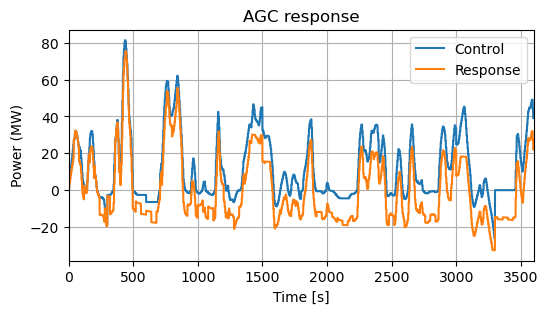

In [12]:
sse.plot_agc()

In [13]:
sse.data

{'ts': 18.999722222225575,
 'Pi': 39.043929637268995,
 'Pr': 53.13430002198744,
 'Prc': 21.957122485718315,
 'Per': 14.090370384718444,
 'ne': 17309,
 'nec': 12524,
 'Ptc': -18.69075797413205,
 'Pcc': -40.603856947690105,
 'Pdc': 21.91309897355805,
 'Pt': -18.8364451491898}

In [14]:
col = ['u', 'lc', 'c', 'c0', 'soc', 'soc0', 'socd', 'c', 'sx', 'agc', 'na0', 'na', 'nam']
sse.ev[((sse.ev['c']!=0)) & (sse.ev['lc']==1)][col]
# sse.ev[(sse.ev['c0']1)][col]

# self = sse
# self.ev['agc'] = self.ev['agc'] * (1 - self.ev['lc'])
# self.ev[((sse.ev['c']!=0)) & (sse.ev['lc']==1)][col]

,u,lc,c,c0,soc,soc0,socd,c,sx,agc,na0,na,nam
6755,1,1,-1,2,0.995,0.896499,0.780406,-1,19,1,1874,3290,3290


In [15]:
sse.ev[(sse.ev['lc']==1)]

,u,u0,soc,bd,c,c2,c0,sx,dP,xl,...,lc,agc,mod,na,nam,soc0,na0,pv,pu,p
4,1,1,0.995000,1,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,2837,2837,1.000000,2837,-0.000000,0.0,1.0
5,1,1,0.941300,0,0,1,1,18,0.0,"[[], [], []]",...,1,0,0,2975,2975,0.941300,2975,0.239898,-0.0,1.0
8,1,1,0.980665,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3947,3947,0.980665,3947,-0.000000,0.0,1.0
13,1,1,0.973578,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3793,3793,0.950188,3485,-0.000000,0.0,1.0
22,1,1,0.931749,0,0,1,1,18,0.0,"[[], [], []]",...,1,0,0,3130,3130,0.909820,2852,0.239898,-0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17357,1,1,0.912028,0,0,1,1,18,0.0,"[[], [], []]",...,1,0,0,3078,3078,0.909557,3036,0.239898,-0.0,1.0
17363,1,1,0.959344,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3706,3706,0.959344,3706,-0.000000,0.0,1.0
17366,1,1,0.983490,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3939,3939,0.955768,3585,-0.000000,0.0,1.0
17367,1,1,0.971583,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3121,3121,0.971583,3121,-0.000000,0.0,1.0


In [16]:
evc

NameError: name 'evc' is not defined

In [ ]:
sse.plot()

In [ ]:
sse.plot_agc()

In [ ]:
sse.data

In [ ]:
# ssa.TDS.save_output()

In [ ]:
%run -i 'cosim_plot.py'

In [ ]:
sse.ev.columns

In [ ]:
self = sse
scaler = 1

# predicted na; scale with running time
pna = (self.ev['na'] - self.ev['na0']) * (self.ev['tf'] -
                                          self.tsd['ts'].iloc[0]) / (self.data['ts'] - self.tsd['ts'].iloc[0])
if self.config['ict']:
    pna[pna > self.ev['nam']] = self.ev['nam'][pna > self.ev['nam']]  # upper cap
pna[pna < 0] = 0  # lower cap TODO: is this necessary?
# adjust by charging efficiency; unit: hour
self.ev['ict'] = pna / self.ev['nc'] * self.config['t_agc'] / 3600
self.ev['ict'] *= scaler  # scale
self.ev['ict'].hist(bins=30)
self.ev['tt'].hist(bins=30)

In [ ]:
sse.ev.soc0

In [ ]:
sse.ict()
sse.ev['ict'].hist(bins=30)
sse.ev['tt'].hist(bins=30)

In [ ]:
sse.ict2()
sse.ev['ict'].hist(bins=30)
sse.ev['tt'].hist(bins=30)

In [ ]:
# plot the AGC signal

figa, axa = plt.subplots()
axa.plot(range(0, 3600, 4),
         ssa.config.mva * agc_out.values[10:, 1:].reshape(900, 1),
         color='tab:orange')
axa.plot(range(0, 3600, 4),
         ssa.config.mva * agc_in.values[10:, 1:].reshape(900, 1),
         color='tab:red')
ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader,
                 ytimes=ssa.config.mva,
                 legend=False, show=False,
                 title=r'AGC power', ylabel='MW',
                 fig=figa, ax=axa, style='default',
                 left=1000, right=2000)
axa.legend(['AGC_out-EV', 'AGC_in-EV'])

In [ ]:
sim_name = '_F_ict'
cosim_out.to_csv('cosim_18' + sim_name + '_out.csv', index=False)
sse_out.to_csv('cosim_18' + sim_name + '_sse.csv', index=False)
bu_df.to_csv('cosim_18' + sim_name + '_bu.csv', index=False)
bd_df.to_csv('cosim_18' + sim_name + '_bd.csv', index=False)
pg_df.to_csv('cosim_18' + sim_name + '_pg.csv', index=False)
agc_mile.to_csv('cosim_18' + sim_name + '_agcm.csv', index=False)
sfr_res.to_csv('cosim_18' + sim_name + '_sfr.csv', index=False)
ev_agc.to_csv('cosim_18' + sim_name + '_evagc.csv', index=False)
ev_soc.iloc[0:800].to_csv('cosim_18' + sim_name + '_evsoc1.csv', index=False)
ev_soc.iloc[800:].to_csv('cosim_18' + sim_name + '_evsoc2.csv', index=False)
sse.ev.to_csv('cosim_18' + sim_name + '_evdata.csv', index=False)

import csv
new_path = open('cosim_18' + sim_name + '_rted.csv', 'w')
z = csv.writer(new_path)
for new_k, new_v in rted_res.items():
    z.writerow([new_k, new_v])
new_path.close()

In [ ]:
# split -l 4 index.txt split_file
# !ls -lh

plt.style.use('science')
%run -i 'cosim_plotev.py'